In [64]:
from selenium import webdriver
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup
import re
import time
from datetime import date, datetime, timedelta
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.linalg import cholesky
from scipy import stats
import random
import pulp
from pulp import *
import statsmodels.api as sm

In [65]:
file = open("consolidated_roto.pkl",'rb')
data = pkl.load(file)

In [66]:
# some important helper functions

def add_position_requirement(prob,example_results, example_projections, choices, pos, number):
    players = list(example_projections.keys())
    POS = list(example_results[example_results.apply(lambda x: pos in x['Pos'].split('/'), axis=1)].Player)
    POS = [re.sub(r'([^\s\w]|_)+', '', a) for a in POS]
    POS = [name.split()[0]+ " " + name.split()[1] for name in POS]
    prob += lpSum([choices[v] for v in POS if v in players]) >= number

def add_all_position_requirements(prob, results, projections, choices):
    add_position_requirement(prob, results, projections,choices, 'C',1)
    add_position_requirement(prob, results, projections,choices,  'PG', 1)
    add_position_requirement(prob, results, projections,choices, 'SG', 1)
    add_position_requirement(prob, results, projections,choices, 'PF', 1)
    add_position_requirement(prob, results, projections,choices, 'SF', 1)
    add_position_requirement(prob, results, projections,choices, 'F', 2)
    add_position_requirement(prob, results, projections,choices, 'G', 2)
    
def get_Fpts(df, player):
    df = df[df['Player'] == player]
    #print(df)
    #print(player)
    #return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    if df.empty:
        return -1
    return 0 if df.empty or np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    #try:
    #    return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    #except:
        #print("??? {}".format(player))
    #    return 0
def get_payout(df, points):
    df = df[df['Points'] < points]
    if df.empty:
        return 0
    try:
        return float(df.iloc[0].Prize[1:].replace(",",""))
    except:
        return 0

def process_name(name):
    filtered = re.sub(r'([^\s\w]|_)+', '', name)
    #dumb edge cases
    #print(filtered)
    if filtered == 'Moe Harkless':
        filtered = 'Maurice Harkless'
    if filtered == 'Wes Iwundu':
        filtered = 'Wesley Iwundu'
    if filtered == 'Juan Hernangomez':
        filtered = 'Juancho Hernangomez'
    if filtered.strip() == 'Nene':
        return "Nene"
    return filtered.split()[0]+ " " + filtered.split()[1]

## Process the Data to make it more clean

In [67]:
#first we filter out non-regular season dates
REG_SEASON_DATES = [('2017-10-17', '2018-04-11'), ('2018-10-16', '2019-04-10'),
                ('2019-10-22', '2020-04-15')]
DATES = [(datetime(2017,10,17), datetime(2018,4,11)), (datetime(2018,10,16), datetime(2019,4,10)),
                (datetime(2019,10,22), datetime(2020,2,15))]
def between(date, tuple_date):
    return date >= tuple_date[0] and date <= tuple_date[1]
data = {k: v for k, v in data.items() if between(datetime.strptime(k, "%Y-%m-%d"), DATES[0])\
       or between(datetime.strptime(k, "%Y-%m-%d"), DATES[1]) or between(datetime.strptime(k, "%Y-%m-%d"), DATES[2]) }
#data.keys()

In [68]:
# process the data
#trasform the columns so the names agree with each other
for date in list(data.keys()):
    if data[date]['PROJECTIONS'] ==False:
        print("data for {} not found".format(date))
        del data[date]
        continue
    data[date]['PROJECTIONS'] = dict((process_name(key), value) for (key, value)\
                                     in data[date]['PROJECTIONS'].items() if data[date]['PROJECTIONS'] is not False)
    data[date]['ACTUAL_POINTS'].Player = data[date]['ACTUAL_POINTS'].Player.apply(lambda x: process_name(x))

data for 2017-11-21 not found
data for 2018-01-12 not found
data for 2018-01-26 not found
data for 2018-02-16 not found
data for 2018-02-18 not found
data for 2018-12-21 not found
data for 2019-02-15 not found
data for 2019-02-17 not found


In [69]:
#filter out for incorrect contests
for date in data:
    for contest in data[date]['CONTESTS']:
        if contest['Cash Line'] == 0:
            data[date]['CONTESTS'].remove(contest)

## Case Study Individual Player Predictive Power

In [169]:
PLAYERS = [data[date]["PROJECTIONS"].keys() for date in data.keys()]
PLAYERS = list(set([item for sublist in PLAYERS for item in sublist]))
#PLAYERS

In [163]:
def get_residuals(player):
    residuals = []
    for date in data:
        if player in data[date]["PROJECTIONS"]:

            #print(PLAYER)
            projected = data[date]['PROJECTIONS'][player]['points']
            actual = get_Fpts(data[date]["ACTUAL_POINTS"], player)
            if actual >= 0:
                #print(date, projected, actual, projected-actual)
                residuals.append(projected-actual)

    return residuals

#print(times)

In [70]:
#returns predicted/actual tuple as (projected, floor, ceil, actual)
def get_pairs(player):
    pairs = []
    for date in data:
        #print (data[date]["PROJECTIONS"].keys())
        #print(data[date]['ACTUAL_POINTS'].Player)
        if player in set(data[date]["PROJECTIONS"].keys()).intersection(data[date]['ACTUAL_POINTS'].Player):
             #print(PLAYER)
            projected = data[date]['PROJECTIONS'][player]['points']
            floor = data[date]['PROJECTIONS'][player]['floor']
            ceil = data[date]['PROJECTIONS'][player]['ceil']
            actual = get_Fpts(data[date]["ACTUAL_POINTS"], player)
            if actual >= 0:
                pairs.append((projected,floor, ceil, actual))
    return pairs

In [244]:
player_data = {}
total_residuals = []
for player in PLAYERS:
    residuals = get_residuals(player)
    total_residuals += residuals
    player_data[player] = {}
    player_data[player]["mean"] = np.mean(residuals)
    player_data[player]['std'] = np.std(residuals)
    print(player, np.std(residuals), np.mean(residuals))

Paul George 17.472102822836888 2.6155232558139536
Yante Maten 0.0 4.33
Ray Spalding 19.567229266225322 -1.5245454545454549
Will Barton 13.13375531381296 2.727597402597403
DJ Augustin 10.279535968191391 0.9680346820809245
Kendrick Nunn 12.089840891334253 2.898333333333333
Trevor Ariza 11.547838062086454 1.7156969696969695
Scott Machado 0.4450000000000003 6.285
Charles Cooke 0.0 0.0
Isaiah Hartenstein 10.071933027775605 2.8659459459459455
Darrun Hilliard 1.8423677021702265 1.0625
Nicolas Brussino 0.0 0.0
Tyrone Wallace 9.033210941488907 2.153815789473684
DJ Wilson 9.482435693611103 2.437536231884058
Blake Griffin 20.26744402729252 8.54956204379562
Ike Anigbogu 1.6147705566479975 0.3977777777777778
Rayjon Tucker 7.295400377406758 3.8699999999999997
Mirza Teletovic 6.2214179104386265 0.28857142857142826
Isaiah Canaan 9.599283431137158 2.544999999999999
Vander Blue 0.8300000000000001 3.15
Malik Beasley 9.757777069969368 -0.18924050632911377
Ian Mahinmi 8.951267489357948 2.479565217391304
Ma

Al Horford 12.654664483381799 3.7962048192771087
Josh McRoberts 3.78 3.78
Coby White 8.76432471728427 1.7764999999999997
Ish Smith 10.698520479134876 3.206766467065868
Shaquille Harrison 8.789302375439906 1.1624444444444444
Kris Dunn 13.231091408190231 4.375187969924812
Edmond Sumner 7.33729831164359 1.0777419354838709
BJ Johnson 7.142373275039607 -2.862
Vince Hunter 0.6383246300538099 0.395
Thabo Sefolosha 8.563998277873369 0.5640404040404041
Miles Plumlee 6.4567328497445615 1.1076190476190475
Kemba Walker 18.194194969772827 5.933387978142076
Nerlens Noel 8.901843407536438 0.9736956521739135
Willy Hernangomez 9.067597857706907 15.300000000000002
Kyle Singler 2.204079238425016 0.9227272727272727
Quincy Pondexter 4.694035602998185 2.6905882352941175
CJ Miles 7.954226784193751 2.1256410256410256
Trey Lyles 9.462503765642206 0.1876923076923076
Iman Shumpert 9.403130366709448 1.5892
Patrick Beverley 12.40761078105175 4.515486725663717
LeBron James 18.342031749610065 3.297222222222223
Zhou 

Jaren Jackson 13.01807148786478 4.8
Milos Teodosic 8.364364152907815 3.1083018867924523
Jon Leuer 5.689451841693817 3.5827272727272734
Nicolo Melli 9.609818889179975 0.6796153846153845
Marcus GeorgesHunt 2.927092045016692 1.3503999999999998
Duncan Robinson 10.003426410516413 0.34422222222222204
Brook Lopez 11.651011739435727 3.116944444444445
Dairis Bertans 4.2002149415899614 4.626666666666666
Courtney Lee 9.886035113031731 2.158080808080808
Gabe Vincent 0.0 7.609999999999999
Lucas Nogueira 7.195730467436923 3.1648
Aaron Brooks 5.074054583555197 -0.027368421052631625
Patty Mills 9.579284035292453 1.4820526315789475
Gian Clavell 3.232102402075157 -0.06874999999999998
Joel Bolomboy 1.2869861434115495 -0.91
JaMychal Green 11.274835646202959 2.2464666666666657
Keita BatesDiop 8.83121257430396 0.7519230769230771
Myke Henry 8.302153887368636 1.2376470588235298
Mike Scott 8.029051886564568 1.7332085561497328
Devon Hall 0.27 3.15
Gorgui Dieng 9.087027388670737 1.0016666666666665
Derrick Favors

Isaac Bonga 7.609207973294022 3.072244897959184
Denzel Valentine 11.401838893407886 1.102608695652174
Maxi Kleber 9.29338667610778 0.4089595375722545
Kay Felder 6.0397929938271915 0.27923076923076917
Shai GilgeousAlexander 13.009040638201915 4.101583333333333
Garrett Temple 10.243867850731608 2.780529411764706
Jaylen Brown 11.211122162637293 2.7564071856287424
Jordan Bell 8.660824019671923 1.709236641221374
Emeka Okafor 10.16440655359351 3.0196428571428577
Zylan Cheatham 0.0 -4.85
Buddy Hield 12.941811373625649 1.647435897435897
Grayson Allen 8.707862075646032 0.8338297872340428
Nikola Vucevic 15.698082515904016 4.414285714285715
Daniel Theis 9.855854487625214 0.6192715231788078
Isaiah Taylor 8.86035323182075 1.6321311475409837
Andrew Bogut 6.648978061415623 -0.7006451612903224
Garrison Mathews 10.079761082043284 -1.8972727272727277
Dion Waiters 11.616123115501045 2.9441891891891894
Amir Johnson 8.631854562084486 0.6186842105263158
Isaiah Briscoe 7.661863067147717 1.477083333333333
Jam

Nickeil AlexanderWalker 10.003910426354562 1.746086956521739
Jonas Valanciunas 14.00381075373779 1.2404430379746836
Brice Johnson 2.4549780763525972 -0.44909090909090904
Yogi Ferrell 8.379276929183044 0.31207547169811317
Dwayne Bacon 9.58912928499999 3.121333333333333
Johnathan Motley 11.559304295219228 1.04
Raymond Felton 6.649678903196599 0.9678723404255318
Kevin Huerter 11.447192789495825 2.2811607142857144
Alec Burks 10.238055471507717 0.466967741935484
Jordan Loyd 4.991259234902551 2.8975
Frank Ntilikina 9.279853033657114 3.282587412587412
Kawhi Leonard 18.297679504703797 5.298446601941747
MarShon Brooks 10.878545502461943 2.5964705882352943
Aron Baynes 9.384030752448151 1.767837837837838
LaMarcus Aldridge 15.54147927073259 3.1535393258426963
Willie CauleyStein 11.320036993897586 1.8541111111111113
Deandre Ayton 12.27062081961946 1.0795698924731187
Kelly Olynyk 12.65134399326092 2.8600537634408605
Dante Cunningham 8.486545969536461 1.2025833333333333
Emmanuel Mudiay 13.07682851205

In [182]:
print("Overall overpredicts by {}".format(np.mean(total_residuals)))
print("Overall standard deviation is {}".format(np.std(total_residuals)))

Overall overpredicts by 0.35174784033363127
Overall standard deviation is 9.543301531849794


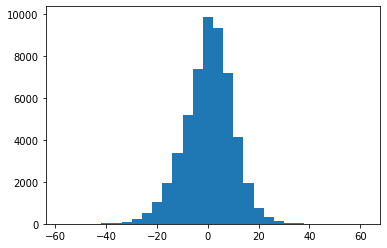

-0.2954483471661959

In [256]:
from scipy.stats import kurtosis, skew
plt.hist(total_residuals, bins=30)
plt.show()
skew(total_residuals)

# Now lets look at inter-player correlations

In [414]:
#we will need these functions for later
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [415]:
nearestPD(np.array([[1,5,0],[0,1,0],[0,0,1]]))

array([[1.75, 1.75, 0.  ],
       [1.75, 1.75, 0.  ],
       [0.  , 0.  , 1.  ]])

In [400]:
def correlate(player1, player2):
    if player1 == player2:
        return 1
    residuals1 = []
    residuals2 = []
    for date in data:
        if player1 in data[date]["PROJECTIONS"] and player2 in data[date]["PROJECTIONS"]:

            #print(player1, player2)
            projected1 = data[date]['PROJECTIONS'][player1]['points']
            actual1 = get_Fpts(data[date]["ACTUAL_POINTS"], player1)
            projected2 = data[date]['PROJECTIONS'][player2]['points']
            actual2 = get_Fpts(data[date]["ACTUAL_POINTS"], player2)
            if actual1 >= 0 and actual2 >= 0:
                #print(date, projected, actual, projected-actual)
                residuals1.append(projected1-actual1)
                residuals2.append(projected2-actual2)
    if len(residuals1) < 20:
        return 0
    #return (residuals1, residuals2), np.corrcoef(residuals1,residuals2)
    return np.corrcoef(residuals1,residuals2)[0][1]

In [375]:
def get_most_recent_team(data, player):
    for date in list(data.keys())[::-1]:
        #print(date)
        if player in data[date]["PROJECTIONS"]:
            return data[date]["PROJECTIONS"][player]['team']

In [376]:
current_player_teams = {}
for player in PLAYERS:
    current_player_teams[player] = get_most_recent_team(data, player)
#get_most_recent_team(data, "LeBron James")
#current_player_teams

In [635]:
val = correlate("Brandon Ingram", "Jaxson Hayes")
val

0.5109116514021019

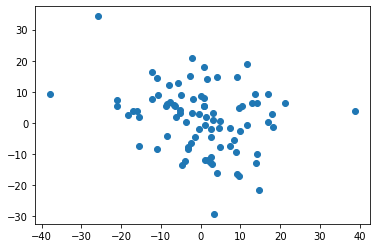

In [251]:
plt.scatter(arrays[0], arrays[1])

In [247]:
mat

array([[ 1.        , -0.07235873],
       [-0.07235873,  1.        ]])

In [249]:
for player1 in PLAYERS:
    print(player1)
    for player2 in {k: v for k, v in current_player_teams.items() if v == current_player_teams[player1]}:
        print(correlate(player1,player2)[1][0][1], player2)

Troy Daniels
1.0 Troy Daniels
-0.02459190094811281 Danny Green
0.04081751278591417 Travis Wear
-0.3970309962823802 Tyler Ennis
nan Scott Machado
0.02512807634493565 Dwight Howard
-0.04472976543284329 Rajon Rondo
-0.18374094099061059 Avery Bradley
0.10997546070296282 Michael Beasley
nan Derrick Williams
-0.03664203825700262 Quinn Cook
0.028307177226033823 Lance Stephenson
-0.009081715455905649 Jared Dudley
nan Vander Blue
0.026426694346908194 JaVale McGee
1.0 Jemerrio Jones
-0.0460807326672738 Kyle Kuzma
-0.0723587296942244 LeBron James
-0.018093457618714167 Anthony Davis
0.013391145335168837 Alex Caruso
-0.12697376460524706 Kentavious CaldwellPope
nan Andre Ingram
Treveon Graham
1.0 Treveon Graham
nan Jaylen Morris
-0.012249342677505515 Trae Young
0.0466872814321777 DeAndre Bembry
-0.06649112094607194 Alex Len
0.9999999999999999 Andrew White
0.11270349449036274 Vince Carter
0.1182867092540823 Dewayne Dedmon
nan Antonius Cleveland
-0.20737168990039914 Malcolm Delaney
nan Jordan Sibert
-

0.043063161274552494 Luke Kornet
-0.23479410398588454 Tomas Satoransky
nan Rawle Alkins
-0.3462755734360447 Wendell Carter
-0.12771701276765593 Cristiano Felicio
-0.03652634108665611 Denzel Valentine
nan Shaq Harrison
nan Brandon Sampson
nan Tyler Ulis
nan Cristiano Da
0.08548751438124148 Zach LaVine
0.13385445377920305 Lauri Markkanen
nan Walter Lemon
Kelan Martin
1.0 Kelan Martin
-0.3387303026093118 Jordan Bell
-0.17460651297906465 KarlAnthony Towns
nan Jared Terrell
-1.0 Jaylen Nowell
0.30517375567271016 Gorgui Dieng
-0.9999999999999997 Malik Beasley
nan Juancho Hernangomez
-0.18281180374215822 James Johnson
-0.9752113171858501 Jordan McLaughlin
nan Luol Deng
-0.3811760558574822 Naz Reid
-0.28274157628151914 Josh Okogie
nan Cole Aldrich
nan Jerryd Bayless
nan CJ Williams
nan Marcus GeorgesHunt
0.04285885358656872 Jarrett Culver
0.7653689843865545 Allen Crabbe
nan Anthony Brown
nan Cameron Reynolds
nan Aaron Brooks
nan Jake Layman
Dorian FinneySmith
0.9999999999999999 Dorian FinneySm

-0.05440441363711136 Cedi Osman
0.09736927598989507 Andre Drummond
0.19283381712563152 Kevin Love
-0.1711254607970249 Alfonzo McKinnie
-0.00011195119584710868 Larry Nance
0.5583477580780863 Ante Zizic
0.49354549309022994 Cameron Payne
0.02566852269302211 Kevin Porter
-0.10777798625119457 Channing Frye
-0.9960583471722291 John Holland
nan London Perrantes
-0.03395341656181788 Collin Sexton
-0.17006233436672086 Tristan Thompson
Matt Costello
nan Dante Cunningham
nan Matt Costello
nan Joffrey Lauvergne
nan Brandon Paul
nan Drew Eubanks
nan Marco Belinelli
nan Trey Lyles
nan Lonnie Walker
nan Chimezie Metu
nan Bryn Forbes
nan Derrick White
nan Darrun Hilliard
nan LaMarcus Aldridge
nan Manu Ginobili
nan Dejounte Murray
nan Patty Mills
nan Rudy Gay
nan Jakob Poeltl
nan DeMarre Carroll
nan Quincy Pondexter
nan DeMar DeRozan
Mike Scott
-0.14748561652283385 Tobias Harris
-0.06497171035594994 Ben Simmons
0.8344784117878014 Zhaire Smith
0.9999999999999999 Mike Scott
-0.10588207501184389 James Enn

-0.012249342677505515 Treveon Graham
nan Jaylen Morris
1.0 Trae Young
0.003560470962936205 DeAndre Bembry
0.1512696313656448 Alex Len
nan Andrew White
0.09033976764879775 Vince Carter
0.2544513581388135 Dewayne Dedmon
nan Antonius Cleveland
nan Malcolm Delaney
nan Jordan Sibert
-0.1511994387709752 Jabari Parker
0.07433649469115626 DeAndre Hunter
-0.2883076768559387 Jaylen Adams
0.023503999354788446 Tyrone Wallace
0.09094412211401973 Kevin Huerter
-0.033834789628991446 Cam Reddish
nan Isaiah Taylor
-0.09121907185811044 Damian Jones
-0.7604006546179314 Daniel Hamilton
-0.07720017764797091 Evan Turner
-0.37617580148186097 Jeff Teague
-0.33517711657801325 Brandon Goodwin
0.047418649049426824 Alex Poythress
nan Charles Brown
0.18574588525081273 Miles Plumlee
-0.01717341035555362 Bruno Fernando
nan Nicolas Brussino
-0.3350381039496302 Deyonta Davis
0.040280341055343324 John Collins
Luc Mbah
nan Luc Mbah
nan Marcus Morris
nan Mfiondu Kabengele
nan Lou Williams
nan Luc Richard
nan Marcin Gorta

-0.5935199170145182 Yuta Watanabe
-0.2212081582120805 Tyus Jones
nan Myke Henry
nan Kobi Simmons
-0.0642217567586819 Kyle Anderson
-0.2079589348214263 MarShon Brooks
nan Xavier RathanMayes
nan Marquis Teague
nan Tyler Zeller
0.9889707096306574 Chandler Parsons
nan Briante Weber
nan Vince Hunter
-0.22942413753259194 Ja Morant
-0.10823303838481128 CJ Miles
Travis Wear
0.04081751278591417 Troy Daniels
0.1891201148352144 Danny Green
0.9999999999999999 Travis Wear
-0.07549461775360981 Tyler Ennis
nan Scott Machado
0.7476833653274341 Dwight Howard
0.401631945047294 Rajon Rondo
nan Avery Bradley
0.07643837785441611 Michael Beasley
nan Derrick Williams
0.04209018947165198 Quinn Cook
0.0637352028804028 Lance Stephenson
-0.18924641761266245 Jared Dudley
nan Vander Blue
-0.139076023668727 JaVale McGee
nan Jemerrio Jones
-0.36252136422278064 Kyle Kuzma
-0.2910922710718695 LeBron James
0.3324394350989288 Anthony Davis
-0.3771608712033609 Alex Caruso
0.5204390629068698 Kentavious CaldwellPope
nan An

0.40541898692130657 Skal Labissiere
-0.04478392500674517 Hassan Whiteside
-0.07119433331449647 Mario Hezonja
-0.556968763699721 Carmelo Anthony
Omari Johnson
nan DeAnthony Melton
1.0 Dillon Brooks
nan Jaren Jackson
1.0 Ivan Rabb
1.0 Omari Johnson
nan Julian Washburn
nan John Konchar
nan Omri Casspi
nan Brandon Clarke
nan Brice Johnson
-0.9999999999999999 Jonas Valanciunas
nan Grayson Allen
nan Josh Jackson
nan Dusty Hannahs
-1.0 Mario Chalmers
nan Marko Guduric
nan Tyler Dorsey
nan Bruno Caboclo
nan Joakim Noah
nan Yuta Watanabe
-1.0 Tyus Jones
-1.0 Myke Henry
1.0 Kobi Simmons
-1.0 Kyle Anderson
-1.0 MarShon Brooks
nan Xavier RathanMayes
nan Marquis Teague
1.0 Tyler Zeller
nan Chandler Parsons
nan Briante Weber
nan Vince Hunter
nan Ja Morant
1.0 CJ Miles
Marcus Morris
nan Luc Mbah
0.9999999999999998 Marcus Morris
nan Mfiondu Kabengele
0.009566569081447606 Lou Williams
-0.005467932304608279 Luc Richard
0.08986324757735237 Marcin Gortat
0.08674226778137752 JaMychal Green
0.31288225899142

-0.22592598206263678 Trey Lyles
nan Lonnie Walker
nan Chimezie Metu
0.10046493343787333 Bryn Forbes
nan Derrick White
-0.9079440166829009 Darrun Hilliard
-0.4861171233124587 LaMarcus Aldridge
-0.02082127051569927 Manu Ginobili
-0.039985198934163274 Dejounte Murray
-0.09090289396065052 Patty Mills
-0.025749281601131716 Rudy Gay
0.3479992180325233 Jakob Poeltl
-0.2529254709036911 DeMarre Carroll
0.33041963164744415 Quincy Pondexter
0.253997819057401 DeMar DeRozan
Iman Shumpert
0.2522411557790243 DeAndre Jordan
nan Mitch Creek
0.39903793354537714 Timothe LuwawuCabarrot
1.0 Iman Shumpert
-0.9999999999999999 Isaiah Whitehead
-0.44076563085897363 Wilson Chandler
0.3690535207184617 Theo Pinson
nan Nicolas Claxton
nan Yakuba Ouattara
0.13479356795856373 Caris LeVert
nan James Webb
-0.8028537036854589 Dzanan Musa
0.09439811077555876 Timofey Mozgov
-0.174221680761305 Garrett Temple
-0.04550954489695556 Jarrett Allen
0.32124319630837134 Kyrie Irving
0.2161031445087415 Taurean Prince
0.01527472799

0.26449475566152003 Lonzo Ball
nan Zylan Cheatham
1.0 Ian Clark
0.08371878656422323 DeAndre Liggins
-0.0651958202142489 Tony Allen
-0.027716267256388524 Emeka Okafor
nan Zion Williamson
nan Jaxson Hayes
0.3367879486922997 Larry Drew
0.4002851767808115 Mike James
-0.9419067598019242 Josh Smith
nan Nickeil AlexanderWalker
0.051460902167061943 Brandon Ingram


KeyboardInterrupt: 

In [248]:
{k: v for k, v in current_player_teams.items() if v == current_player_teams["Draymond Green"]}

{'Draymond Green': 'GSW',
 'Jonas Jerebko': 'GSW',
 'Andrew Wiggins': 'GSW',
 'Stephen Curry': 'GSW',
 'Ky Bowman': 'GSW',
 'DeMarcus Cousins': 'GSW',
 'David West': 'GSW',
 'Andrew Bogut': 'GSW',
 'Marquese Chriss': 'GSW',
 'Jacob Evans': 'GSW',
 'Alen Smailagic': 'GSW',
 'Klay Thompson': 'GSW',
 'DAngelo Russell': 'GSW',
 'Marcus Derrickson': 'GSW',
 'Jordan Poole': 'GSW',
 'Shaun Livingston': 'GSW',
 'Eric Paschall': 'GSW',
 'Kevon Looney': 'GSW',
 'Damion Lee': 'GSW',
 'Kevin Durant': 'GSW',
 'Omari Spellman': 'GSW'}

In [242]:
for player1 in ["LeBron James"]:
    print(player1)
    for player2 in {k: v for k, v in current_player_teams.items() if v == current_player_teams[player1]}:
        print(correlate(player1,player2)[1][0][1], player2)

LeBron James
-0.07235872969422441 Troy Daniels
-0.029540056046122972 Danny Green
-0.29109227107186947 Travis Wear
0.20060253184747426 Tyler Ennis
nan Scott Machado
-0.10545753163878423 Dwight Howard
-0.20820534829541065 Rajon Rondo
0.1696204291979509 Avery Bradley
0.14234178161072036 Michael Beasley
nan Derrick Williams
-0.1266436742961806 Quinn Cook
-0.18467414514099012 Lance Stephenson
0.09686810820383877 Jared Dudley
1.0 Vander Blue
0.07163222247633312 JaVale McGee
nan Jemerrio Jones
0.16181730807462053 Kyle Kuzma
1.0 LeBron James
-0.33010577181642164 Anthony Davis
-0.19344912635236722 Alex Caruso
-0.05761477652559605 Kentavious CaldwellPope
1.0 Andre Ingram


In [244]:
correlate("LeBron James", "Andre Ingram")

(([12.490000000000002, 3.8800000000000026], [4.52, -0.6200000000000001]),
 array([[1., 1.],
        [1., 1.]]))

In [253]:

slope, intercept, r_value, p_value, std_err = stats.linregress(arrays[0], arrays[1])

In [254]:
print(slope, intercept, r_value, p_value, std_err)

-0.230950969728548 1.3014531093108075 -0.25618238027779444 0.01727268560285807 0.09508028399416836


# Payout per Points explorations

In [26]:
sum_payout_return

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [11]:
sum_payout_return = [[] for i in range(450)]
num_contests = [0 for i in range(450)]
for date in list(data.keys())[-100:]:
    #print(data[date]['CONTESTS'][0].keys())
    #data[date]['CONTESTS'][0]['PAYOUTS']
    #break
    print(date)
    for contest in data[date]['CONTESTS']:
        for val in range(450):
            #print(get_payout(contest['PAYOUTS'], 1))
            sum_payout_return[val] += [(get_payout(contest['PAYOUTS'], val)/float(contest['Buy In'][1:])-1)]
            num_contests[val] +=1
    #break

2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-06
2019-04-07
2019-04-09
2019-04-10
2019-10-22
2019-10-23
2019-10-24
2019-10-25
2019-10-26
2019-10-27
2019-10-28
2019-10-29
2019-10-30
2019-10-31
2019-11-01
2019-12-01
2019-12-02
2019-12-03
2019-12-04
2019-12-05
2019-12-06
2019-12-07
2019-12-08
2019-12-09
2019-12-10
2019-12-11
2019-12-12
2019-12-13
2019-12-14
2019-12-15
2019-12-16
2019-12-17
2019-12-18
2019-12-19
2019-12-20
2019-12-21
2019-12-22
2019-12-23
2019-12-25
2019-12-26
2019-12-27
2019-12-28
2019-12-29
2019-12-30
2019-12-31
2020-01-01
2020-01-02
2020-01-03
2020-01-04
2020-01-05
2020-01-06
2020-01-07
2020-01-08
2020-01-10
2020-01-11
2020-01-12
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-18
2020-01-19
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-26
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31

In [12]:
sum_payout_return

[[-1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,


In [17]:
len(sum_payout_return)

450

In [18]:
payouts = np.array([sum(sum_payout_return[i]) for i in range(len(sum_payout_return))])/np.array(num_contests)

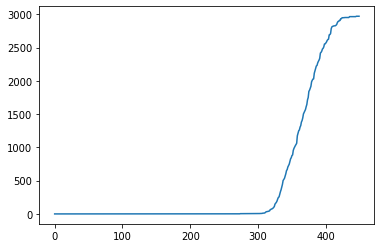

In [19]:
plt.plot(payouts)

In [8]:
data['2017-11-01']['PROJECTIONS']

{'Mario Chalmers': {'ceil': 28.35,
  'floor': 28.35,
  'points': 28.35,
  'salary': 3600.0,
  'team': 'MEM'},
 'Tyreke Evans': {'ceil': 33.17,
  'floor': 33.17,
  'points': 33.17,
  'salary': 5300.0,
  'team': 'MEM'},
 'Dennis Schroder': {'ceil': 43.64,
  'floor': 43.64,
  'points': 43.64,
  'salary': 7000.0,
  'team': 'ATL'},
 'Mike Muscala': {'ceil': 22.64,
  'floor': 22.64,
  'points': 22.64,
  'salary': 3700.0,
  'team': 'ATL'},
 'Jarrett Jack': {'ceil': 28.62,
  'floor': 28.62,
  'points': 28.62,
  'salary': 4700.0,
  'team': 'NYK'},
 'Jason Smith': {'ceil': 22.32,
  'floor': 22.32,
  'points': 22.32,
  'salary': 3700.0,
  'team': 'WAS'},
 'Jonas Valanciunas': {'ceil': 29.34,
  'floor': 29.34,
  'points': 29.34,
  'salary': 4900.0,
  'team': 'TOR'},
 'Bojan Bogdanovic': {'ceil': 23.88,
  'floor': 23.88,
  'points': 23.88,
  'salary': 4000.0,
  'team': 'IND'},
 'Dillon Brooks': {'ceil': 22.97,
  'floor': 22.97,
  'points': 22.97,
  'salary': 3900.0,
  'team': 'MEM'},
 'Marc Gasol':

In [55]:
vals = []
for date in list(data.keys())[-100:]:
    for i in range(10):
        projs = data[date]["PROJECTIONS"]
        #print(data[date].keys())
        results = data[date]["ACTUAL_POINTS"]

        candidates = set(projs.keys()).intersection(results.Player)
        sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"] for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append( resid)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

2019-03-21 116 235.39999999999998 30.596298494035757 198.25 -1.2141991622693102
2019-03-21 116 190.46 27.749367438726004 190.25 -0.00756774007420939
2019-03-21 116 175.83999999999997 25.70146361740715 170.0 -0.22722441363396306
2019-03-21 116 144.79000000000002 25.166619486995526 149.25 0.17721887527661861
2019-03-21 116 192.16 26.574212930517188 159.25 -1.2384186160489044
2019-03-21 116 215.31999999999996 26.674593179699 188.75 -0.9960789212793455
2019-03-21 116 167.36000000000004 26.70849864435747 153.75 -0.5095756291368829
2019-03-21 116 154.61 24.885953976204526 151.0 -0.14506174862542245
2019-03-21 116 167.41 26.87736485301417 147.75 -0.7314705183159063
2019-03-21 116 160.03 26.776581699533082 202.0 1.567414409761342
2019-03-22 138 127.17999999999999 24.337480585464647 108.75 -0.7572681952546539
2019-03-22 138 175.14 26.02098785354136 187.0 0.45578592429902354
2019-03-22 138 166.84999999999997 24.478639475748896 228.0 2.498096352968539
2019-03-22 138 218.54000000000002 28.82792587

2019-04-01 178 208.45 32.94265553653019 188.75 -0.5980088635585135
2019-04-02 78 132.89 25.00724325360645 153.75 0.8341583191898476
2019-04-02 78 175.93999999999997 27.490462130499928 196.5 0.747895757532183
2019-04-02 78 162.94 26.27576809693964 159.0 -0.14994804283034044
2019-04-02 78 153.95999999999998 23.699597125782876 175.25 0.8983275068772605
2019-04-02 78 222.40999999999997 26.760425309837316 222.25 -0.00597897821680551
2019-04-02 78 212.74999999999997 28.489548272932804 212.75 9.976188164909146e-16
2019-04-02 78 186.58 28.02178982261814 150.5 -1.2875694318025892
2019-04-02 78 214.20000000000002 27.51811446824774 181.25 -1.1973930858533186
2019-04-02 78 156.57 24.142685872941453 130.5 -1.07983014554394
2019-04-02 78 196.71999999999997 27.370735832753457 163.5 -1.2137050389506494
2019-04-03 234 177.04 26.975717937937766 147.75 -1.0857913056248076
2019-04-03 234 189.48999999999998 26.390356213905605 198.0 0.3224662801450149
2019-04-03 234 148.88 22.810767701738868 129.25 -0.86055

2019-10-26 179 185.52 26.552737358959217 212.0 0.9972606455607228
2019-10-26 179 204.7 28.495317212991118 209.0 0.15090198743390812
2019-10-27 79 142.83 27.57303714171745 131.25 -0.419975497819923
2019-10-27 79 163.96999999999997 27.504315583529753 151.75 -0.44429391318203176
2019-10-27 79 200.31 27.62363666418184 265.5 2.3599354709341562
2019-10-27 79 130.17000000000002 23.910974129907242 114.0 -0.6762585209682022
2019-10-27 79 199.92 27.101150316860238 202.75 0.10442361179921597
2019-10-27 79 183.39000000000001 27.680795740907794 192.25 0.3200775036573938
2019-10-27 79 243.68999999999997 30.713598605957316 254.75 0.36010107906583094
2019-10-27 79 225.3 30.09645585164096 213.0 -0.40868599481056084
2019-10-27 79 234.45999999999998 27.242097087382394 223.75 -0.39314153993528217
2019-10-27 79 196.93 27.758925680791506 166.75 -1.0872178681210212
2019-10-28 218 145.41 25.788736065882052 138.5 -0.2679464391875249
2019-10-28 218 150.32 26.98098145066581 171.75 0.7942631753105178
2019-10-28 2

2019-12-08 118 177.59 28.19288992186517 193.5 0.5643266810920614
2019-12-08 118 200.96 29.553534759394964 172.25 -0.9714573987083965
2019-12-08 118 197.48000000000002 27.710022505196996 233.5 1.2998906801048051
2019-12-08 118 195.17999999999998 26.81141918395991 230.25 1.3080247546530792
2019-12-08 118 175.66 28.36766835391439 164.5 -0.3934056144751866
2019-12-08 118 156.53 27.0518829367025 171.75 0.5626225736527324
2019-12-09 185 183.93 27.143670864383573 191.75 0.2880966262474456
2019-12-09 185 193.04 26.188435827183 173.0 -0.7652232509128678
2019-12-09 185 153.25 23.33328099561303 140.75 -0.5357154873483145
2019-12-09 185 206.42 28.727834692340917 226.0 0.681568945578074
2019-12-09 185 157.64 26.98255890624266 217.5 2.2184700942559923
2019-12-09 185 160.07 24.985860593628487 161.25 0.04722671030594449
2019-12-09 185 233.84999999999997 28.870869758677333 175.5 -2.021068311683353
2019-12-09 185 228.89999999999998 30.01712547025217 171.5 -1.9122417320367673
2019-12-09 185 166.890000000

2019-12-22 82 178.43999999999997 23.790402599680345 189.25 0.4543849123488678
2019-12-22 82 149.34 23.936530292389218 158.0 0.36179011302876685
2019-12-22 82 217.12 27.12247774088045 258.0 1.5072369268971129
2019-12-22 82 159.0 25.337319222793003 142.25 -0.6610801976608479
2019-12-22 82 134.57 26.336915282462126 143.25 0.32957542320000016
2019-12-22 82 209.21 28.98233375329562 213.75 0.1566471505933763
2019-12-22 82 184.75999999999996 25.76725755818095 153.5 -1.21316752197694
2019-12-22 82 215.54000000000002 28.967635914226413 244.75 1.0083667195518202
2019-12-22 82 183.0 29.7451741522266 156.75 -0.8824960938423363
2019-12-22 82 178.68000000000004 26.454683407825264 199.25 0.777556082712953
2019-12-23 219 196.68 27.596168596607452 161.25 -1.2838738782149495
2019-12-23 219 234.07999999999998 29.55339010178641 208.25 -0.8740114048181106
2019-12-23 219 181.78999999999996 26.761505022009317 208.0 0.9793918532774705
2019-12-23 219 243.29000000000002 26.93797958706869 235.25 -0.2984633637431

2020-01-05 84 195.66 29.34721531147752 167.75 -0.9510271998135565
2020-01-05 84 143.46 22.628586508767725 163.5 0.8856054704183687
2020-01-05 84 190.01 28.558524038929743 233.5 1.5228378028471052
2020-01-05 84 92.28999999999998 22.320603779122997 90.25 -0.09139537712272995
2020-01-05 84 166.73000000000002 28.29350528974727 196.25 1.043348984075761
2020-01-05 84 164.23000000000002 27.074942690918704 148.25 -0.5902136223305811
2020-01-05 84 199.64999999999998 30.17929560762413 189.25 -0.34460711526257914
2020-01-05 84 154.20999999999998 26.07895909549096 146.5 -0.29564063395969803
2020-01-05 84 186.83999999999997 31.302240004042403 175.0 -0.37824769085122806
2020-01-06 181 202.24 25.685293979677752 188.25 -0.5446696468052467
2020-01-06 181 218.72 26.302052598895695 223.75 0.19123982742743006
2020-01-06 181 174.82999999999998 27.339172108690093 190.5 0.5731702458912102
2020-01-06 181 226.34000000000003 27.21590984187389 218.5 -0.2880667978969255
2020-01-06 181 248.48000000000002 28.213106

2020-01-18 178 228.26999999999998 29.63666776330926 222.25 -0.20312674987883939
2020-01-18 178 125.78999999999999 25.69711779264244 136.75 0.4265069759355681
2020-01-18 178 231.78000000000003 26.367226059367546 198.75 -1.252691501397637
2020-01-18 178 182.3 25.51733611834887 208.25 1.016955683761206
2020-01-18 178 220.25000000000003 29.539377092732153 204.0 -0.5501131573962055
2020-01-18 178 206.83999999999997 25.430090764944453 201.75 -0.20015658013366486
2020-01-18 178 136.54 24.14581380540921 92.5 -1.8239186450669156
2020-01-18 178 182.40999999999997 24.391820321677354 161.75 -0.8470052553494393
2020-01-18 178 256.91 28.789607451565555 222.75 -1.1865392766285332
2020-01-18 178 188.85 22.981831346545654 170.5 -0.7984568210991654
2020-01-19 40 189.82999999999998 27.707671056034357 166.0 -0.8600506318920706
2020-01-19 40 167.60000000000002 27.93253766823131 179.75 0.4349765905379451
2020-01-19 40 165.88 27.30753770043244 125.75 -1.4695576159312416
2020-01-19 40 211.44 28.77307196381638

2020-01-31 137 206.64 28.330641740379928 239.5 1.1598748909794143
2020-01-31 137 182.26 25.970114197942767 178.0 -0.1640347041807559
2020-01-31 137 178.35999999999999 25.23207828671841 185.75 0.29288114581865193
2020-01-31 137 205.63 27.289378284468274 148.75 -2.084327440774757
2020-01-31 137 193.6 25.697328694795722 147.75 -1.7842321489737427
2020-01-31 137 147.24 26.781846914581212 151.5 0.15906296580616552
2020-01-31 137 219.57 29.363523039559205 194.0 -0.8708083143004165
2020-01-31 137 151.2 25.778398716149596 120.0 -1.2103156733491705
2020-01-31 137 129.6 25.94410176100161 166.0 1.4030163902114887
2020-02-01 176 197.1 27.502429033748623 169.75 -0.994457615596005
2020-02-01 176 191.94000000000003 29.18726019748255 178.25 -0.46904025617247935
2020-02-01 176 179.84 26.833182522111308 125.75 -2.015787726835171
2020-02-01 176 186.74 27.977279236253775 201.75 0.5365067801357036
2020-02-01 176 168.19000000000003 26.37136780350167 192.5 0.9218331101040583
2020-02-01 176 191.46000000000004

(array([ 20., 184., 385., 305.,  75.,  19.,   2.,   4.,   2.,   4.]),
 array([-3.06955544, -2.02002148, -0.97048751,  0.07904646,  1.12858043,
         2.17811439,  3.22764836,  4.27718233,  5.32671629,  6.37625026,
         7.42578423]),
 <a list of 10 Patch objects>)

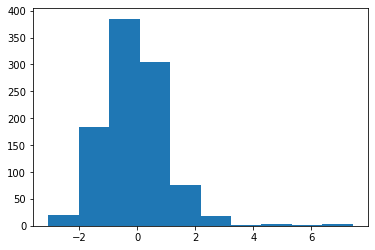

In [56]:
plt.hist(vals)

In [51]:
np.std(vals)

1.1764087240961487

In [52]:
np.mean(vals)

-0.10508790728154224

# Now lets examine what will happen if we generate our top lineups

In [234]:
# some important helper functions

def add_position_requirement(prob,example_results, example_projections, choices, pos, number):
    players = list(example_projections.keys())
    POS = list(example_results[example_results.apply(lambda x: pos in x['Pos'].split('/'), axis=1)].Player)
    POS = [re.sub(r'([^\s\w]|_)+', '', a) for a in POS]
    POS = [name.split()[0]+ " " + name.split()[1] for name in POS]
    prob += lpSum([choices[v] for v in POS if v in players]) >= number

def add_all_position_requirements(prob, results, projections, choices):
    add_position_requirement(prob, results, projections,choices, 'C',1)
    add_position_requirement(prob, results, projections,choices,  'PG', 1)
    add_position_requirement(prob, results, projections,choices, 'SG', 1)
    add_position_requirement(prob, results, projections,choices, 'PF', 1)
    add_position_requirement(prob, results, projections,choices, 'SF', 1)
    add_position_requirement(prob, results, projections,choices, 'F', 2)
    add_position_requirement(prob, results, projections,choices, 'G', 2)
    
def get_Fpts(df, player):
    df = df[df['Player'] == player]
    #print(df)
    #print(player)
    try:
        return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    except:
        #print("??? {}".format(player))
        return 0
def get_payout(df, points):
    df = df[df['Points'] < points]
    if df.empty:
        return 0
    try:
        return float(df.iloc[0].Prize[1:].replace(",",""))
    except:
        return 0

In [241]:
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_ev(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points']-np.mean(player_data[name]["mean"]) for name in players]), "Total Projection"
    prob.solve()
    return(value(prob.objective))
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_var(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]), "Total Variance"
    
    prob.solve()
    return(value(prob.objective))

def get_random_lineup(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(100) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print(pulp.lpDot([choices[v].varValue for v in players],
                    [projections[name]['points'] for name in players]))
    return [player for player in players if (choices[player].varValue == 1)]
    #return(value(prob.objective))
def get_random_lineup_actual(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = list(set(projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(2) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])))
    print(pulp.lpDot([choices[v].varValue for v in players],[example_projections[name]['points'] for name in players]))
    print([choices[v] for v in players if choices[v].varValue == 1])
    #return(value(prob.objective))
    #return prob
    return(pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value()

def get_random_payout(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    global example_contest
    points = get_random_lineup_actual(results, projections,
                                      optimal_variance_ratio=optimal_variance_ratio, optimal_expected_ratio=optimal_expected_ratio)
    payout = get_payout(example_contest, points) - float(COST[1:])
    return payout

In [144]:
get_random_lineup(data['2019-02-01']['ACTUAL_POINTS'], data['2019-02-01']['PROJECTIONS'])

259.83000000000004


['Mario Hezonja',
 'Jerami Grant',
 'Kemba Walker',
 'Ricky Rubio',
 'John Collins',
 'Tyler Johnson',
 'Kyrie Irving',
 'JaMychal Green']

In [96]:
vals = []
payouts = []
for date in list(data.keys())[-100:]:
    for i in range(10):
        projs = data[date]["PROJECTIONS"]
        #print(data[date].keys())
        results = data[date]["ACTUAL_POINTS"]
        contest = data[date]["CONTESTS"][0]

        candidates = set(projs.keys()).intersection(results.Player)
        sample = set(get_random_lineup(results,projs))
        #sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"] for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append(resid)
        payout = get_payout(contest["PAYOUTS"], actual_points) - float(contest["Buy In"][1:])
        payouts.append(payout)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

283.47
2019-03-21 116 283.46999999999997 31.177887635558402 226.5 -1.8272565693329925
283.2
2019-03-21 116 283.2 31.2942001657822 249.5 -1.0768768596568365
284.76
2019-03-21 116 284.76 30.86818675637999 240.0 -1.4500365814570813
283.08000000000004
2019-03-21 116 283.08 31.15186783147423 257.75 -0.8131133624805594
283.31
2019-03-21 116 283.31 31.73312024866685 258.75 -0.7739547768244379
281.62
2019-03-21 116 281.62 31.61320330004672 234.75 -1.4826083758468962
280.82
2019-03-21 116 280.82000000000005 31.5493682049587 207.75 -2.316052718561744
280.93999999999994
2019-03-21 116 280.93999999999994 31.21770247329872 202.5 -2.5126769039807346
285.08000000000004
2019-03-21 116 285.08 31.74078672415393 255.0 -0.9476765734073589
282.78
2019-03-21 116 282.78 31.695058343042806 215.0 -2.1385037145665313
269.77
2019-03-22 138 269.77 29.998110757001868 263.0 -0.2256808788673398
277.6
2019-03-22 138 277.6 28.9478019752683 286.5 0.3074499406761086
273.53
2019-03-22 138 273.53 29.707480578583176 272.5 

271.01
2019-03-31 76 271.01000000000005 29.894546730876094 220.25 -1.6979685444627737
274.1
2019-03-31 76 274.1 30.175994597077576 225.75 -1.6022669888959526
274.63
2019-03-31 76 274.63 28.607562386752964 235.0 -1.3852980363804464
271.03000000000003
2019-03-31 76 271.03000000000003 29.60967074986147 220.0 -1.7234234190273385
267.83
2019-03-31 76 267.83 29.731591384805306 255.0 -0.43152752350003415
270.22
2019-03-31 76 270.22 29.93935444056707 207.5 -2.0949015492136334
267.85
2019-03-31 76 267.85 29.824067640405335 205.25 -2.098975926247907
279.69
2019-04-01 178 279.69 30.191290465566663 294.75 0.49881935378602044
280.04
2019-04-01 178 280.04 30.18453646696174 301.0 0.6943952915408057
279.49
2019-04-01 178 279.48999999999995 30.299921597906987 283.5 0.13234357676612088
278.42
2019-04-01 178 278.41999999999996 29.28756018618293 272.0 -0.21920569549623117
287.88
2019-04-01 178 287.88 29.761827798723278 277.75 -0.3403688801812956
278.74
2019-04-01 178 278.74 30.468373589765093 286.25 0.246

274.53999999999996
2019-10-22 42 274.54 29.71628996904287 295.25 0.6969241456983611
268.54
2019-10-22 42 268.53999999999996 29.42542647844909 276.25 0.2620182924331367
262.43000000000006
2019-10-22 42 262.43 30.086429568572218 277.25 0.49258088156398316
270.98
2019-10-22 42 270.98 28.57541750340284 243.5 -0.961665739327435
267.58
2019-10-22 42 267.58000000000004 29.96460277296037 314.25 1.5575043778692872
265.02
2019-10-23 223 265.02 29.444070212778183 244.25 -0.7054051919420496
264.44
2019-10-23 223 264.44 29.751715517463555 211.5 -1.77939319058511
263.4
2019-10-23 223 263.40000000000003 29.895092569288582 255.0 -0.28098257199007326
267.59000000000003
2019-10-23 223 267.59000000000003 28.912233024677853 238.5 -1.006148503824331
266.65
2019-10-23 223 266.65000000000003 29.80087913619918 225.25 -1.3892207612664482
263.81
2019-10-23 223 263.81000000000006 30.05372163291406 257.25 -0.21827579559450358
268.92999999999995
2019-10-23 223 268.93 28.8968277186867 274.25 0.1841032535401701
267.

267.20000000000005
2019-11-01 163 267.2 31.488134918116067 191.75 -2.3961406477775014
262.73
2019-11-01 163 262.73 32.445302661485364 246.5 -0.5002264940886515
250.13
2019-12-01 79 250.13 25.677736907264705 224.25 -1.0078769828301366
248.83999999999997
2019-12-01 79 248.83999999999997 27.359653115746646 266.5 0.6454760199366688
248.3
2019-12-01 79 248.3 28.004582185983203 255.25 0.24817367221706269
238.97999999999996
2019-12-01 79 238.98000000000002 26.246480158133274 222.0 -0.6469438910549782
250.64
2019-12-01 79 250.64 28.10786018342754 244.25 -0.22733854367781242
238.37
2019-12-01 79 238.37000000000006 28.017495946214805 205.25 -1.1821184899457302
241.25000000000003
2019-12-01 79 241.25 28.432028086126234 217.25 -0.844118468344898
241.8
2019-12-01 79 241.8 26.038037118200684 247.75 0.2285118487614766
244.27
2019-12-01 79 244.26999999999998 29.171848812067825 174.5 -2.3916893457619146
248.95000000000005
2019-12-01 79 248.95 25.966179451424026 248.0 -0.03658605232152815
277.96
2019-12

283.65
2019-12-11 224 283.65 31.06616489552328 313.5 0.9608524290135823
274.7
2019-12-11 224 274.7 29.596346263410915 263.0 -0.39531906728853056
275.21
2019-12-11 224 275.21 29.13184855517122 271.75 -0.1187703551817961
276.49
2019-12-11 224 276.49 29.8329416469045 284.0 0.25173514864496227
279.50000000000006
2019-12-11 224 279.5 30.71017169641069 246.0 -1.0908437872366366
286.13
2019-12-11 224 286.13000000000005 28.825678679634567 284.25 -0.06521962660078766
284.42
2019-12-11 224 284.42 31.565616572158277 289.0 0.1450945838339704
274.91
2019-12-11 224 274.91 29.171290404847742 311.0 1.2371753014396123
273.71000000000004
2019-12-11 224 273.71 30.00052369791639 238.25 -1.1819793666622815
275.43
2019-12-11 224 275.43000000000006 29.501173450163865 230.25 -1.5314645051771358
256.39000000000004
2019-12-12 82 256.39000000000004 31.495505886913232 242.5 -0.4410153007185545
241.9
2019-12-12 82 241.9 32.52605904546725 259.75 0.5487907396050652
253.73000000000005
2019-12-12 82 253.73 32.21419893

281.01
2019-12-21 147 281.01 29.671646788275858 218.5 -2.1067249973027966
274.28
2019-12-21 147 274.28 27.35292069742141 263.25 -0.4032476137380014
279.01000000000005
2019-12-21 147 279.01 28.99812839874992 273.25 -0.19863350905944324
288.32
2019-12-21 147 288.32 30.17252082803506 255.75 -1.0794590278230016
274.89
2019-12-21 147 274.89000000000004 30.263040207886263 222.5 -1.7311545581711814
276.97
2019-12-21 147 276.96999999999997 29.26397349723821 273.0 -0.1356616865571806
268.53
2019-12-22 82 268.53 27.46595664391966 292.5 0.8727167347839836
267.52
2019-12-22 82 267.52 29.45575394840845 254.0 -0.45899351358244533
271.02000000000004
2019-12-22 82 271.02000000000004 28.05825691806507 278.75 0.27549822580115685
273.40999999999997
2019-12-22 82 273.41 30.3656705006382 274.75 0.044128780228047726
267.61
2019-12-22 82 267.61 27.854508905500953 283.5 0.5704641950036997
269.31
2019-12-22 82 269.31 27.02985692739151 274.25 0.18276086378370363
277.44
2019-12-22 82 277.44 27.841519293517432 28

265.38000000000005
2020-01-01 82 265.38 28.4054213783114 277.0 0.4090768394258819
260.05
2020-01-01 82 260.05 28.76375221429393 272.25 0.42414494149123183
265.54
2020-01-01 82 265.53999999999996 31.221458146500677 309.5 1.4080059872196298
267.92
2020-01-01 82 267.92 30.274640338939047 268.5 0.019157948484494192
268.55
2020-01-01 82 268.55 28.554570033922147 268.25 -0.010506199170347112
265.46999999999997
2020-01-02 177 265.46999999999997 30.38241710920713 261.75 -0.1224392380181186
264.97999999999996
2020-01-02 177 264.98 27.741814256510594 275.25 0.37019929212415387
264.52
2020-01-02 177 264.52 29.077143264936407 255.0 -0.32740492809965877
264.14
2020-01-02 177 264.14 30.22510051754941 234.5 -0.9806419000257848
264.52
2020-01-02 177 264.52 30.257257517359406 236.5 -0.926058813622621
266.83
2020-01-02 177 266.83 28.541686694993377 241.75 -0.87871471185336
268.69
2020-01-02 177 268.69 29.977645101876625 256.0 -0.4233154391171838
267.19
2020-01-02 177 267.19 29.183013322826493 262.0 -0.1

266.75
2020-01-12 102 266.75 30.85514013541009 263.25 -0.11343328808879131
271.58
2020-01-12 102 271.58000000000004 30.42744741752922 258.5 -0.42987503422533785
284.96
2020-01-13 140 284.96 30.86448678719491 299.25 0.4629916608860858
287.17
2020-01-13 140 287.16999999999996 30.216415070898723 265.75 -0.7088862113437624
289.33
2020-01-13 140 289.33000000000004 30.91045749317767 243.0 -1.4988454962281181
287.22999999999996
2020-01-13 140 287.23 30.185914714678088 270.75 -0.5459499954124801
291.65999999999997
2020-01-13 140 291.65999999999997 31.50182113759049 287.5 -0.13205585740044481
286.78999999999996
2020-01-13 140 286.78999999999996 28.72186561741519 280.25 -0.22770108624261878
287.07
2020-01-13 140 287.07000000000005 29.751047316615697 286.5 -0.01915898939402076
288.72
2020-01-13 140 288.72 29.634713147231714 292.75 0.13598916851254994
293.85
2020-01-13 140 293.85 29.516357898077352 299.25 0.18294940109639085
292.78999999999996
2020-01-13 140 292.79 29.578061519271152 295.5 0.09162

284.36
2020-01-22 235 284.36 29.896004769482683 301.25 0.5649584327482113
285.55
2020-01-22 235 285.55 31.970762812588863 252.0 -1.049396293628293
265.62
2020-01-23 60 265.62 32.07056919589022 222.5 -1.344534914133228
276.7
2020-01-23 60 276.7 31.300703320648637 207.5 -2.210812942159984
274.19
2020-01-23 60 274.19 32.340578167527575 240.0 -1.0571857999226923
269.95
2020-01-23 60 269.95 30.47342055674749 246.75 -0.7613191947650587
272.58
2020-01-23 60 272.58 32.57459688708542 218.25 -1.6678640778986815
269.36
2020-01-23 60 269.36 32.001210689076 228.75 -1.2690144880631886
271.90000000000003
2020-01-23 60 271.9 31.977141079925868 220.75 -1.5995801460847343
268.16
2020-01-23 60 268.15999999999997 31.080158496151114 222.25 -1.4771481942630809
262.83000000000004
2020-01-23 60 262.83 28.7789980331419 271.25 0.29257446664069203
260.13
2020-01-23 60 260.13 29.56218247605373 265.5 0.18165099969699017
278.89
2020-01-24 197 278.89000000000004 31.571395948321623 231.5 -1.501042275025516
280.96
202

279.5
2020-02-02 58 279.5 29.81820672023279 305.75 0.8803346306600113
274.94
2020-02-02 58 274.94 29.874876449633003 301.0 0.8723048627141732
271.81
2020-02-02 58 271.80999999999995 30.339974846496855 275.5 0.12162172245261808
268.79
2020-02-02 58 268.79 30.00031522480473 245.5 -0.7763251761015992
271.94
2020-02-02 58 271.94 30.39979535954788 248.25 -0.7792815615964175
269.32
2020-02-02 58 269.32 29.368578762023116 234.25 -1.194133372410566
269.83
2020-02-02 58 269.83000000000004 30.248016457689417 286.75 0.5593755221492775
269.75
2020-02-02 58 269.75 30.671105339555243 301.0 1.018874267948152
275.53
2020-02-03 197 275.53 29.62553929467121 280.75 0.17619932410610856
277.07
2020-02-03 197 277.07 28.72609406289607 240.75 -1.2643556732940089
275.21
2020-02-03 197 275.21 31.39646628800763 293.75 0.5905123153009632
280.69000000000005
2020-02-03 197 280.69 28.014742879518884 240.75 -1.425677907227893
276.76
2020-02-03 197 276.76 28.82753850913523 290.25 0.46795531972752824
277.96
2020-02-03 

(array([ 11., 127., 349., 354., 130.,  19.,   0.,   1.,   4.,   5.]),
 array([-3.61062672, -2.52866446, -1.44670221, -0.36473995,  0.71722231,
         1.79918457,  2.88114683,  3.96310909,  5.04507135,  6.12703361,
         7.20899587]),
 <a list of 10 Patch objects>)

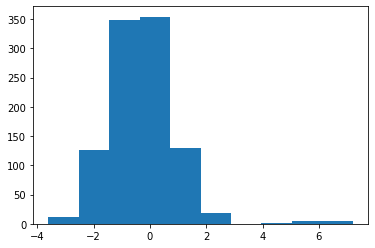

In [91]:
plt.hist(vals)

In [92]:
np.std(vals)

1.1966346738919023

In [93]:
np.mean(vals)

-0.2848902190351017

In [94]:
data["2019-02-01"]["CONTESTS"]

[{'Name': 'NBA $400K Friday Shootaround [$100K to 1st]',
  'Link': 'Contest',
  'Prize Pool': '$400,000',
  'Buy In': '$12',
  'Top Prize': '$100,000',
  'Max Entries': 150,
  'Entries': 39216,
  'Cash Line': 286.75,
  'Winner': 'marques5450',
  'Winning Score': 352.0,
  'PAYOUTS':     Rank              User  Points Entries     Prize
  0      1       marques5450  352.00       4  $100,000
  1      2          mrminwoo  351.75       3   $40,000
  2      3   F0rsaken Member  348.75      60   $20,000
  3      4   sbaugh25 Member  348.50       5    $7,500
  4      4  hanners87 Member  348.50       2    $7,500
  ..   ...               ...     ...     ...       ...
  45  8169         Anonymous  286.50     100       ---
  46  8169         Anonymous  286.50       2       ---
  47  8169         Anonymous  286.50       8       ---
  48  8169         Anonymous  286.50       1       ---
  49  8169         Anonymous  286.50     150       ---
  
  [8300 rows x 5 columns]},
 {'Name': 'NBA $100K Four Po

In [97]:
sum(payouts)

36458.00000000009

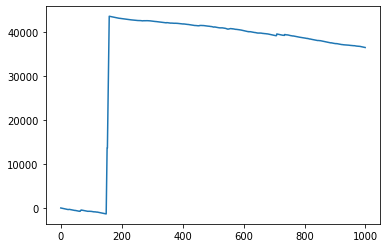

In [99]:
plt.plot(np.cumsum(payouts))

In [125]:
def get_random_lineups(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9, num_lineups=10):
    players = list(set(projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')

    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    opt_values = [np.random.randint(1000) for name in players]
    LINEUPS = []
    for i in range(num_lineups):
        #optimizing function
        prob += pulp.lpDot([choices[v] for v in players],opt_values), "Total Projection"
        prob.solve()
        prob += lpSum([choices[v] for v in players if choices[v].varValue == 1]) <=3
        #for v in prob.variables():
        #    print(v.name, "=", v.varValue)
        print("actual", (pulp.lpDot([choices[v].varValue for v in players],
                        [get_Fpts(results, name) for name in players])))
        print("results", pulp.lpDot([choices[v].varValue for v in players],[projections[name]['points'] for name in players]))
        print([choices[v] for v in players if choices[v].varValue == 1])
        for i in range(len(opt_values)):
            if choices[players[i]].varValue ==1:
                opt_values[i] /=2
        #print(opt_values)
        print("Status:", LpStatus[prob.status])#print(prob.status)
        if LpStatus[prob.status] == "Infeasible":
            break
        print(value(prob.objective))
        # The problem data is written to an .lp file
        #prob.writeLP("letsee.lp")
        #return(value(prob.objective))
        #return prob
        LINEUPS.append([player for player in players if (choices[player].varValue == 1)])
    #return(pulp.lpDot([choices[v].varValue for v in players],
    #                    [get_Fpts(results, name) for name in players])).value()
    return LINEUPS

In [126]:
get_random_lineups(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_expected_ratio=.75, optimal_variance_ratio=.75)

actual 239.5
results 265.61
[Choice_Malik_Beasley, Choice_Terrence_Ross, Choice_Torrey_Craig, Choice_KarlAnthony_Towns, Choice_John_Collins, Choice_Rudy_Gobert, Choice_Derrick_White, Choice_Rondae_HollisJefferson]
Status: Optimal
7465.0
actual 266.75
results 260.35
[Choice_Jarrett_Allen, Choice_Joel_Embiid, Choice_Shaquille_Harrison, Choice_Bobby_Portis, Choice_Larry_Nance, Choice_DeMar_DeRozan, Choice_Derrick_Favors, Choice_Kelly_Oubre]
Status: Optimal
6468.0
actual 215.5
results 249.9
[Choice_Dwight_Powell, Choice_Bogdan_Bogdanovic, Choice_Kemba_Walker, Choice_Derrick_Rose, Choice_Shaun_Livingston, Choice_Myles_Turner, Choice_Justise_Winslow, Choice_Nikola_Vucevic]
Status: Optimal
6024.0
actual 262.75
results 270.64
[Choice_Stephen_Curry, Choice_Jahlil_Okafor, Choice_Dwyane_Wade, Choice_Michael_KiddGilchrist, Choice_Bobby_Portis, Choice_Malik_Monk, Choice_Kevin_Durant, Choice_Klay_Thompson]
Status: Optimal
5427.5
actual 280.25
results 262.33000000000004
[Choice_Malik_Beasley, Choice_

[['Malik Beasley',
  'Terrence Ross',
  'Torrey Craig',
  'KarlAnthony Towns',
  'John Collins',
  'Rudy Gobert',
  'Derrick White',
  'Rondae HollisJefferson'],
 ['Jarrett Allen',
  'Joel Embiid',
  'Shaquille Harrison',
  'Bobby Portis',
  'Larry Nance',
  'DeMar DeRozan',
  'Derrick Favors',
  'Kelly Oubre'],
 ['Dwight Powell',
  'Bogdan Bogdanovic',
  'Kemba Walker',
  'Derrick Rose',
  'Shaun Livingston',
  'Myles Turner',
  'Justise Winslow',
  'Nikola Vucevic'],
 ['Stephen Curry',
  'Jahlil Okafor',
  'Dwyane Wade',
  'Michael KiddGilchrist',
  'Bobby Portis',
  'Malik Monk',
  'Kevin Durant',
  'Klay Thompson'],
 ['Malik Beasley',
  'KarlAnthony Towns',
  'Jeremy Lin',
  'Kemba Walker',
  'Bobby Portis',
  'Devin Harris',
  'Zach LaVine',
  'Josh Richardson'],
 ['Taurean Prince',
  'Kenneth Faried',
  'Willie CauleyStein',
  'Kemba Walker',
  'Corey Brewer',
  'Bobby Portis',
  'Nikola Vucevic',
  'Brook Lopez'],
 ['Jordan McRae',
  'Stephen Curry',
  'Terrence Ross',
  'Monte 

In [154]:
vals = []
payouts = []
for date in list(data.keys())[-100:]:
    projs = data[date]["PROJECTIONS"]
    #print(data[date].keys())
    results = data[date]["ACTUAL_POINTS"]
    contest = data[date]["CONTESTS"][0]
    lineups = get_random_lineups(data[date]["ACTUAL_POINTS"], data[date]["PROJECTIONS"], optimal_expected_ratio=.9, optimal_variance_ratio=.85, num_lineups=3)
    for lineup in lineups:
        sample = set(lineup)
        #sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"]-np.mean(player_data[p]["mean"]) for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append(resid)
        payout = get_payout(contest["PAYOUTS"], actual_points) - float(contest["Buy In"][1:])
        payouts.append(payout)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

actual 252.5
results 279.87
[Choice_Jabari_Parker, Choice_Devin_Booker, Choice_Tomas_Satoransky, Choice_Jamal_Murray, Choice_Kemba_Walker, Choice_Blake_Griffin, Choice_DeAndre_Bembry, Choice_Thomas_Bryant]
Status: Optimal
5659.0
actual 253.0
results 280.37
[Choice_Jabari_Parker, Choice_Troy_Brown, Choice_Stephen_Curry, Choice_Buddy_Hield, Choice_Kemba_Walker, Choice_Bobby_Portis, Choice_Domantas_Sabonis, Choice_Thomas_Bryant]
Status: Optimal
4244.0
actual 199.75
results 279.45
[Choice_Jabari_Parker, Choice_KarlAnthony_Towns, Choice_Kemba_Walker, Choice_Domantas_Sabonis, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Tony_Parker, Choice_Trey_Burke]
Status: Optimal
3548.25
2019-03-21 119 280.5764974533799 32.79862950615002 252.5 -0.8560265436735796
2019-03-21 119 282.2928738254794 31.52292640468707 253.0 -0.9292561689679892
2019-03-21 119 277.2722656811292 32.00002246848645 199.75 -2.4225691015521313
actual 257.0
results 270.43
[Choice_Jonas_Valanciunas, Choice_Mario_Hezonja, Choice_Rud

actual 296.75
results 273.17
[Choice_Jonas_Valanciunas, Choice_Timothe_LuwawuCabarrot, Choice_Devin_Booker, Choice_James_Johnson, Choice_Tyus_Jones, Choice_Anthony_Tolliver, Choice_Myles_Turner, Choice_Nikola_Vucevic]
Status: Optimal
7347.0
actual 319.75
results 271.92
[Choice_Fred_VanVleet, Choice_Jonas_Valanciunas, Choice_Bruno_Caboclo, Choice_KarlAnthony_Towns, Choice_Hassan_Whiteside, Choice_Dion_Waiters, Choice_Josh_Jackson, Choice_Myles_Turner]
Status: Optimal
5569.5
actual 328.25
results 271.11
[Choice_Jonas_Valanciunas, Choice_Timothe_LuwawuCabarrot, Choice_Devin_Booker, Choice_Bam_Adebayo, Choice_Jonathan_Isaac, Choice_Marc_Gasol, Choice_Zach_Collins, Choice_Mike_Conley]
Status: Optimal
4616.0
2019-03-30 119 270.871625612445 29.13902586452269 296.75 0.8881001893430636
2019-03-30 119 267.9974283174001 31.67299635866703 319.75 1.633965132207591
2019-03-30 119 270.35362406303756 28.933261330997826 328.25 2.001031797785437
actual 222.25
results 271.65
[Choice_Jonas_Valanciunas, Ch

actual 305.25
results 273.44
[Choice_DJ_Wilson, Choice_Lou_Williams, Choice_DeAaron_Fox, Choice_John_Collins, Choice_DeMar_DeRozan, Choice_Trey_Burke, Choice_Montrezl_Harrell, Choice_Boban_Marjanovic]
Status: Optimal
6704.0
actual 264.5
results 270.27000000000004
[Choice_Jerami_Grant, Choice_Lou_Williams, Choice_Kemba_Walker, Choice_Mitchell_Robinson, Choice_Doug_McDermott, Choice_Hassan_Whiteside, Choice_John_Collins, Choice_Georges_Niang]
Status: Optimal
4792.5
actual 299.75
results 270.14
[Choice_Taurean_Prince, Choice_Kemba_Walker, Choice_John_Collins, Choice_Georges_Niang, Choice_DeMar_DeRozan, Choice_Danilo_Gallinari, Choice_Seth_Curry, Choice_Boban_Marjanovic]
Status: Optimal
3963.0
2019-04-10 119 269.65853797279397 29.838002249986594 305.25 1.1928232235193301
2019-04-10 119 269.5453649300065 28.459999845711412 264.5 -0.17727916224028942
2019-04-10 119 266.58358460852645 28.109685320981853 299.75 1.1798928025251572
actual 290.0
results 266.11
[Choice_Fred_VanVleet, Choice_Montre

actual 217.25
results 285.49
[Choice_Stephen_Curry, Choice_Terrence_Ross, Choice_Ben_Simmons, Choice_Bogdan_Bogdanovic, Choice_DeAaron_Fox, Choice_Nerlens_Noel, Choice_Montrezl_Harrell, Choice_Kelly_Oubre]
Status: Optimal
6761.0
actual 241.5
results 276.93
[Choice_Christian_Wood, Choice_Lauri_Markkanen, Choice_Eric_Bledsoe, Choice_Ben_Simmons, Choice_James_Harden, Choice_Royce_ONeale, Choice_Nerlens_Noel, Choice_Montrezl_Harrell]
Status: Optimal
5317.0
actual 281.0
results 277.01
[Choice_Frank_Kaminsky, Choice_Jarrett_Allen, Choice_Serge_Ibaka, Choice_Ben_Simmons, Choice_James_Harden, Choice_Bogdan_Bogdanovic, Choice_Buddy_Hield, Choice_Richaun_Holmes]
Status: Optimal
4530.0
2019-10-30 119 284.9806769737182 28.686053651066416 217.25 -2.361101244443927
2019-10-30 119 281.24410812970797 31.579902563675223 241.5 -1.258525356421575
2019-10-30 119 278.7638020801673 30.14109394475032 281.0 0.0741910006296299
actual 233.5
results 254.67
[Choice_Brandon_Ingram, Choice_Bam_Adebayo, Choice_DeMar

actual 254.75
results 270.98
[Choice_Ben_Simmons, Choice_Bruno_Caboclo, Choice_James_Harden, Choice_Kevin_Love, Choice_Jordan_Clarkson, Choice_James_Ennis, Choice_Rudy_Gobert, Choice_Joe_Ingles]
Status: Optimal
7151.0
actual 275.0
results 272.54
[Choice_Bojan_Bogdanovic, Choice_PJ_Tucker, Choice_Ben_Simmons, Choice_James_Harden, Choice_Cameron_Johnson, Choice_Doug_McDermott, Choice_Royce_ONeale, Choice_Domantas_Sabonis]
Status: Optimal
5590.5
actual 264.75
results 272.81000000000006
[Choice_TJ_McConnell, Choice_Frank_Kaminsky, Choice_RJ_Barrett, Choice_James_Harden, Choice_Jaren_Jackson, Choice_Domantas_Sabonis, Choice_Georges_Niang, Choice_Rudy_Gobert]
Status: Optimal
4872.0
2019-12-07 119 267.35936641963804 30.287280366647725 254.75 -0.41632547614025583
2019-12-07 119 272.8949817582269 26.848178049907272 275.0 0.07840450990231643
2019-12-07 119 266.3976789462348 28.991532975365228 264.75 -0.056833108743676156
actual 252.5
results 256.46999999999997
[Choice_Mario_Hezonja, Choice_Paul_

actual 268.5
results 296.38
[Choice_Christian_Wood, Choice_Jimmy_Butler, Choice_Thon_Maker, Choice_Kyle_Lowry, Choice_Kristaps_Porzingis, Choice_Brook_Lopez, Choice_Markieff_Morris, Choice_Pascal_Siakam]
Status: Optimal
6635.0
actual 294.75
results 292.4
[Choice_Christian_Wood, Choice_Bam_Adebayo, Choice_Thon_Maker, Choice_Derrick_Rose, Choice_Hassan_Whiteside, Choice_Giannis_Antetokounmpo, Choice_Ben_McLemore, Choice_Derrick_Jones]
Status: Optimal
5352.5
actual 274.0
results 290.68000000000006
[Choice_Dwight_Powell, Choice_Damian_Lillard, Choice_James_Harden, Choice_Thon_Maker, Choice_Derrick_Rose, Choice_Tristan_Thompson, Choice_Carmelo_Anthony, Choice_Markieff_Morris]
Status: Optimal
4449.5
2019-12-16 119 296.31324887011334 30.798796683188588 268.5 -0.9030628422341936
2019-12-16 119 296.2179048859253 30.45800190831641 294.75 -0.04819439207942556
2019-12-16 119 290.6018207233982 29.12224869177389 274.0 -0.5700734479369952
actual 267.5
results 268.13
[Choice_Taurean_Prince, Choice_Jev

actual 250.75
results 259.42
[Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Rudy_Gay, Choice_DeAndre_Jordan, Choice_Gorgui_Dieng, Choice_Shabazz_Napier, Choice_Luka_Doncic, Choice_Nerlens_Noel]
Status: Optimal
7122.0
actual 204.5
results 255.48000000000005
[Choice_Andre_Drummond, Choice_Taurean_Prince, Choice_Gorgui_Dieng, Choice_Brandon_Clarke, Choice_Hassan_Whiteside, Choice_Bryn_Forbes, Choice_Kristaps_Porzingis, Choice_Svi_Mykhailiuk]
Status: Optimal
6030.0
actual 206.0
results 255.55999999999997
[Choice_Andre_Drummond, Choice_Jarrett_Allen, Choice_Timothe_LuwawuCabarrot, Choice_Tony_Snell, Choice_Gorgui_Dieng, Choice_Kent_Bazemore, Choice_Nemanja_Bjelica, Choice_Luka_Doncic]
Status: Optimal
4910.5
2019-12-26 119 261.2659731527659 31.33835222165452 250.75 -0.3355624149727783
2019-12-26 119 252.90457347429637 29.511728369655955 204.5 -1.6401809093657183
2019-12-26 119 254.77599761136193 29.177873038674658 206.0 -1.671677628684941
actual 223.25
results 272.51
[Choice_Draymo

actual 274.25
results 265.58000000000004
[Choice_Andre_Drummond, Choice_Christian_Wood, Choice_Dennis_Schroder, Choice_LaMarcus_Aldridge, Choice_Michael_Porter, Choice_Alex_Len, Choice_Gordon_Hayward, Choice_Ish_Smith]
Status: Optimal
6584.0
actual 253.25
results 264.09
[Choice_Andre_Drummond, Choice_Alfonzo_McKinnie, Choice_Buddy_Hield, Choice_Michael_Porter, Choice_Brandon_Ingram, Choice_Patty_Mills, Choice_Zach_LaVine, Choice_Joe_Ingles]
Status: Optimal
4896.0
actual 250.75
results 267.16
[Choice_Andre_Drummond, Choice_Shai_GilgeousAlexander, Choice_Michael_Porter, Choice_Alex_Len, Choice_Royce_ONeale, Choice_Trae_Young, Choice_Cody_Zeller, Choice_Joe_Ingles]
Status: Optimal
4167.0
2020-01-04 119 267.1416168013744 32.82251592921402 274.25 0.21657033281530635
2020-01-04 119 267.78021906585343 29.194275165132925 253.25 -0.49770782058007884
2020-01-04 119 269.44890249190985 30.994449849707536 250.75 -0.603298415767373
actual 317.5
results 282.78000000000003
[Choice_Christian_Wood, Choi

actual 236.0
results 265.08
[Choice_Austin_Rivers, Choice_Kyle_Anderson, Choice_Kawhi_Leonard, Choice_Brandon_Clarke, Choice_Alec_Burks, Choice_Tim_Hardaway, Choice_Giannis_Antetokounmpo, Choice_Omari_Spellman]
Status: Optimal
6678.0
actual 224.5
results 263.96
[Choice_Donovan_Mitchell, Choice_Eric_Bledsoe, Choice_Kyle_Anderson, Choice_Dario_Saric, Choice_Lou_Williams, Choice_Jaren_Jackson, Choice_Trae_Young, Choice_DeAnthony_Melton]
Status: Optimal
5209.5
actual 278.0
results 264.39
[Choice_Julius_Randle, Choice_Darius_Garland, Choice_Devin_Booker, Choice_Dorian_FinneySmith, Choice_Larry_Nance, Choice_Collin_Sexton, Choice_Trae_Young, Choice_Donte_DiVincenzo]
Status: Optimal
4731.5
2020-01-14 119 260.8361830981417 28.5300835154349 236.0 -0.8705261267358443
2020-01-14 119 258.3080372128433 30.70366005739763 224.5 -1.101107722976425
2020-01-14 119 269.65879994613897 29.427343423959343 278.0 0.283450664699476
actual 263.5
results 281.2
[Choice_Jaylen_Brown, Choice_Damian_Lillard, Choice_

actual 248.5
results 275.17
[Choice_KarlAnthony_Towns, Choice_Kemba_Walker, Choice_Jaren_Jackson, Choice_Nerlens_Noel, Choice_Tyler_Herro, Choice_Tim_Frazier, Choice_Markieff_Morris, Choice_Will_Barton]
Status: Optimal
6848.0
actual 304.5
results 275.51
[Choice_Julius_Randle, Choice_DAngelo_Russell, Choice_Patty_Mills, Choice_Mike_Muscala, Choice_Russell_Westbrook, Choice_Nerlens_Noel, Choice_Gordon_Hayward, Choice_Tyler_Herro]
Status: Optimal
5205.0
actual 210.5
results 281.07
[Choice_Damion_Lee, Choice_Fred_VanVleet, Choice_Christian_Wood, Choice_James_Harden, Choice_Bogdan_Bogdanovic, Choice_Derrick_Rose, Choice_Langston_Galloway, Choice_Tyler_Herro]
Status: Optimal
4607.25
2020-01-24 119 268.07292580833746 30.90004244039993 248.5 -0.6334271496904822
2020-01-24 119 273.04853879356796 29.080335391641764 304.5 1.08153708624254
2020-01-24 119 285.051704278516 31.364269678146673 210.5 -2.376962863906905
actual 208.5
results 262.12
[Choice_Steven_Adams, Choice_Shai_GilgeousAlexander, Cho

actual 288.75
results 268.44
[Choice_Chris_Boucher, Choice_Devin_Booker, Choice_Terence_Davis, Choice_Danuel_House, Choice_James_Harden, Choice_Zach_LaVine, Choice_Jrue_Holiday, Choice_Tyler_Johnson]
Status: Optimal
6168.0
actual 275.0
results 268.62
[Choice_Deandre_Ayton, Choice_Devin_Booker, Choice_Eric_Gordon, Choice_Mikal_Bridges, Choice_James_Harden, Choice_Kelly_Oubre, Choice_Elie_Okobo, Choice_Cheick_Diallo]
Status: Optimal
4852.0
actual 271.0
results 269.87
[Choice_Chris_Boucher, Choice_Fred_VanVleet, Choice_Devin_Booker, Choice_Ben_McLemore, Choice_Robin_Lopez, Choice_James_Harden, Choice_Russell_Westbrook, Choice_Elie_Okobo]
Status: Optimal
3653.0
2020-02-02 119 273.24644910002263 31.126268757861784 288.75 0.498085749390104
2020-02-02 119 267.0231127431236 30.013000964198834 275.0 0.26578106156034453
2020-02-02 119 270.65724299631165 29.885234565699776 271.0 0.011469108697635623
actual 279.0
results 277.14
[Choice_Jeff_Teague, Choice_Harrison_Barnes, Choice_Bradley_Beal, Choi

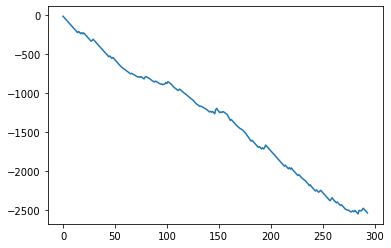

In [155]:
plt.plot(np.cumsum(payouts))

(array([ 2.,  7., 17., 47., 57., 59., 41., 38., 19.,  7.]),
 array([-3.15624805, -2.61194523, -2.06764241, -1.52333959, -0.97903677,
        -0.43473395,  0.10956887,  0.65387169,  1.19817451,  1.74247733,
         2.28678015]),
 <a list of 10 Patch objects>)

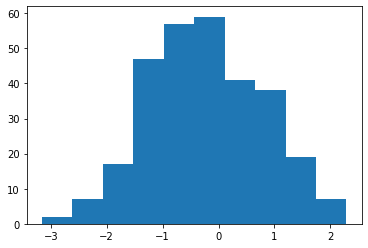

In [156]:
plt.hist(vals)

In [157]:
np.std(vals)

1.01341922168534

In [158]:
stats.skew(vals)

0.028681454686355877

In [159]:
np.mean(vals)

-0.22378569747928773

In [12]:
data['2017-11-01']['ACTUAL_POINTS']

Player Pos     Avg   Fpts  \
0             John Wall  PG  37.44%  42.75   
1           Jason Smith  PF  34.55%  10.00   
2           Joel Embiid   C  26.33%  58.00   
3      Domantas Sabonis  PF  26.22%  41.00   
4          LeBron James  SF  24.90%  61.00   
..                  ...  ..     ...    ...   
395          Tyus Jones  PG   0.00%  11.75   
396        Cole Aldrich   C   0.00%    NaN   
397       Justin Patton   C   0.00%    NaN   
398        Aaron Brooks  PG   0.00%    NaN   
399  Marcus GeorgesHunt  SG   0.00%    NaN   

    NBA $525K Wednesday Starting 5 Special NBA $60K Excellent 8_s  \
0                          25.16% (-12.28)         34.30% (-3.14)   
1                          17.71% (-16.84)         29.20% (-5.35)   
2                           17.33% (-9.00)         20.48% (-5.85)   
3                            29.76% (3.54)         21.29% (-4.93)   
4                           20.97% (-3.93)          25.41% (0.51)   
..                                     ...                    ...   
395                           0.00% (0.00)           0.00% (0.00)   
396                           0.00% (0.00)           0.00% (0.00)   
397                           0.00% (0.00)           0.00% (0.00)   
398                           0.00% (0.00)           0.00% (0.00)   
399                           0.00% (0.00)           0.00% (0.00)   

    NBA $250K Triple Threat [$25K to 1st] NBA $75K Fall Festival 3 Max Encore  \
0                          35.00% (-2.44)                      31.89% (-5.55)   
1                          28.23% (-6.32)                      28.47% (-6.08)   
2                          21.33% (-5.00)                      26.13% (-0.20)   
3                          21.69% (-4.53)                       33.33% (7.11)   
4                           26.81% (1.91)                      23.96% (-0.94)   
..                                    ...                                 ...   
395                          0.00% (0.00)                        0.00% (0.00)   
396                          0.00% (0.00)                        0.00% (0.00)   
397                          0.00% (0.00)                        0.00% (0.00)   
398                          0.00% (0.00)                        0.00% (0.00)   
399                          0.00% (0.00)                        0.00% (0.00)   

    NBA $600K MEGA Alley Oop [$100K to 1st] NBA GIANT $25 Double Up  
0                             38.63% (1.19)          59.66% (22.22)  
1                             34.72% (0.17)          68.97% (34.42)  
2                            25.23% (-1.10)          47.48% (21.15)  
3                            19.32% (-6.90)           31.94% (5.72)  
4                             29.31% (4.41)          22.93% (-1.97)  
..                                      ...                     ...  
395                            0.00% (0.00)            0.00% (0.00)  
396                            0.00% (0.00)            0.00% (0.00)  
397                            0.00% (0.00)            0.00% (0.00)  
398                            0.00% (0.00)            0.00% (0.00)  
399                            0.00% (0.00)            0.00% (0.00)  

[400 rows x 10 columns]

# Can we improve player predictions

In [87]:
#returns predicted/actual pair
get_pairs("LeBron James")[68:]

[(51.51, 18.7, 65.68, 43.75),
 (54.4, 23.5, 77.9, 67.0),
 (58.62, 25.91, 88.52, 50.75),
 (54.71, 25.06, 78.89, 68.25),
 (53.41, 19.28, 81.24, 59.25),
 (52.85, 19.18, 77.85, 62.0),
 (53.96, 18.4, 77.54, 49.75),
 (53.89, 23.44, 79.81, 47.75),
 (52.31, 21.13, 75.17, 31.0),
 (53.83, 18.63, 76.76, 55.5),
 (53.62, 21.29, 80.54, 38.75),
 (54.69, 22.97, 77.88, 44.25),
 (55.77, 23.42, 79.42, 80.0),
 (52.63, 20.89, 79.1, 39.5),
 (53.03, 21.05, 79.65, 73.5),
 (52.63, 20.89, 79.1, 62.5),
 (52.99, 22.26, 75.46, 51.0),
 (50.74, 20.04, 76.62, 31.75),
 (51.07, 21.4, 61.9, 62.75),
 (53.51, 22.47, 64.75, 41.25),
 (51.7, 21.71, 62.56, 61.75),
 (51.88, 20.6, 66.25, 68.0),
 (50.37, 20.0, 64.37, 45.0),
 (54.31, 22.81, 65.72, 61.75),
 (53.56, 21.26, 68.45, 45.25),
 (53.23, 21.13, 67.97, 61.5),
 (53.64, 21.3, 68.5, 25.0),
 (53.38, 21.19, 68.22, 68.25),
 (52.45, 22.03, 63.46, 54.5),
 (50.97, 20.24, 65.09, 43.25),
 (50.75, 50.75, 50.75, 57.0),
 (49.76, 28.46, 75.29, 40.25),
 (47.75, 27.31, 72.25, 72.5),
 (54.24

r value is (0.31588557625325187, 0.0007320239665508607)


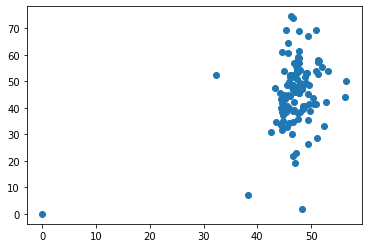

In [626]:
#case study LeBron James
case = get_pairs("Stephen Curry")#[68:]
plt.scatter(np.array(case)[:,0], np.array(case)[:,3])
print("r value is {}".format(stats.pearsonr(np.array(case)[:,0], np.array(case)[:,1])))

In [627]:
est = sm.OLS(np.array(case)[:,3], sm.add_constant(np.array(case)[:,0])).fit()
est.rsquared

0.1368908375733413

In [161]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     11.23
Date:                Sun, 08 Mar 2020   Prob (F-statistic):            0.00108
Time:                        12:30:27   Log-Likelihood:                -457.35
No. Observations:                 120   AIC:                             918.7
Df Residuals:                     118   BIC:                             924.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3646      7.883      0.807      0.421      -9.245      21.974
x1             0.8161      0.244      3.351      0.001       0.334       1.298
==============================================================================
Omnibus:                        0.207   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.229
Skew:                           0.096   Prob(JB):                        0.892
Kurtosis:                       2.905   Cond. No.                         254.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [478]:
#lets try exponential smoothing
usual_deviation = 0
#get_pairs("LeBron James")
vals = np.array(get_pairs("LeBron James"))
exp_projs = []
for elt in vals:
    projection = usual_deviation + elt[0]
    exp_projs.append(projection)
    deviation = elt[3] - projection
    usual_deviation = usual_deviation+deviation*.1

In [479]:
est = sm.OLS(np.array(vals)[:,3], sm.add_constant(np.array(exp_projs))).fit()
est.rsquared

0.04471850730222826

In [84]:
len(np.array(vals)[:,3])

165

In [83]:
len((exp_projs))

165

In [93]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

In [165]:
x = get_residuals("LeBron James")

In [639]:
def one_sided_kurtosis(dist):
    m = dist.mean()
    dev = dist.std()
    dist = [elt for elt in dist if elt>m]
    return sum(((dist-m)/dev)**4)/len(dist) - 3

In [642]:
skews = []
kurtosiss = []
for player in PLAYERS:
    x = np.array(get_residuals(player))
    if len(x) > 20:
        skews.append(skew(x))
        kurtosiss.append(one_sided_kurtosis(x))
        print( '{} excess kurtosis of normal distribution (should be 0): {}'.format(player,  one_sided_kurtosis(x) ))
        print( '{} skewness of normal distribution (should be 0): {}'.format(player, skew(x) ))
from scipy.stats import kurtosis, skew


Paul George excess kurtosis of normal distribution (should be 0): 4.456089960214008
Paul George skewness of normal distribution (should be 0): 0.7987190604654077
Will Barton excess kurtosis of normal distribution (should be 0): 0.8352893878479457
Will Barton skewness of normal distribution (should be 0): 0.2823931149379983
DJ Augustin excess kurtosis of normal distribution (should be 0): 0.8363119786536131
DJ Augustin skewness of normal distribution (should be 0): 0.21518406775556156
Kendrick Nunn excess kurtosis of normal distribution (should be 0): 1.2820362537565773
Kendrick Nunn skewness of normal distribution (should be 0): 0.20199708362420393
Trevor Ariza excess kurtosis of normal distribution (should be 0): 1.1320118880264607
Trevor Ariza skewness of normal distribution (should be 0): 0.2561623207847696
Isaiah Hartenstein excess kurtosis of normal distribution (should be 0): -1.064942919033767
Isaiah Hartenstein skewness of normal distribution (should be 0): -0.6566721902292745


Harrison Barnes excess kurtosis of normal distribution (should be 0): 2.203027555054933
Harrison Barnes skewness of normal distribution (should be 0): 0.5218562910914242
Ersan Ilyasova excess kurtosis of normal distribution (should be 0): -0.31357169961207276
Ersan Ilyasova skewness of normal distribution (should be 0): 0.03742352571112312
Ekpe Udoh excess kurtosis of normal distribution (should be 0): -2.277000284763793
Ekpe Udoh skewness of normal distribution (should be 0): -1.0293245125184232
Hamidou Diallo excess kurtosis of normal distribution (should be 0): -1.5438612915124161
Hamidou Diallo skewness of normal distribution (should be 0): -0.4805559558911311
Darius Bazley excess kurtosis of normal distribution (should be 0): -1.4635435932812915
Darius Bazley skewness of normal distribution (should be 0): -0.337798407468022
Malachi Richardson excess kurtosis of normal distribution (should be 0): -1.9451249393438177
Malachi Richardson skewness of normal distribution (should be 0): 

Tyus Jones excess kurtosis of normal distribution (should be 0): 1.7821104599932625
Tyus Jones skewness of normal distribution (should be 0): 0.1946143252086076
Nicolas Batum excess kurtosis of normal distribution (should be 0): 0.5968817663756183
Nicolas Batum skewness of normal distribution (should be 0): 0.3088891539680789
Michael CarterWilliams excess kurtosis of normal distribution (should be 0): -0.315380524617602
Michael CarterWilliams skewness of normal distribution (should be 0): -0.04862409419581409
Bradley Beal excess kurtosis of normal distribution (should be 0): 3.9949802021907823
Bradley Beal skewness of normal distribution (should be 0): 0.7887649008403
Tyler Herro excess kurtosis of normal distribution (should be 0): -0.06381690834586617
Tyler Herro skewness of normal distribution (should be 0): 0.24879846141041498
Josh Okogie excess kurtosis of normal distribution (should be 0): -1.076537047504417
Josh Okogie skewness of normal distribution (should be 0): -0.1668887409

Terrence Ross excess kurtosis of normal distribution (should be 0): 0.6323486069980371
Terrence Ross skewness of normal distribution (should be 0): 0.2826567442129758
Georges Niang excess kurtosis of normal distribution (should be 0): -0.20192650010036095
Georges Niang skewness of normal distribution (should be 0): -0.1309030992875558
Marco Belinelli excess kurtosis of normal distribution (should be 0): 0.4436199623978401
Marco Belinelli skewness of normal distribution (should be 0): 0.20872053248051609
Domantas Sabonis excess kurtosis of normal distribution (should be 0): 4.876092491576194
Domantas Sabonis skewness of normal distribution (should be 0): 0.8737433008207913
Rodney Hood excess kurtosis of normal distribution (should be 0): -0.002816703058668768
Rodney Hood skewness of normal distribution (should be 0): -0.04770007727158078
Pascal Siakam excess kurtosis of normal distribution (should be 0): 3.42508178355917
Pascal Siakam skewness of normal distribution (should be 0): 0.646

Mohamed Bamba excess kurtosis of normal distribution (should be 0): -1.302715783461613
Mohamed Bamba skewness of normal distribution (should be 0): -0.11839122633972646
Jacob Evans excess kurtosis of normal distribution (should be 0): -0.13318627325689825
Jacob Evans skewness of normal distribution (should be 0): -0.20190706317013896
Cody Zeller excess kurtosis of normal distribution (should be 0): 1.9923960318987755
Cody Zeller skewness of normal distribution (should be 0): 0.3044601917600747
Andre Iguodala excess kurtosis of normal distribution (should be 0): 1.194580544613311
Andre Iguodala skewness of normal distribution (should be 0): 0.2706447009054623
Robert Covington excess kurtosis of normal distribution (should be 0): 2.087239685835029
Robert Covington skewness of normal distribution (should be 0): 0.5954201927133914
DeAaron Fox excess kurtosis of normal distribution (should be 0): 2.9023270157445777
DeAaron Fox skewness of normal distribution (should be 0): 0.606763925792438

Brook Lopez excess kurtosis of normal distribution (should be 0): 1.0625848396241544
Brook Lopez skewness of normal distribution (should be 0): 0.3115461765104442
Courtney Lee excess kurtosis of normal distribution (should be 0): 0.4079735107581839
Courtney Lee skewness of normal distribution (should be 0): 0.2033083118473416
Lucas Nogueira excess kurtosis of normal distribution (should be 0): -2.435643873975769
Lucas Nogueira skewness of normal distribution (should be 0): -1.184099487320883
Patty Mills excess kurtosis of normal distribution (should be 0): 0.5178167343578397
Patty Mills skewness of normal distribution (should be 0): 0.10843872820516455
JaMychal Green excess kurtosis of normal distribution (should be 0): -0.3333666266204842
JaMychal Green skewness of normal distribution (should be 0): -0.0008475843628886191
Keita BatesDiop excess kurtosis of normal distribution (should be 0): -1.2651677382192974
Keita BatesDiop skewness of normal distribution (should be 0): -0.460016042

John Jenkins excess kurtosis of normal distribution (should be 0): -0.19089197941238956
John Jenkins skewness of normal distribution (should be 0): 0.053856632137207
Jason Terry excess kurtosis of normal distribution (should be 0): -1.2257163204482036
Jason Terry skewness of normal distribution (should be 0): -0.27265309464975535
Wayne Ellington excess kurtosis of normal distribution (should be 0): -0.49420147409973714
Wayne Ellington skewness of normal distribution (should be 0): -0.052838915494059065
Tyler Zeller excess kurtosis of normal distribution (should be 0): -0.6136116100975366
Tyler Zeller skewness of normal distribution (should be 0): 0.05189351170914175
Jonathan Isaac excess kurtosis of normal distribution (should be 0): 1.6802788559045956
Jonathan Isaac skewness of normal distribution (should be 0): 0.39362122867934957
Monte Morris excess kurtosis of normal distribution (should be 0): -0.8237174675818557
Monte Morris skewness of normal distribution (should be 0): -0.18919

Russell Westbrook excess kurtosis of normal distribution (should be 0): 9.879764026756591
Russell Westbrook skewness of normal distribution (should be 0): 1.4938774304943918
Reggie Bullock excess kurtosis of normal distribution (should be 0): 0.7286537205262462
Reggie Bullock skewness of normal distribution (should be 0): 0.3542109707075997
Kyrie Irving excess kurtosis of normal distribution (should be 0): 4.687652491904563
Kyrie Irving skewness of normal distribution (should be 0): 0.9365556478985306
Alex Len excess kurtosis of normal distribution (should be 0): -1.2732793779005556
Alex Len skewness of normal distribution (should be 0): -0.3167530122982159
Khem Birch excess kurtosis of normal distribution (should be 0): -1.1962869435103487
Khem Birch skewness of normal distribution (should be 0): -0.5185276522858171
Vince Carter excess kurtosis of normal distribution (should be 0): -1.2899916477977593
Vince Carter skewness of normal distribution (should be 0): -0.4219146984067615
Laur

Aaron Gordon excess kurtosis of normal distribution (should be 0): 2.544342434462317
Aaron Gordon skewness of normal distribution (should be 0): 0.36116944792215855
Thaddeus Young excess kurtosis of normal distribution (should be 0): 1.8942012297941533
Thaddeus Young skewness of normal distribution (should be 0): 0.34302269312160344
Shelvin Mack excess kurtosis of normal distribution (should be 0): -0.6609047321768893
Shelvin Mack skewness of normal distribution (should be 0): -0.20805980774187147
Jarrett Allen excess kurtosis of normal distribution (should be 0): 1.1764233354853681
Jarrett Allen skewness of normal distribution (should be 0): 0.30501365528782043
Brandon Paul excess kurtosis of normal distribution (should be 0): -2.07155853082181
Brandon Paul skewness of normal distribution (should be 0): -1.0198504402719184
Mike James excess kurtosis of normal distribution (should be 0): 0.8067194953300318
Mike James skewness of normal distribution (should be 0): -0.11677083839088594
R

Lonzo Ball excess kurtosis of normal distribution (should be 0): 2.032750966729158
Lonzo Ball skewness of normal distribution (should be 0): 0.46465268940757437
Richaun Holmes excess kurtosis of normal distribution (should be 0): 0.2525410512514328
Richaun Holmes skewness of normal distribution (should be 0): -0.10139443456402725
Jason Smith excess kurtosis of normal distribution (should be 0): -0.7705254309669027
Jason Smith skewness of normal distribution (should be 0): -0.00874355533549562
Cameron Payne excess kurtosis of normal distribution (should be 0): 0.26426983402083914
Cameron Payne skewness of normal distribution (should be 0): 0.16055523294471047
Thomas Bryant excess kurtosis of normal distribution (should be 0): 0.6743737090932402
Thomas Bryant skewness of normal distribution (should be 0): -0.04124068182002204
Joe Harris excess kurtosis of normal distribution (should be 0): 1.097301626165189
Joe Harris skewness of normal distribution (should be 0): 0.45731548057835886
Jab

LaMarcus Aldridge excess kurtosis of normal distribution (should be 0): 2.152938953411505
LaMarcus Aldridge skewness of normal distribution (should be 0): 0.504583568941211
Willie CauleyStein excess kurtosis of normal distribution (should be 0): 2.008693594178668
Willie CauleyStein skewness of normal distribution (should be 0): 0.5102039422169655
Deandre Ayton excess kurtosis of normal distribution (should be 0): 2.737266044254377
Deandre Ayton skewness of normal distribution (should be 0): 0.5863792854441007
Kelly Olynyk excess kurtosis of normal distribution (should be 0): -0.33972556551771715
Kelly Olynyk skewness of normal distribution (should be 0): -0.014420873801589719
Dante Cunningham excess kurtosis of normal distribution (should be 0): -1.4279374957663191
Dante Cunningham skewness of normal distribution (should be 0): -0.6609427102959607
Emmanuel Mudiay excess kurtosis of normal distribution (should be 0): -0.09147931837100565
Emmanuel Mudiay skewness of normal distribution (

(array([2.00, 2.00, 6.00, 28.00, 65.00, 152.00, 147.00, 85.00, 33.00, 7.00]),
 array([-2.45, -2.06, -1.66, -1.27, -0.87, -0.48, -0.09, 0.31, 0.70, 1.10,
        1.49]),
 <a list of 10 Patch objects>)

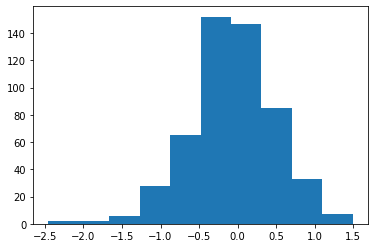

In [645]:
plt.hist(skews)

In [646]:
np.mean(skews)

-0.0683747087350445

(array([81.00, 197.00, 105.00, 71.00, 34.00, 20.00, 9.00, 4.00, 5.00, 1.00]),
 array([-2.69, -1.44, -0.18, 1.08, 2.34, 3.59, 4.85, 6.11, 7.37, 8.62,
        9.88]),
 <a list of 10 Patch objects>)

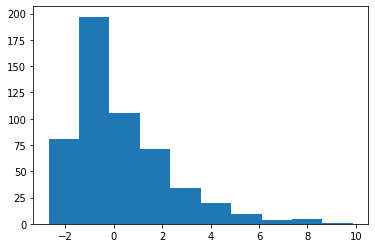

In [648]:
plt.hist(kurtosiss)

In [316]:
def one_sided_prupes(dist, val):
    m = dist.mean()
    dev = dist.std()
    dist = [elt for elt in dist if elt>m]
    return sum(((dist-m)/dev)**val)/len(dist) - 3

In [317]:
def generate_prupes_dict(val):
    output = {}
    for player in PLAYERS:
        x = np.array(get_residuals(player))
        if len(x) > 25:
            output[player]= one_sided_prupes(x[-5:], val)
        else:
            output[player] = 0
    return output

In [318]:
PLAYERS_KURTOSIS = generate_prupes_dict(4)

In [319]:
PLAYERS_PRUPES = generate_prupes_dict(2)

In [320]:
PLAYERS_PRUPES

{'Paul George': -1.4312413990735104,
 'Yante Maten': 0,
 'Ray Spalding': 0,
 'Will Barton': -0.07904700806717369,
 'DJ Augustin': -1.53512078103473,
 'Kendrick Nunn': -1.700388520604902,
 'Trevor Ariza': -2.595357789369195,
 'Scott Machado': 0,
 'Charles Cooke': 0,
 'Isaiah Hartenstein': -1.3469378917949804,
 'Darrun Hilliard': 0,
 'Nicolas Brussino': 0,
 'Tyrone Wallace': -2.3455430600042164,
 'DJ Wilson': -2.306234205065398,
 'Blake Griffin': -1.372520117276005,
 'Ike Anigbogu': 0,
 'Rayjon Tucker': 0,
 'Mirza Teletovic': 0,
 'Isaiah Canaan': -2.3782271368927055,
 'Vander Blue': 0,
 'Malik Beasley': -1.567104640139814,
 'Ian Mahinmi': -2.2897148200093502,
 'Marko Guduric': 0,
 'Gary Payton': -2.512423722784241,
 'Willie Reed': -1.4541383888176185,
 'Dennis Schroder': -1.3535107820340913,
 'Wilson Chandler': -1.648930015938381,
 'Jakob Poeltl': -2.497504511791387,
 'Thon Maker': -2.6576259327732448,
 'Jaron Blossomgame': -1.5265824281283467,
 'CJ McCollum': -2.3624920409265373,
 'Milt

In [225]:
one_sided_kurtosis(s)

In [224]:
s = np.random.normal(0, 1, 10000000)

In [215]:
m = s.mean()

In [216]:
dev = s.std()

In [217]:
s = [elt for elt in s if elt>m]

In [313]:
sum(((s-m)/dev)**2)/len(s)

1.0003837299580387

In [248]:
def base(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    return prob, choices

In [324]:
def max_kurtosis_lineup(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    prob, choices = base(results, projections)
    
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[PLAYERS_PRUPES[name] for name in players]), "Total Projection"
    prob.solve()
    #print(players)
    print(LpStatus[prob.status])
    print(pulp.lpDot([choices[v].varValue for v in players],
                    [projections[name]['points'] for name in players]))
    print([player for player in players if (choices[player].varValue == 1)])
    return choices

In [325]:
def max_kurtosis_actual(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    choices = max_kurtosis_lineup(results, projections,optimal_variance_ratio=.9, optimal_expected_ratio=.9)
    #print([player for player in players if (choices[player].varValue == 1)])
    return(pulp.lpDot([choices[v].varValue for v in choices],
                [get_Fpts(results, name) for name in players])).value()

In [326]:
def get_points(choices):
    return(pulp.lpDot([choices[v].varValue for v in choices],
                    [get_Fpts(results, name) for name in players])).value()

In [331]:
for date in list(data.keys())[-50:]:
    results = data[date]['ACTUAL_POINTS']
    projections = data[date]['PROJECTIONS']
    #choices = max_kurtosis_lineup(results, projections, optimal_expected_ratio=.9)
    points = max_kurtosis_actual(results, projections, optimal_expected_ratio=.98)
    print("actual points: ", points)
    payout = get_payout(data[date]["CONTESTS"][0]['PAYOUTS'], points)
    print(payout)
    #break

Optimal
244.28
['Skal Labissiere', 'Marvin Bagley', 'Nikola Jokic', 'Josh Hart', 'Steven Adams', 'Andre Drummond', 'Alec Burks', 'Bruce Brown']
actual points:  262.5
0
Optimal
254.68
['Skal Labissiere', 'Marvin Bagley', 'Austin Rivers', 'Troy Brown', 'Khris Middleton', 'Giannis Antetokounmpo', 'Andre Drummond', 'Bruce Brown']
actual points:  274.5
0
Optimal
251.29
['Will Barton', 'Khris Middleton', 'Jerami Grant', 'Donte DiVincenzo', 'Steven Adams', 'Romeo Langford', 'Giannis Antetokounmpo', 'Jayson Tatum']
actual points:  306.0
25.0
Optimal
273.35
['Marvin Bagley', 'Austin Rivers', 'Troy Brown', 'Admiral Schofield', 'Nikola Jokic', 'Nikola Vucevic', 'Andre Drummond', 'Alec Burks']
actual points:  281.75
0
Optimal
228.93
['Will Barton', 'Austin Rivers', 'JJ Redick', 'Jerami Grant', 'Nikola Jokic', 'Josh Hart', 'Jayson Tatum', 'Kemba Walker']
actual points:  218.75
0
Optimal
238.44
['Skal Labissiere', 'Marvin Bagley', 'Troy Brown', 'Emmanuel Mudiay', 'Steven Adams', 'Bradley Beal', 'And

Optimal
243.92000000000002
['Austin Rivers', 'Evan Fournier', 'Eric Bledsoe', 'Zion Williamson', 'Josh Hart', 'Donte DiVincenzo', 'Shake Milton', 'Giannis Antetokounmpo']
actual points:  245.0
0
Optimal
277.83000000000004
['Austin Rivers', 'Troy Brown', 'Rui Hachimura', 'Danilo Gallinari', 'James Harden', 'Steven Adams', 'Bruce Brown', 'Jayson Tatum']
actual points:  263.5
0
Optimal
276.34
['Torrey Craig', 'KarlAnthony Towns', 'Christian Wood', 'Ky Bowman', 'Nikola Jokic', 'Josh Hart', 'PJ Washington', 'Bruce Brown']
actual points:  252.75
0
Optimal
254.89
['Austin Rivers', 'Troy Brown', 'Rui Hachimura', 'Bojan Bogdanovic', 'Joel Embiid', 'Donovan Mitchell', 'Andre Drummond', 'Alec Burks']
actual points:  222.0
0


In [322]:
def actual_max(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[get_Fpts(results, name) for name in players]), "Total Projection"
    prob.solve()
    kurtosis_sum =  pulp.lpDot([choices[v].varValue for v in players],
                    [PLAYERS_PRUPES[name] for name in players])
    print("kurtosis sum is ", kurtosis_sum)
    print("optimal lineup is ", [player for player in players if (choices[player].varValue == 1)])
    
    return(value(prob.objective))

In [323]:
for date in list(data.keys())[-15:]:
    results = data[date]['ACTUAL_POINTS']
    projections = data[date]['PROJECTIONS']
    #choices = max_kurtosis_lineup(results, projections, optimal_expected_ratio=.9)
    print("actual max points: ",actual_max(results, projections))
    #break

kurtosis sum is  -12.732762591738235
optimal lineup is  ['Bruno Fernando', 'Domantas Sabonis', 'Damian Lillard', 'Trae Young', 'Jeremy Lamb', 'Kyle Anderson', 'Michael CarterWilliams', 'Deandre Ayton']
actual max points:  410.5
kurtosis sum is  -15.525762285915995
optimal lineup is  ['Dennis Schroder', 'Jakob Poeltl', 'Danuel House', 'Eric Gordon', 'Bam Adebayo', 'Nemanja Bjelica', 'Buddy Hield', 'Andrew Wiggins']
actual max points:  429.0
kurtosis sum is  -9.500380613527637
optimal lineup is  ['Khris Middleton', 'Eric Bledsoe', 'Draymond Green', 'Serge Ibaka', 'Larry Nance', 'Thomas Bryant', 'Bradley Beal', 'DAngelo Russell']
actual max points:  427.25
kurtosis sum is  -15.399751305772826
optimal lineup is  ['Bogdan Bogdanovic', 'Damian Lillard', 'Reggie Jackson', 'Chandler Hutchison', 'Russell Westbrook', 'Taurean Prince', 'Mitchell Robinson', 'Elfrid Payton']
actual max points:  365.5
kurtosis sum is  -12.838120640669082
optimal lineup is  ['Gordon Hayward', 'Dewayne Dedmon', 'DeAar

In [321]:
np.array(list(PLAYERS_PRUPES.values())).mean()

-1.3275465285801593

In [312]:
np.array(list(PLAYERS_KURTOSIS.values())).min()

-2.9100225510538102

# IS ANYONE MAKING CONSISTENT MONEY????

In [351]:
people = {}
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user in sub_people:
                sub_people[user]['money'] += payout
            else:
                sub_people[user] = {'money': -buy_in*entries, 'entries': entries}
                sub_people[user]['money']+= payout
        for person in sub_people:
            if person in people:
                people[person]['money'] += sub_people[person]['money']
                people[person]['entries'] += sub_people[person]['entries']
            else:
                people[person] = {'money': 0, 'entries': 0}
                people[person]['money'] += sub_people[person]['money']
                people[person]['entries'] += sub_people[person]['entries']
filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 1000}


In [352]:
print(filtered)

{'zbark2 Member': {'money': 108045.60999999999, 'entries': 1257}, 'Srekcap': {'money': 99069.54999999999, 'entries': 1779}, 'srn828 Member': {'money': 2215738.4200000004, 'entries': 6135}, 'nicoh22 Member': {'money': 9045586.0, 'entries': 1716}, 'BigCatDaddy': {'money': 279850.25, 'entries': 1574}, 'nanodoc2001 Member': {'money': 148574.75, 'entries': 1555}, 'Jrake Member': {'money': 90708.5, 'entries': 1260}, 'wakeywakey Member': {'money': 273032.75, 'entries': 13891}, 'rwalkersc Member': {'money': 225647.25, 'entries': 1327}, 'Canes2015': {'money': 1256403.5, 'entries': 1239}, 'nawmsayin Member': {'money': 35038.5, 'entries': 1059}, 'jprellezo Member': {'money': 80929.0, 'entries': 1086}, 'cmacbb07 Member': {'money': 1435860.0, 'entries': 1028}, 'JayC2009 Member': {'money': 167811.25, 'entries': 1673}}


In [349]:
filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 500}

In [350]:
print(filtered)

{'Heibs22 Member': {'money': 859645.75, 'entries': 988}, 'chris--26 Member': {'money': 98434.0, 'entries': 530}, 'nanodoc2001 Member': {'money': 391993.0, 'entries': 570}, 'nicoh22 Member': {'money': 9153366.5, 'entries': 1293}, 'jordanamis10 Member': {'money': 170361.0, 'entries': 680}, 'RipCity7': {'money': 5841.0, 'entries': 550}}


In [354]:
for person in filtered:
    filtered[person]['history'] = []

In [355]:
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user in filtered:
                filtered[user]['history'].append(payout)

#filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 1000}

In [668]:
filtered['BigCatDaddy']['history']

[50.0,
 25.0,
 35.0,
 20.0,
 9.0,
 6.0,
 6.0,
 9.0,
 8.0,
 8.0,
 40.0,
 30.0,
 30.0,
 25.0,
 15.0,
 15.0,
 6.0,
 12.0,
 15.0,
 15.0,
 15.0,
 12.0,
 10.0,
 9.0,
 9.0,
 8.0,
 35.0,
 20.0,
 8.0,
 25.0,
 5143.0,
 15.0,
 10.0,
 8.0,
 25.0,
 25.0,
 20.0,
 15.0,
 15.0,
 12.0,
 10.0,
 8.0,
 8.0,
 8.0,
 25.0,
 9.0,
 8.0,
 8.0,
 9.0,
 15.0,
 8.0,
 9.0,
 12.0,
 15.0,
 300.0,
 300.0,
 30.0,
 20.0,
 6857.0,
 6857.0,
 15.0,
 9.0,
 8.0,
 8.0,
 140.0,
 140.0,
 25.0,
 20.0,
 10.0,
 895.0,
 8.0,
 25.0,
 25.0,
 8.0,
 8.0,
 8.0,
 15.0,
 15.0,
 10.0,
 8.0,
 25.0,
 15.0,
 12.0,
 12.0,
 20.0,
 15.0,
 15.0,
 15.0,
 15.0,
 7.0,
 7.0,
 7.0,
 660.0,
 6.0,
 6.0,
 9.0,
 9.0,
 9.0,
 9.0,
 20.0,
 20.0,
 15.0,
 8.0,
 9.0,
 9.0,
 50.0,
 30.0,
 20.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 30.0,
 25.0,
 20.0,
 50.0,
 50.0,
 1147.0,
 7.0,
 6.0,
 6.0,
 6.0,
 20.0,
 9.0,
 35.0,
 25.0,
 25.0,
 25.0,
 12.0,
 9.0,
 8.0,
 8.0,
 8.0,
 26818.0,
 26818.0,
 50.0,
 50.0,
 50.0,
 50.0,
 40.0,
 40.0,
 40.0,
 40.0,
 30.0,
 20.0,
 20.0,


In [358]:
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user == 'BigCatDaddy':
                print(date)
                

2019-03-22
2019-03-22
2019-03-23
2019-03-23
2019-03-25
2019-03-25
2019-03-26
2019-03-27
2019-03-27
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-10-24
2019-10-24
2019-10-29
2019-10-29
2019-10-30
2019-10-31
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-03
2019-12-03
2019-12-03
2019-12-04
2019-12-04
2019-12-04
2019-12-04
2019-12-04
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-06
2019-12-06
2019-12-06
2019-12-06
2019-12-06
2019-12-07
2019-12-07
2019-12-07
2019-12-08
2019-12-09
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-11
2019-12-11
2019-12-11
2019-12-11
2019-12-11
2019-12-13
2019-12-13
2019-12-13
2019-12-13
2019-12-13
2019-12-14
2019-12-14
2019-12-14
2019-12-14
2019-12-15
2019-12-15
2019-12-15
2019-12-15
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17

In [372]:
correlate("Bam Adebayo", "Duncan Robinson")[1]

array([[1.        , 0.45066236],
       [0.45066236, 1.        ]])

In [373]:
#Let's get the matrix of team intra-correlations going

In [406]:
def create_corr_matrix(team_players):
    matrix = [[0 for x in range(len(team_players))] for y in range(len(team_players))]
    for i in range(len(team_players)):
        for j in range(i+1):
            corr = correlate(team_players[i], team_players[j])
            #print(corr)
            matrix[i][j] = corr
            matrix[j][i] = corr
    return matrix

In [ ]:
#def get_team(player):
#    for team in current

In [407]:
TEAM_INTRA_CORRELATIONS = {}
for team in set(list(current_player_teams.values())):
    team_players = {key:value for (key,value) in current_player_teams.items() if value == team}
    mat = create_corr_matrix(list(team_players.keys()))
    print(team)
    TEAM_INTRA_CORRELATIONS[team] = {'players': list(team_players.keys()), 'matrix': mat}

UTA
SAS
PHO
DET
MEM
TOR
IND
ATL
WAS
MIA
CHA
NYK
BOS
CLE
POR
PHI
GSW
NOP
SAC
HOU
LAL
BKN
LAC
ORL
MIL
DEN
DAL
CHI
MIN
OKC


In [421]:
from scipy.linalg import cholesky
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [422]:
print(cholesky(nearestPD(np.array(TEAM_INTRA_CORRELATIONS['UTA']['matrix']))))

[[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.08 -0.00 0.03 0.30 0.27 -0.00 0.11 0.00 0.14 0.09 0.11 0.23
  0.13 -0.05 0.00 0.13 0.28]
 [0.00 0.00 1.00 0.00 0.02 -0.03 0.25 0.00 0.33 -0.00 -0.02 0.20 0.01
  -0.02 0.00 0.18 -0.00 -0.01 -0.21]
 [0.00 0.00 0.00 1.00 0.24 -0.00 0.00 -0.00 0.35 0.00 0.07 0.00 0.52 0.00
  0.13 -0.01 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.97 0.23 0.33 0.00 0.15 -0.00 0.23 0.10 0.23 0.12
  0.04 -0.09 -0.00 -0.05 0.07]
 [0.00 0.00 0.00 0.00 0.00 0.93 0.35 0.00 0.12 -0.00 0.18 0.18 0.04 -0.11
  0.14 0.05 0.00 0.08 0.37]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.80 -0.00 0.10 0.00 0.08 0.03 0.37 -0.08
  0.29 0.28 0.00 0.13 0.02]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 -0.00 -0.00 0.00 -0.00 0.00
  0.00 0.00 0.00 -0.00 0.00 -0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.85 0.00 0.16 -0.03 -0.12
  -0.02 0.30 -0.28 0.00 -0.18 0.31]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 -0.00 0.00 -0.00 

In [423]:
def get_correlation(player1, player2):
    if current_player_teams[player1] != current_player_teams[player2]:
        return 0
    team = current_player_teams[player1]
    index1 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player1)
    index2 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player2)
    return TEAM_INTRA_CORRELATIONS[team]['matrix'][index1][index2]

In [516]:
def get_correlation_prime(player1, player2):
    if current_player_teams[player1] != current_player_teams[player2]:
        return 10
    team = current_player_teams[player1]
    index1 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player1)
    index2 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player2)
    return TEAM_INTRA_CORRELATIONS[team]['matrix'][index1][index2]

In [515]:
get_correlation("LeBron James", "Troy Daniels")

-0.09761736806867741

In [496]:
def get_total_variance(player_lineup):
    matrix = [[0 for x in range(len(player_lineup))] for y in range(len(player_lineup))]
    for i in range(len(player_lineup)):
        for j in range(i+1):
            val = get_correlation(player_lineup[i], player_lineup[j])
            matrix[i][j] = val
            matrix[j][i] = val
    matrix = np.array(matrix)
    chol = cholesky(nearestPD(matrix))
    arr = np.empty([0,10**6])
    for player in player_lineup:
        rnd = np.random.normal(0, player_data[player]['std'], size=10**6)
        arr = np.vstack([arr, rnd])
    arr = arr.T
    ans = arr @ chol
    #print("ans is ", np.std(np.sum(ans, axis=1)))
    #print("without correlations ans is ",np.std(np.sum(arr @ np.identity(8), axis=1)))
    return np.std(np.sum(ans, axis=1))
    #print(chol)
    #print(matrix)

In [468]:

get_total_variance(['Will Barton', 'Matisse Thybulle', 'Ben Simmons', 'Jerami Grant', 'Joel Embiid', 'Kemba Walker', 'Mason Plumlee', 'Tobias Harris'])


ans is  50.267627191130735
without correlations ans is  39.9191623498323


In [440]:
rnd = np.random.normal(0, player_data["LeBron James"]['std'], size=10**5)

In [441]:
rnd

array([4.39, -2.33, -4.48, ..., 10.46, -19.19, 13.31])

In [462]:
get_total_variance(['Kendrick Nunn', 'Duncan Robinson',
                   'Will Barton', 'Marcus Morris', 
                    'Bam Adebayo', 'Jimmy Butler',
                   'Carmelo Anthony', 'Julius Randle'])

ans is  44.77789059967158
without correlations ans is  35.41789309931034


In [467]:
correlate("Matisse Thybulle", "Ben Simmons")

0.1574613264459274

In [ ]:
get_random_lineups(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_expected_ratio=.75, optimal_variance_ratio=.75)

In [495]:
for i in range(100):
    line = get_random_lineup(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_variance_ratio=0, optimal_expected_ratio=.95)
    get_total_variance(line)
    
    
    


272.25
ans is  38.24560147504763
without correlations ans is  37.34694150693613
271.91999999999996
ans is  38.36015349060964
without correlations ans is  38.36015349060964
273.8
ans is  37.02766536307417
without correlations ans is  37.02766536307417
271.65000000000003
ans is  38.78688165307365
without correlations ans is  37.77758012372599
274.63
ans is  39.734873507538744
without correlations ans is  39.734873507538744
271.77000000000004
ans is  38.80759961977084
without correlations ans is  35.6423144619709
272.2
ans is  38.0162455496964
without correlations ans is  35.91658644202944
271.66
ans is  37.462899844517324
without correlations ans is  36.53204860692771
271.95
ans is  35.49496116728182
without correlations ans is  35.49496116728182
271.71000000000004
ans is  36.025315571539835
without correlations ans is  35.48700681575143
272.52
ans is  37.083694699130845
without correlations ans is  36.45706115533779
272.29999999999995
ans is  36.86255377972066
without correlations ans i

272.41
ans is  42.03661914731167
without correlations ans is  36.79719423462027
273.15000000000003
ans is  35.72224033945884
without correlations ans is  35.781011072711614
273.44
ans is  36.01562171102311
without correlations ans is  36.01562171102311


In [574]:
def create_correlation_constraints(prob, choices, players):
    for i in range(len(players)):
        for j in range(i):
            if get_correlation_prime(players[i], players[j]) < .3:
                prob += choices[players[i]] + choices[players[j]] <= 1

In [606]:
def find_optimal_variance_lineup(results, projections, optimal_expected_ratio=.9):
    scores = []
    players = list(set(projections.keys()).intersection(results.Player))
    max_ev = get_max_ev(results, projections)
    prob, choices = base(results, projections)
    
    #additional EV constraints
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    create_correlation_constraints(prob, choices, players)
    
    for i in range(8):
        print("iteration", i)
        player_vals = {player:0 for player in players}
        for j in range(100):
            #optimizing function
            prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(2) for name in players]), "Total Projection"
            
            prob.solve()
            lineup = [v for v in players if choices[v].varValue == 1]
            variance = get_total_variance(lineup)
            print(variance)
            if variance > 40+i:
                for player in lineup:
                    player_vals[player]+=1
            if variance > 46:
                print("greater than 46!", [choices[v] for v in players if choices[v].varValue == 1])
                scores.append((((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value()), variance))
                print((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value())
        best_player = max(player_vals, key=player_vals.get)
        prob += choices[best_player] == 1
    return scores
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    #print((pulp.lpDot([choices[v].varValue for v in players],
    #                [get_Fpts(results, name) for name in players])))
    #print(pulp.lpDot([choices[v].varValue for v in players],[projections[name]['points'] for name in players]))
    #print([choices[v] for v in players if choices[v].varValue == 1])
    #return(value(prob.objective))
    #return prob
    #return(pulp.lpDot([choices[v].varValue for v in players],
    #                [get_Fpts(results, name) for name in players])).value()

In [593]:
def find_optimal_variance_2(results, projections, optimal_expected_ratio=.9):
    players = list(set(projections.keys()).intersection(results.Player))
    max_ev = get_max_ev(results, projections)
    prob, choices = base(results, projections)
    
     #additional EV constraints
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    create_correlation_constraints(prob, choices, players)
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(2) for name in players]), "Total Projection"
    prob.solve()
    
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])))
    print(pulp.lpDot([choices[v].varValue for v in players],[projections[name]['points'] for name in players]))
    print([choices[v] for v in players if choices[v].varValue == 1])
    #return(value(prob.objective))
    #return prob
    #return ([v for v in players if choices[v].varValue == 1])
    return(pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value()

In [587]:
find_optimal_variance_lineup(data["2019-02-04"]["ACTUAL_POINTS"], data["2019-02-04"]["PROJECTIONS"], optimal_expected_ratio=.95,)


iteration 0
37.21177754478427
38.23931525558157
35.5110546231214
39.661507883297865
48.34035755665548
greater than 45! [Choice_Tomas_Satoransky, Choice_Blake_Griffin, Choice_Marco_Belinelli, Choice_John_Collins, Choice_Cheick_Diallo, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Rondae_HollisJefferson]
250.75
40.27441438200677
36.00677519561476
39.113069232514626
41.12464167260608
38.21699668755295
40.24626842622504
41.87482206744205
40.74710721178837
34.99814400378205
36.60238068936699
38.80433549529623
38.10790007086045
41.55069663723131
41.668123283411575
37.4786505880822
45.02410528505819
greater than 45! [Choice_Tomas_Satoransky, Choice_Blake_Griffin, Choice_Bogdan_Bogdanovic, Choice_Reggie_Jackson, Choice_DeMar_DeRozan, Choice_Brook_Lopez, Choice_Chris_Paul, Choice_Kenrich_Williams]
234.25
40.61852419619296
47.51844772535721
greater than 45! [Choice_Marvin_Bagley, Choice_Blake_Griffin, Choice_Reggie_Jackson, Choice_Jahlil_Okafor, Choice_Tyreke_Evans, Choice_DeMarre_Car

38.558502135808915
39.53282124984994
38.77619535486396
39.31803304886654
38.339619212406305
40.60304101846651
42.139859742031895
37.68564524589678
37.61339986855325
45.73799089089754
greater than 45! [Choice_Blake_Griffin, Choice_Khris_Middleton, Choice_Shabazz_Napier, Choice_Trae_Young, Choice_Mason_Plumlee, Choice_Taurean_Prince, Choice_DAngelo_Russell, Choice_Kevin_Huerter]
257.0
38.9383162550245
40.98991364398157
40.502609511427
42.27632030289068
45.02403984119811
greater than 45! [Choice_Tomas_Satoransky, Choice_Blake_Griffin, Choice_Zaza_Pachulia, Choice_Khris_Middleton, Choice_PJ_Tucker, Choice_Kenneth_Faried, Choice_Andre_Drummond, Choice_Willie_CauleyStein]
249.0
41.244455251899126
37.457893275584624
40.14817781229952
38.045379749760365
38.10507350809405
39.29848186384988
35.8721278578902
37.026847749578074
42.23440386609847
37.34370640974039
41.09813546662615
38.36350588118586
40.47584803359316
43.5168718801592
39.909893329200045
38.60406884322106
40.569622005702755
39.108660

39.91419255581238
39.81942792688043
41.999579842515274
38.16050372262456
39.46955132522498
46.8272487089701
greater than 45! [Choice_Blake_Griffin, Choice_Marco_Belinelli, Choice_Jrue_Holiday, Choice_Josh_Jackson, Choice_PJ_Tucker, Choice_Reggie_Jackson, Choice_Mason_Plumlee, Choice_Andre_Drummond]
267.0
43.89735620532061
39.60153460008182
39.20145141045448
44.99837405437268
43.13071478461602
40.845391330640915
40.352843922759696
45.27990913890526
greater than 45! [Choice_Tomas_Satoransky, Choice_Blake_Griffin, Choice_Malik_Beasley, Choice_Khris_Middleton, Choice_Monte_Morris, Choice_Reggie_Jackson, Choice_Tyreke_Evans, Choice_LaMarcus_Aldridge]
222.75
37.808307041550755
44.12152207689845
39.03901150148751
43.27788680939164
36.96841887669068
40.9702831463952
37.02049806402802
37.83830331765709
36.063313588160696
37.32376286205283
41.03823302293773
40.86187801158856
36.789557219883164
41.2181943455362
36.08078760441346
45.95140298953068
greater than 45! [Choice_Tomas_Satoransky, Choice_

39.70638016683424
iteration 7
37.07794862522713
40.15065354373111
36.69444943939047
40.86744500102249
37.787344218027364
41.29684957682229
40.424503233790865
40.82054354137113
40.56705694148862
40.70899616222301
37.87739235935155
45.937254258635264
greater than 45! [Choice_Blake_Griffin, Choice_Reggie_Jackson, Choice_Jahlil_Okafor, Choice_Tyreke_Evans, Choice_Mason_Plumlee, Choice_DAngelo_Russell, Choice_Patty_Mills, Choice_LaMarcus_Aldridge]
244.25
42.14605485817614
39.662619365503325
43.72023413401011
39.341868505748295
44.091532509202025
38.66861216799696
40.94761859431352
39.65828543583335
41.77522671354485
40.394460456711904
42.954578998029284
42.264767059108934
39.93396267626105
40.38755524606449
46.093505435798726
greater than 45! [Choice_Will_Barton, Choice_Blake_Griffin, Choice_Dewayne_Dedmon, Choice_Reggie_Jackson, Choice_Rudy_Gay, Choice_Tyreke_Evans, Choice_Otto_Porter, Choice_DAngelo_Russell]
198.75
41.383944964528
37.60716324722819
40.83534870710752
43.3999969378535
39.64

KeyboardInterrupt: 

In [588]:
data["2019-02-04"]["ACTUAL_POINTS"]

Player             Pos     Avg   Fpts  \
0            Mason Plumlee     PF/C/F/UTIL  59.66%  40.25   
1         Kenrich Williams  SG/SF/F/G/UTIL  40.19%  32.00   
2    Giannis Antetokounmpo    SF/PF/F/UTIL  36.38%  67.75   
3              Otto Porter    SF/PF/F/UTIL  34.07%  31.50   
4             Bradley Beal       SG/G/UTIL  32.45%  44.50   
..                     ...             ...     ...    ...   
194           Trevon Duval       PG/G/UTIL   0.00%    NaN   
195         Trevon Bluiett  SG/SF/F/G/UTIL   0.00%    NaN   
196              Ben Moore       PF/F/UTIL   0.00%    NaN   
197          Chimezie Metu     PF/C/F/UTIL   0.00%   1.25   
198          Bonzie Colson     PF/C/F/UTIL   0.00%    NaN   

    NBA $125K Micro Millions Opener [20 Entry Max]  \
0                                  26.48% (-33.18)   
1                                   30.43% (-9.76)   
2                                   33.36% (-3.02)   
3                                  24.07% (-10.00)   
4                                  21.11% (-11.34)   
..                                             ...   
194                                   0.01% (0.01)   
195                                   0.01% (0.01)   
196                                   0.01% (0.01)   
197                                   0.01% (0.01)   
198                                   0.00% (0.00)   

    $4M Fantasy Basketball World Championship Qualifier #64  \
0                                        61.65% (1.99)        
1                                       32.38% (-7.81)        
2                                       29.34% (-7.04)        
3                                       30.45% (-3.62)        
4                                       29.86% (-2.59)        
..                                                 ...        
194                                      0.00% (-0.00)        
195                                      0.00% (-0.00)        
196                                      0.00% (-0.00)        
197                                      0.00% (-0.00)        
198                                       0.00% (0.00)        

    NBA $500K Monday Night Throwdown [$100K to 1st]  \
0                                   37.55% (-22.11)   
1                                    30.50% (-9.69)   
2                                    30.73% (-5.65)   
3                                    26.23% (-7.84)   
4                                    23.83% (-8.62)   
..                                              ...   
194                                   0.00% (-0.00)   
195                                   0.00% (-0.00)   
196                                   0.00% (-0.00)   
197                                   0.00% (-0.00)   
198                                    0.00% (0.00)   

    NBA $200K SLAM Jam [$50K to 1st] NBA $501K Rainmaker [$125K to 1st]  \
0                     59.44% (-0.22)                     72.84% (13.18)   
1                     39.66% (-0.53)                      45.68% (5.49)   
2                     35.36% (-1.02)                      39.51% (3.13)   
3                      34.17% (0.10)                      39.51% (5.44)   
4                     31.47% (-0.98)                     25.93% (-6.52)   
..                               ...                                ...   
194                    0.00% (-0.00)                      0.00% (-0.00)   
195                    0.00% (-0.00)                      0.00% (-0.00)   
196                    0.00% (-0.00)                      0.00% (-0.00)   
197                    0.00% (-0.00)                      0.00% (-0.00)   
198                     0.00% (0.00)                       0.00% (0.00)   

    $4M Fantasy Basketball World Championship Qualifier #65  
0                                      100.00% (40.34)       
1                                       62.50% (22.31)       
2                                       50.00% (13.62)       
3                                       50.00% (15.93)       
4        

In [566]:
lineup = find_optimal_variance_2(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_expected_ratio=.95)
get_total_variance(lineup)


283.0
272.26
[Choice_DJ_Augustin, Choice_Kevin_Durant, Choice_Monte_Morris, Choice_Tony_Snell, Choice_Jahlil_Okafor, Choice_Taurean_Prince, Choice_Kemba_Walker, Choice_Aaron_Gordon]


36.404132613672154

In [589]:
for i in range(100):
    lineup = find_optimal_variance_2(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_expected_ratio=.95)
    print("total variance is ", get_total_variance(lineup))

261.25
275.49
[Choice_Dwight_Powell, Choice_Rudy_Gobert, Choice_Tony_Snell, Choice_Jahlil_Okafor, Choice_Andre_Iguodala, Choice_Giannis_Antetokounmpo, Choice_Mike_Muscala, Choice_Kemba_Walker]
total variance is  37.1833973647332
300.75
276.09
[Choice_Josh_Jackson, Choice_Khris_Middleton, Choice_Malik_Monk, Choice_Jahlil_Okafor, Choice_Hassan_Whiteside, Choice_Luka_Doncic, Choice_Deandre_Ayton, Choice_Marvin_Williams]
total variance is  38.405085211987455
268.0
272.20000000000005
[Choice_Josh_Jackson, Choice_Sterling_Brown, Choice_James_Harden, Choice_Andre_Iguodala, Choice_Ricky_Rubio, Choice_Joe_Harris, Choice_DAngelo_Russell, Choice_Willie_CauleyStein]
total variance is  35.62202795946749
282.5
275.31
[Choice_Malcolm_Brogdon, Choice_Sterling_Brown, Choice_James_Harden, Choice_Luka_Doncic, Choice_Josh_Richardson, Choice_Joe_Harris, Choice_Maxi_Kleber, Choice_Marvin_Williams]
total variance is  40.65762518349327
230.75
273.96000000000004
[Choice_Tony_Snell, Choice_PJ_Tucker, Choice_Luk

220.5
274.48
[Choice_Malcolm_Brogdon, Choice_Rudy_Gobert, Choice_Eric_Gordon, Choice_Joe_Harris, Choice_Giannis_Antetokounmpo, Choice_Mike_Muscala, Choice_Deandre_Ayton, Choice_Marvin_Williams]
total variance is  36.872629038320746
286.75
273.44999999999993
[Choice_Sterling_Brown, Choice_KarlAnthony_Towns, Choice_Devin_Booker, Choice_Joe_Harris, Choice_Buddy_Hield, Choice_Darius_Miller, Choice_Landry_Shamet, Choice_Kemba_Walker]
total variance is  37.362051872638894
301.5
278.13
[Choice_Jahlil_Okafor, Choice_Draymond_Green, Choice_George_Hill, Choice_Luka_Doncic, Choice_Joe_Harris, Choice_Buddy_Hield, Choice_Kemba_Walker, Choice_Marvin_Williams]
total variance is  38.44053345909468
309.75
271.83
[Choice_Malcolm_Brogdon, Choice_John_Collins, Choice_Hassan_Whiteside, Choice_Andre_Iguodala, Choice_Devin_Booker, Choice_Joel_Embiid, Choice_Mike_Muscala, Choice_Landry_Shamet]
total variance is  37.10616119978483
293.5
279.57000000000005
[Choice_Rudy_Gobert, Choice_James_Harden, Choice_Hassan

total variance is  37.73633804120543
262.5
276.43
[Choice_Malcolm_Brogdon, Choice_Rudy_Gobert, Choice_PJ_Tucker, Choice_Jahlil_Okafor, Choice_Luka_Doncic, Choice_Dario_Saric, Choice_Mike_Muscala, Choice_Kemba_Walker]
total variance is  37.39108172288024
294.75
272.89
[Choice_Malcolm_Brogdon, Choice_KarlAnthony_Towns, Choice_Andre_Iguodala, Choice_Joe_Harris, Choice_DAngelo_Russell, Choice_Kenrich_Williams, Choice_Kemba_Walker, Choice_Marvin_Williams]
total variance is  37.647940534563645
274.25
271.5
[Choice_Wesley_Iwundu, Choice_Jahlil_Okafor, Choice_TJ_McConnell, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Mike_Muscala, Choice_DAngelo_Russell, Choice_Kemba_Walker]
total variance is  46.4984122437572
291.75
271.77000000000004
[Choice_Malcolm_Brogdon, Choice_Josh_Jackson, Choice_Jahlil_Okafor, Choice_Andre_Iguodala, Choice_Giannis_Antetokounmpo, Choice_Kyle_Korver, Choice_Kemba_Walker, Choice_Marvin_Williams]
total variance is  42.7611965701976
249.75
276.46000000000004
[C

In [ ]:
data["2019-02-03"]["CONTESTS"][0]['PAYOUTS']

In [597]:
profits = []
for date in list(data.keys())[-50:]:
    print(date)
    projs = data[date]['PROJECTIONS']
    actuals = data[date]['ACTUAL_POINTS']
    contest = data[date]['CONTESTS'][0]['PAYOUTS']
    #profits = get_payout()
    for i in range(100):
        points = find_optimal_variance_2(actuals, projs, optimal_expected_ratio=.95)
        #print("total variance is ", get_total_variance(lineup))x
        print(points)
        profit = get_payout(contest, points)
        profits.append(profit)
        print("profit", profit)

2019-12-20
259.0
257.66
[Choice_Collin_Sexton, Choice_OG_Anunoby, Choice_Damian_Lillard, Choice_Tony_Snell, Choice_Brad_Wanamaker, Choice_Jalen_Brunson, Choice_Nikola_Vucevic, Choice_DAngelo_Russell]
259.0
profit 0
244.0
260.08
[Choice_Trevor_Ariza, Choice_OG_Anunoby, Choice_Serge_Ibaka, Choice_Maxi_Kleber, Choice_Nikola_Vucevic, Choice_DAngelo_Russell, Choice_Gorgui_Dieng, Choice_Kemba_Walker]
244.0
profit 0
226.5
259.62
[Choice_Marvin_Bagley, Choice_Ian_Mahinmi, Choice_Damian_Lillard, Choice_Danilo_Gallinari, Choice_Chris_Boucher, Choice_DAngelo_Russell, Choice_Langston_Galloway, Choice_Kemba_Walker]
226.5
profit 0
259.25
261.31999999999994
[Choice_Marvin_Bagley, Choice_Damian_Lillard, Choice_Ricky_Rubio, Choice_Steven_Adams, Choice_Buddy_Hield, Choice_Daniel_Theis, Choice_Chris_Boucher, Choice_DAngelo_Russell]
259.25
profit 0
284.75
263.43
[Choice_Derrick_Jones, Choice_Serge_Ibaka, Choice_Robert_Covington, Choice_Brad_Wanamaker, Choice_Ricky_Rubio, Choice_Joel_Embiid, Choice_Nikola_

283.75
profit 50.0
248.75
261.62
[Choice_Marvin_Bagley, Choice_Jonathan_Isaac, Choice_Robert_Covington, Choice_Nikola_Vucevic, Choice_Chris_Boucher, Choice_DAngelo_Russell, Choice_Langston_Galloway, Choice_Kyle_Lowry]
248.75
profit 0
257.25
259.13
[Choice_Damian_Lillard, Choice_Robert_Covington, Choice_Joel_Embiid, Choice_Daniel_Theis, Choice_Chris_Boucher, Choice_DAngelo_Russell, Choice_Langston_Galloway, Choice_Willie_CauleyStein]
257.25
profit 0
230.75
258.89
[Choice_Ian_Mahinmi, Choice_Hassan_Whiteside, Choice_Ricky_Rubio, Choice_Jalen_Brunson, Choice_Svi_Mykhailiuk, Choice_Chris_Boucher, Choice_Kemba_Walker, Choice_Kyle_Lowry]
230.75
profit 0
232.25
268.02
[Choice_Danilo_Gallinari, Choice_Ricky_Rubio, Choice_Chris_Boucher, Choice_DAngelo_Russell, Choice_Jayson_Tatum, Choice_Langston_Galloway, Choice_Kemba_Walker, Choice_Willie_CauleyStein]
232.25
profit 0
250.75
258.78000000000003
[Choice_Marvin_Bagley, Choice_Jeff_Teague, Choice_Brad_Wanamaker, Choice_TJ_Warren, Choice_Joel_Embii

243.0
257.81
[Choice_Derrick_Jones, Choice_Hassan_Whiteside, Choice_Markieff_Morris, Choice_Ricky_Rubio, Choice_Gary_Harris, Choice_Rondae_HollisJefferson, Choice_Jayson_Tatum, Choice_Kemba_Walker]
243.0
profit 0
246.5
259.14000000000004
[Choice_OG_Anunoby, Choice_Damian_Lillard, Choice_Markieff_Morris, Choice_Steven_Adams, Choice_Jalen_Brunson, Choice_TJ_McConnell, Choice_Gorgui_Dieng, Choice_Kemba_Walker]
246.5
profit 0
274.0
264.40000000000003
[Choice_Damian_Lillard, Choice_Danilo_Gallinari, Choice_Brad_Wanamaker, Choice_TJ_Warren, Choice_Nikola_Vucevic, Choice_Andre_Drummond, Choice_Langston_Galloway, Choice_Willie_CauleyStein]
274.0
profit 40.0
264.75
257.6
[Choice_Malik_Beasley, Choice_Damian_Lillard, Choice_Serge_Ibaka, Choice_Terrance_Ferguson, Choice_Joel_Embiid, Choice_TJ_McConnell, Choice_Andre_Drummond, Choice_Langston_Galloway]
264.75
profit 0
245.0
258.7
[Choice_Hassan_Whiteside, Choice_Robert_Covington, Choice_Markieff_Morris, Choice_Joel_Embiid, Choice_Chris_Boucher, Ch

317.0
271.38
[Choice_Elie_Okobo, Choice_Danuel_House, Choice_Hassan_Whiteside, Choice_Richaun_Holmes, Choice_DeMar_DeRozan, Choice_Andre_Drummond, Choice_Coby_White, Choice_Kawhi_Leonard]
317.0
profit 50.0
235.5
270.23
[Choice_Paul_George, Choice_Ersan_Ilyasova, Choice_Anfernee_Simons, Choice_Ben_Simmons, Choice_Jaren_Jackson, Choice_Bradley_Beal, Choice_Aron_Baynes, Choice_Bruce_Brown]
235.5
profit 0
278.5
276.1
[Choice_Jakob_Poeltl, Choice_Damian_Lillard, Choice_Luke_Kennard, Choice_Russell_Westbrook, Choice_Jaren_Jackson, Choice_Buddy_Hield, Choice_Gorgui_Dieng, Choice_Aron_Baynes]
278.5
profit 0
245.25
268.76
[Choice_CJ_McCollum, Choice_James_Harden, Choice_Ersan_Ilyasova, Choice_Josh_Richardson, Choice_DeMar_DeRozan, Choice_Josh_Okogie, Choice_Kent_Bazemore, Choice_Mitchell_Robinson]
245.25
profit 0
276.25
273.8
[Choice_CJ_McCollum, Choice_Ben_Simmons, Choice_Denzel_Valentine, Choice_Jaren_Jackson, Choice_Kent_Bazemore, Choice_Andre_Drummond, Choice_Aron_Baynes, Choice_Elfrid_Payt

234.0
270.72999999999996
[Choice_Tony_Snell, Choice_Ersan_Ilyasova, Choice_Anfernee_Simons, Choice_DeMar_DeRozan, Choice_Ja_Morant, Choice_Dario_Saric, Choice_Bradley_Beal, Choice_Andre_Drummond]
234.0
profit 0
233.75
273.44
[Choice_Elie_Okobo, Choice_PJ_Tucker, Choice_Anfernee_Simons, Choice_Ben_Simmons, Choice_Giannis_Antetokounmpo, Choice_Bryn_Forbes, Choice_Andre_Drummond, Choice_Bruce_Brown]
233.75
profit 0
238.5
271.18
[Choice_Ja_Morant, Choice_Denzel_Valentine, Choice_Dario_Saric, Choice_Bradley_Beal, Choice_Kent_Bazemore, Choice_Andre_Drummond, Choice_Elfrid_Payton, Choice_Bruce_Brown]
238.5
profit 0
257.0
270.09
[Choice_Tomas_Satoransky, Choice_James_Harden, Choice_Julius_Randle, Choice_Clint_Capela, Choice_Dario_Saric, Choice_Kent_Bazemore, Choice_Bryn_Forbes, Choice_Bruce_Brown]
257.0
profit 0
281.25
278.07
[Choice_Tomas_Satoransky, Choice_Elie_Okobo, Choice_CJ_McCollum, Choice_Ersan_Ilyasova, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Kent_Bazemore, Choice_Andre_Drummond]

274.0
280.94
[Choice_Ersan_Ilyasova, Choice_Russell_Westbrook, Choice_DeMar_DeRozan, Choice_Dario_Saric, Choice_Jaren_Jackson, Choice_Bradley_Beal, Choice_Kent_Bazemore, Choice_Bruce_Brown]
274.0
profit 0
253.5
268.62
[Choice_Pat_Connaughton, Choice_Julius_Randle, Choice_Richaun_Holmes, Choice_Russell_Westbrook, Choice_DeMar_DeRozan, Choice_Denzel_Valentine, Choice_Andre_Drummond, Choice_Aron_Baynes]
253.5
profit 0
2019-12-22
243.0
261.90999999999997
[Choice_Ivica_Zubac, Choice_Malcolm_Brogdon, Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Terry_Rozier, Choice_Montrezl_Harrell, Choice_Devonte_Graham, Choice_Jaylen_Brown]
243.0
profit 0
253.75
264.86999999999995
[Choice_Ivica_Zubac, Choice_Malcolm_Brogdon, Choice_Donte_DiVincenzo, Choice_Anthony_Davis, Choice_Jayson_Tatum, Choice_Lou_Williams, Choice_Nerlens_Noel, Choice_Marvin_Williams]
253.75
profit 0
308.5
267.74
[Choice_Malik_Beasley, Choice_Domantas_Sabonis, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Giannis_Antetokou

244.75
261.54
[Choice_Paul_George, Choice_Will_Barton, Choice_Enes_Kanter, Choice_Aaron_Holiday, Choice_Rajon_Rondo, Choice_Miles_Bridges, Choice_Nikola_Jokic, Choice_Chris_Paul]
244.75
profit 0
232.75
261.72
[Choice_Paul_George, Choice_Danny_Green, Choice_Enes_Kanter, Choice_Malcolm_Brogdon, Choice_Domantas_Sabonis, Choice_George_Hill, Choice_Kemba_Walker, Choice_Marvin_Williams]
232.75
profit 0
239.25
263.01000000000005
[Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Terry_Rozier, Choice_Montrezl_Harrell, Choice_Devonte_Graham, Choice_Jaylen_Brown, Choice_Daniel_Theis, Choice_Lou_Williams]
239.25
profit 0
281.25
262.45
[Choice_Domantas_Sabonis, Choice_Paul_Millsap, Choice_Miles_Bridges, Choice_Kyle_Kuzma, Choice_Giannis_Antetokounmpo, Choice_Daniel_Theis, Choice_Chris_Paul, Choice_Lou_Williams]
281.25
profit 12.0
280.25
263.44
[Choice_Paul_George, Choice_Will_Barton, Choice_Aaron_Holiday, Choice_Maurice_Harkless, Choice_Miles_Bridges, Choice_Giannis_Antetokounmpo, Choice_Jayson_T

289.0
261.73
[Choice_Paul_George, Choice_Danny_Green, Choice_Bismack_Biyombo, Choice_Aaron_Holiday, Choice_Miles_Bridges, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Jayson_Tatum]
289.0
profit 15.0
252.0
268.02
[Choice_Will_Barton, Choice_Rajon_Rondo, Choice_Terry_Rozier, Choice_Giannis_Antetokounmpo, Choice_Daniel_Theis, Choice_Nicolas_Batum, Choice_Chris_Paul, Choice_Lou_Williams]
252.0
profit 0
298.0
269.8
[Choice_Domantas_Sabonis, Choice_Rajon_Rondo, Choice_Miles_Bridges, Choice_Wesley_Matthews, Choice_Patrick_Patterson, Choice_Giannis_Antetokounmpo, Choice_Chris_Paul, Choice_Kemba_Walker]
298.0
profit 15.0
221.25
261.67
[Choice_Paul_George, Choice_Malcolm_Brogdon, Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Terry_Rozier, Choice_Miles_Bridges, Choice_Jaylen_Brown, Choice_Nerlens_Noel]
221.25
profit 0
284.0
267.42
[Choice_Will_Barton, Choice_Malcolm_Brogdon, Choice_Domantas_Sabonis, Choice_Maurice_Harkless, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Patr

345.75
291.60999999999996
[Choice_Troy_Brown, Choice_Hassan_Whiteside, Choice_TJ_Warren, Choice_Russell_Westbrook, Choice_DeMar_DeRozan, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng, Choice_Derrick_Favors]
345.75
profit 30.0
292.0
289.96999999999997
[Choice_Aaron_Holiday, Choice_CJ_McCollum, Choice_Collin_Sexton, Choice_Serge_Ibaka, Choice_Brandon_Ingram, Choice_Ish_Smith, Choice_Gorgui_Dieng, Choice_Andrew_Wiggins]
292.0
profit 0
273.75
288.82
[Choice_Jeff_Teague, Choice_Jarrett_Culver, Choice_Draymond_Green, Choice_Hassan_Whiteside, Choice_Russell_Westbrook, Choice_Bradley_Beal, Choice_Derrick_Favors, Choice_Trey_Lyles]
273.75
profit 0
295.5
296.28
[Choice_Carmelo_Anthony, Choice_Nikola_Vucevic, Choice_Bradley_Beal, Choice_Mitchell_Robinson, Choice_Ish_Smith, Choice_Derrick_Favors, Choice_Alec_Burks, Choice_Aron_Baynes]
295.5
profit 0
247.0
288.60999999999996
[Choice_Damian_Lillard, Choice_Serge_Ibaka, Choice_Bradley_Beal, Choice_DAngelo_Russell, Choice_Bryn_Forbes, Choice_Kris_Dunn

328.0
profit 25.0
339.5
296.43
[Choice_Troy_Brown, Choice_CJ_McCollum, Choice_Nikola_Jokic, Choice_Julius_Randle, Choice_Jeremy_Lamb, Choice_Nikola_Vucevic, Choice_Gorgui_Dieng, Choice_Alec_Burks]
339.5
profit 30.0
298.25
288.53
[Choice_Jeff_Teague, Choice_Cedi_Osman, Choice_Bradley_Beal, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng, Choice_Derrick_Favors, Choice_Alec_Burks, Choice_Kyle_Lowry]
298.25
profit 0
302.25
289.64
[Choice_CJ_McCollum, Choice_Nikola_Jokic, Choice_Jeremy_Lamb, Choice_Andre_Drummond, Choice_Ish_Smith, Choice_Derrick_Favors, Choice_Alec_Burks, Choice_Aron_Baynes]
302.25
profit 0
291.5
288.3
[Choice_Jeff_Teague, Choice_Carmelo_Anthony, Choice_Buddy_Hield, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng, Choice_Alec_Burks, Choice_LaMarcus_Aldridge, Choice_Andrew_Wiggins]
291.5
profit 0
283.75
298.02000000000004
[Choice_CJ_McCollum, Choice_Jeff_Teague, Choice_TJ_Warren, Choice_Nikola_Vucevic, Choice_Bradley_Beal, Choice_Damion_Lee, Choice_Alec_Burks, Choice_Aron_Bayne

295.0
289.58
[Choice_CJ_McCollum, Choice_Nikola_Vucevic, Choice_Bradley_Beal, Choice_Gorgui_Dieng, Choice_Derrick_Favors, Choice_Damion_Lee, Choice_Alec_Burks, Choice_Willie_CauleyStein]
295.0
profit 0
231.5
289.33
[Choice_Marvin_Bagley, Choice_Domantas_Sabonis, Choice_James_Harden, Choice_Jarrett_Culver, Choice_Admiral_Schofield, Choice_Jeremy_Lamb, Choice_Clint_Capela, Choice_Mitchell_Robinson]
231.5
profit 0
279.5
288.29
[Choice_Jeff_Teague, Choice_James_Harden, Choice_Admiral_Schofield, Choice_Carmelo_Anthony, Choice_DeMar_DeRozan, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng, Choice_Derrick_Favors]
279.5
profit 0
319.0
289.18
[Choice_Collin_Sexton, Choice_Ben_McLemore, Choice_DAngelo_Russell, Choice_Andre_Drummond, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng, Choice_Alec_Burks, Choice_LaMarcus_Aldridge]
319.0
profit 20.0
2019-12-25
210.0
244.08999999999997
[Choice_Will_Barton, Choice_Jrue_Holiday, Choice_OG_Anunoby, Choice_Jerami_Grant, Choice_Gary_Clark, Choice_Jayson_Tatum, C

229.0
246.31
[Choice_Danny_Green, Choice_Will_Barton, Choice_Jrue_Holiday, Choice_Danuel_House, Choice_Serge_Ibaka, Choice_Brandon_Ingram, Choice_Mike_Scott, Choice_Kemba_Walker]
229.0
profit 0
187.25
241.79000000000002
[Choice_Paul_Millsap, Choice_Pat_Connaughton, Choice_OG_Anunoby, Choice_Serge_Ibaka, Choice_Brandon_Ingram, Choice_Avery_Bradley, Choice_Jayson_Tatum, Choice_Kyle_Lowry]
187.25
profit 0
221.5
241.27999999999997
[Choice_Fred_VanVleet, Choice_Jrue_Holiday, Choice_OG_Anunoby, Choice_Serge_Ibaka, Choice_Gary_Harris, Choice_Daniel_Theis, Choice_Mike_Scott, Choice_Kyle_Lowry]
221.5
profit 0
236.25
240.45999999999998
[Choice_OG_Anunoby, Choice_Danuel_House, Choice_Nikola_Jokic, Choice_Gary_Harris, Choice_Gary_Clark, Choice_Jaylen_Brown, Choice_Jayson_Tatum, Choice_Kyle_Lowry]
236.25
profit 0
240.0
251.39
[Choice_Fred_VanVleet, Choice_Jrue_Holiday, Choice_OG_Anunoby, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Daniel_Theis, Choice_Mike_Scott, Choice_Kyle_Lowry]
240.0
profit 

256.25
242.94000000000003
[Choice_Will_Barton, Choice_Fred_VanVleet, Choice_Jrue_Holiday, Choice_Danuel_House, Choice_Serge_Ibaka, Choice_Semi_Ojeleye, Choice_Gary_Harris, Choice_Brandon_Ingram]
256.25
profit 0
224.5
244.39
[Choice_Fred_VanVleet, Choice_Paul_Millsap, Choice_Pat_Connaughton, Choice_OG_Anunoby, Choice_Serge_Ibaka, Choice_Gary_Harris, Choice_Brandon_Ingram, Choice_Jayson_Tatum]
224.5
profit 0
231.25
246.13
[Choice_Fred_VanVleet, Choice_Enes_Kanter, Choice_OG_Anunoby, Choice_Danuel_House, Choice_Nikola_Jokic, Choice_Mike_Scott, Choice_Jayson_Tatum, Choice_Kemba_Walker]
231.25
profit 0
226.5
255.16000000000003
[Choice_Will_Barton, Choice_OG_Anunoby, Choice_Nikola_Jokic, Choice_Gary_Harris, Choice_Mike_Scott, Choice_Derrick_Favors, Choice_Jayson_Tatum, Choice_Kyle_Lowry]
226.5
profit 0
220.75
246.32
[Choice_James_Ennis, Choice_OG_Anunoby, Choice_Danuel_House, Choice_Jamal_Murray, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Jaylen_Brown, Choice_Jayson_Tatum]
220.75
profit 

251.75
246.61999999999998
[Choice_Rudy_Gobert, Choice_Carmelo_Anthony, Choice_Shabazz_Napier, Choice_Richaun_Holmes, Choice_Svi_Mykhailiuk, Choice_Dorian_FinneySmith, Choice_Andre_Drummond, Choice_Mitchell_Robinson]
251.75
profit 25.0
179.5
252.56
[Choice_Troy_Brown, Choice_Derrick_White, Choice_DeAaron_Fox, Choice_Carmelo_Anthony, Choice_Svi_Mykhailiuk, Choice_Shai_GilgeousAlexander, Choice_Taurean_Prince, Choice_Andre_Drummond]
179.5
profit 0
239.25
258.68
[Choice_Spencer_Dinwiddie, Choice_Carmelo_Anthony, Choice_Richaun_Holmes, Choice_Svi_Mykhailiuk, Choice_Taurean_Prince, Choice_Dorian_FinneySmith, Choice_Andre_Drummond, Choice_Elfrid_Payton]
239.25
profit 0
194.0
248.41999999999996
[Choice_Troy_Brown, Choice_Rudy_Gobert, Choice_Jae_Crowder, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Taurean_Prince, Choice_Dorian_FinneySmith, Choice_Mitchell_Robinson]
194.0
profit 0
246.5
250.75000000000003
[Choice_Dennis_Schroder, Choice_Jakob_Poeltl, Choice_Troy_Brown, Choice_Hassan_Whitesi

234.25
252.66000000000003
[Choice_Terrance_Ferguson, Choice_Robert_Covington, Choice_Richaun_Holmes, Choice_Bradley_Beal, Choice_Dorian_FinneySmith, Choice_Bryn_Forbes, Choice_Andre_Drummond, Choice_Andrew_Wiggins]
234.25
profit 0
263.25
245.52999999999997
[Choice_Troy_Brown, Choice_Bogdan_Bogdanovic, Choice_CJ_McCollum, Choice_Rudy_Gobert, Choice_Jae_Crowder, Choice_DeMar_DeRozan, Choice_Gorgui_Dieng, Choice_Tim_Hardaway]
263.25
profit 30.0
251.0
247.79999999999998
[Choice_Troy_Brown, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Richaun_Holmes, Choice_Steven_Adams, Choice_Garrett_Temple, Choice_Andre_Drummond, Choice_Mitchell_Robinson]
251.0
profit 25.0
210.75
248.07999999999998
[Choice_Troy_Brown, Choice_Bojan_Bogdanovic, Choice_Robert_Covington, Choice_Carmelo_Anthony, Choice_Luka_Doncic, Choice_Garrett_Temple, Choice_Brandon_Clarke, Choice_Langston_Galloway]
210.75
profit 0
199.25
247.34999999999997
[Choice_Rudy_Gobert, Choice_Admiral_Schofield, Choice_Carmelo_Anthony, Ch

178.75
254.74999999999997
[Choice_Rudy_Gobert, Choice_Admiral_Schofield, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Svi_Mykhailiuk, Choice_Taurean_Prince, Choice_Dorian_FinneySmith, Choice_Andre_Drummond]
178.75
profit 0
219.0
250.05
[Choice_Bogdan_Bogdanovic, Choice_CJ_McCollum, Choice_Rudy_Gobert, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Svi_Mykhailiuk, Choice_Garrett_Temple, Choice_Taurean_Prince]
219.0
profit 0
199.5
253.65
[Choice_Wilson_Chandler, Choice_CJ_McCollum, Choice_Rudy_Gobert, Choice_Terrance_Ferguson, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Svi_Mykhailiuk, Choice_Andre_Drummond]
199.5
profit 0
240.25
256.14
[Choice_CJ_McCollum, Choice_Robert_Covington, Choice_Richaun_Holmes, Choice_Shai_GilgeousAlexander, Choice_Garrett_Temple, Choice_Taurean_Prince, Choice_Bradley_Beal, Choice_Dorian_FinneySmith]
240.25
profit 0
192.25
252.31
[Choice_CJ_McCollum, Choice_Bojan_Bogdanovic, Choice_Garrett_Temple, Choice_Taurean_Prince, Choice_Dorian_FinneySmith, Cho

278.5
265.87
[Choice_Tobias_Harris, Choice_George_Hill, Choice_Devin_Booker, Choice_Goran_Dragic, Choice_Ben_Simmons, Choice_Shai_GilgeousAlexander, Choice_Nikola_Vucevic, Choice_Nerlens_Noel]
278.5
profit 0
262.75
264.61
[Choice_Tobias_Harris, Choice_George_Hill, Choice_Goran_Dragic, Choice_Ricky_Rubio, Choice_Steven_Adams, Choice_TJ_McConnell, Choice_Ben_Simmons, Choice_DAngelo_Russell]
262.75
profit 0
308.5
271.88
[Choice_Domantas_Sabonis, Choice_Evan_Fournier, Choice_Tobias_Harris, Choice_Ersan_Ilyasova, Choice_Cam_Reddish, Choice_Devonte_Graham, Choice_Shai_GilgeousAlexander, Choice_DAngelo_Russell]
308.5
profit 30.0
275.25
266.26
[Choice_DJ_Augustin, Choice_Domantas_Sabonis, Choice_Bismack_Biyombo, Choice_Khris_Middleton, Choice_Evan_Fournier, Choice_Ersan_Ilyasova, Choice_Devonte_Graham, Choice_Ben_Simmons]
275.25
profit 0
304.0
269.40999999999997
[Choice_Sterling_Brown, Choice_Tobias_Harris, Choice_Devin_Booker, Choice_Goran_Dragic, Choice_Steven_Adams, Choice_Devonte_Graham, C

224.25
266.5
[Choice_Sterling_Brown, Choice_Tobias_Harris, Choice_Darius_Bazley, Choice_Devin_Booker, Choice_Trae_Young, Choice_Shai_GilgeousAlexander, Choice_Nikola_Vucevic, Choice_Willie_CauleyStein]
224.25
profit 0
270.0
266.46000000000004
[Choice_Evan_Fournier, Choice_John_Collins, Choice_Cody_Zeller, Choice_Devin_Booker, Choice_Goran_Dragic, Choice_Shai_GilgeousAlexander, Choice_Nikola_Vucevic, Choice_Willie_CauleyStein]
270.0
profit 0
225.5
265.3
[Choice_DJ_Augustin, Choice_Domantas_Sabonis, Choice_Khris_Middleton, Choice_Evan_Fournier, Choice_Ricky_Rubio, Choice_Devonte_Graham, Choice_Nerlens_Noel, Choice_Willie_CauleyStein]
225.5
profit 0
284.0
266.27
[Choice_Evan_Fournier, Choice_Tobias_Harris, Choice_Kelly_Oubre, Choice_Goran_Dragic, Choice_Devonte_Graham, Choice_Shai_GilgeousAlexander, Choice_DAngelo_Russell, Choice_Nerlens_Noel]
284.0
profit 0
286.5
268.44
[Choice_Tobias_Harris, Choice_John_Collins, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Goran_Dragic, Choice_Ben_

325.25
301.09
[Choice_Ivica_Zubac, Choice_Gary_Payton, Choice_Larry_Nance, Choice_Devin_Booker, Choice_Luka_Doncic, Choice_Cory_Joseph, Choice_DeMar_DeRozan, Choice_Gorgui_Dieng]
325.25
profit 30.0
268.0
299.21
[Choice_Gordon_Hayward, Choice_Ivica_Zubac, Choice_Gary_Payton, Choice_Bogdan_Bogdanovic, Choice_OG_Anunoby, Choice_Russell_Westbrook, Choice_Nikola_Vucevic, Choice_Gorgui_Dieng]
268.0
profit 0
325.75
296.88
[Choice_Gary_Payton, Choice_Jeff_Teague, Choice_Ersan_Ilyasova, Choice_Devin_Booker, Choice_Luka_Doncic, Choice_Cory_Joseph, Choice_Nikola_Vucevic, Choice_Josh_Okogie]
325.75
profit 30.0
277.75
302.1
[Choice_Spencer_Dinwiddie, Choice_Gary_Payton, Choice_Jrue_Holiday, Choice_Jarrett_Culver, Choice_Larry_Nance, Choice_Devin_Booker, Choice_Russell_Westbrook, Choice_Jeremy_Lamb]
277.75
profit 0
314.0
304.71999999999997
[Choice_Ivica_Zubac, Choice_Troy_Brown, Choice_James_Harden, Choice_Jarrett_Culver, Choice_Larry_Nance, Choice_Devin_Booker, Choice_Nikola_Vucevic, Choice_Gorgui_

264.25
profit 0
293.25
295.73999999999995
[Choice_Skal_Labissiere, Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Gary_Payton, Choice_James_Harden, Choice_Julius_Randle, Choice_Cam_Reddish, Choice_Gorgui_Dieng]
293.25
profit 0
290.0
296.82
[Choice_Ivica_Zubac, Choice_Jeff_Teague, Choice_Damian_Lillard, Choice_Bojan_Bogdanovic, Choice_James_Harden, Choice_Jarrett_Culver, Choice_Larry_Nance, Choice_Gorgui_Dieng]
290.0
profit 0
293.0
297.24
[Choice_Ivica_Zubac, Choice_Bogdan_Bogdanovic, Choice_Jarrett_Culver, Choice_Devin_Booker, Choice_Russell_Westbrook, Choice_Nikola_Vucevic, Choice_Taurean_Prince, Choice_Gorgui_Dieng]
293.0
profit 0
297.25
295.41
[Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Gary_Payton, Choice_Bogdan_Bogdanovic, Choice_Jarrett_Culver, Choice_Devin_Booker, Choice_Russell_Westbrook, Choice_Derrick_Favors]
297.25
profit 20.0
227.5
294.87
[Choice_Skal_Labissiere, Choice_Spencer_Dinwiddie, Choice_James_Harden, Choice_Shabazz_Napier, Choice_Cory_Joseph, Choice

298.5
296.07000000000005
[Choice_Gary_Payton, Choice_Jeff_Teague, Choice_Ersan_Ilyasova, Choice_Robert_Covington, Choice_Richaun_Holmes, Choice_Josh_Okogie, Choice_Andre_Drummond, Choice_LeBron_James]
298.5
profit 20.0
293.5
294.94
[Choice_Gary_Payton, Choice_Larry_Nance, Choice_Devin_Booker, Choice_Jeremy_Lamb, Choice_DeMar_DeRozan, Choice_Nikola_Vucevic, Choice_Gorgui_Dieng, Choice_Derrick_Favors]
293.5
profit 0
288.0
294.73
[Choice_Ivica_Zubac, Choice_Gary_Payton, Choice_Pat_Connaughton, Choice_Jeff_Teague, Choice_Anthony_Davis, Choice_Nikola_Vucevic, Choice_DAngelo_Russell, Choice_Gorgui_Dieng]
288.0
profit 0
301.5
296.12
[Choice_Ivica_Zubac, Choice_Jeff_Teague, Choice_Ersan_Ilyasova, Choice_Zach_LaVine, Choice_Jeremy_Lamb, Choice_Nikola_Vucevic, Choice_Andre_Drummond, Choice_Gorgui_Dieng]
301.5
profit 20.0
295.0
297.98999999999995
[Choice_James_Harden, Choice_Larry_Nance, Choice_Robert_Covington, Choice_Lonzo_Ball, Choice_Luka_Doncic, Choice_Cory_Joseph, Choice_Jeremy_Lamb, Choice

288.75
281.06
[Choice_Jrue_Holiday, Choice_Ben_McLemore, Choice_Jerami_Grant, Choice_DeAaron_Fox, Choice_Lonzo_Ball, Choice_Luka_Doncic, Choice_Devonte_Graham, Choice_Kyle_Anderson]
288.75
profit 12.0
253.25
282.26
[Choice_Will_Barton, Choice_Malik_Beasley, Choice_Jrue_Holiday, Choice_PJ_Tucker, Choice_Ben_McLemore, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Jaren_Jackson]
253.25
profit 0
270.0
280.86
[Choice_Jrue_Holiday, Choice_PJ_Tucker, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_PJ_Washington, Choice_Kyle_Anderson, Choice_Anthony_Davis]
270.0
profit 0
287.0
282.48
[Choice_Danny_Green, Choice_Isaiah_Hartenstein, Choice_Jrue_Holiday, Choice_Jerami_Grant, Choice_Lonzo_Ball, Choice_Luka_Doncic, Choice_Brandon_Ingram, Choice_Ja_Morant]
287.0
profit 12.0
232.0
282.34
[Choice_PJ_Tucker, Choice_Ben_McLemore, Choice_Michael_Porter, Choice_Kristaps_Porzingis, Choice_Brandon_Ingram, Choice_PJ_Washington, Choice_Ja_Morant, Choice_LeBron_James]
232.0
profit 0
2

269.75
281.95
[Choice_Austin_Rivers, Choice_Terry_Rozier, Choice_Michael_Porter, Choice_Eric_Gordon, Choice_Brandon_Ingram, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Jaren_Jackson]
269.75
profit 0
287.25
280.79
[Choice_Jrue_Holiday, Choice_Danuel_House, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Delon_Wright, Choice_Lonzo_Ball, Choice_Brandon_Ingram, Choice_Ja_Morant]
287.25
profit 12.0
310.25
281.96
[Choice_Isaiah_Hartenstein, Choice_Miles_Bridges, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Brandon_Ingram, Choice_Buddy_Hield, Choice_LeBron_James]
310.25
profit 30.0
279.75
281.98
[Choice_PJ_Tucker, Choice_Ben_McLemore, Choice_Jerami_Grant, Choice_Lonzo_Ball, Choice_Luka_Doncic, Choice_Brandon_Ingram, Choice_PJ_Washington, Choice_Buddy_Hield]
279.75
profit 12.0
251.5
282.05
[Choice_PJ_Tucker, Choice_Ben_McLemore, Choice_Lonzo_Ball, Choice_Luka_Doncic, Choice_Kyle_Anderson, Choice_Anthony_Davis, Choice_Buddy_Hield, Choice_Tim_Hardaway]
251.5
profi

309.75
289.49
[Choice_Spencer_Dinwiddie, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Taurean_Prince, Choice_Tyler_Herro, Choice_Wendell_Carter, Choice_Andre_Drummond, Choice_Jordan_McRae]
309.75
profit 25.0
217.75
286.34000000000003
[Choice_Jarrett_Allen, Choice_Troy_Brown, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Joe_Ingles, Choice_Wendell_Carter, Choice_Kent_Bazemore, Choice_Andre_Drummond]
217.75
profit 0
293.5
287.44
[Choice_Jarrett_Culver, Choice_Hassan_Whiteside, Choice_Isaiah_Thomas, Choice_Robert_Covington, Choice_Royce_ONeale, Choice_Jimmy_Butler, Choice_Andre_Drummond, Choice_Jordan_McRae]
293.5
profit 0
299.0
289.65
[Choice_Spencer_Dinwiddie, Choice_Damian_Lillard, Choice_Jarrett_Culver, Choice_Robert_Covington, Choice_Devin_Booker, Choice_Goran_Dragic, Choice_Bam_Adebayo, Choice_Kent_Bazemore]
299.0
profit 25.0
274.5
289.35
[Choice_Jarrett_Allen, Choice_Spencer_Dinwiddie, Choice_Terrence_Ross, Choice_Christian_Wood, Choice_John_Collins, Choice_Jarrett_Cul

346.25
288.57
[Choice_Spencer_Dinwiddie, Choice_Ian_Mahinmi, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Kelly_Oubre, Choice_Andre_Drummond, Choice_Jordan_McRae, Choice_Bruce_Brown]
346.25
profit 100.0
321.5
286.28000000000003
[Choice_Spencer_Dinwiddie, Choice_Rudy_Gobert, Choice_Derrick_Jones, Choice_Damian_Lillard, Choice_Wesley_Iwundu, Choice_Jarrett_Culver, Choice_Nikola_Vucevic, Choice_Gorgui_Dieng]
321.5
profit 35.0
242.0
287.1
[Choice_Jarrett_Allen, Choice_Troy_Brown, Choice_Damian_Lillard, Choice_Christian_Wood, Choice_Isaiah_Thomas, Choice_DeAndre_Hunter, Choice_Andre_Drummond, Choice_Gorgui_Dieng]
242.0
profit 0
275.0
286.42
[Choice_Terrence_Ross, Choice_Troy_Brown, Choice_Rudy_Gobert, Choice_Hassan_Whiteside, Choice_Devin_Booker, Choice_Goran_Dragic, Choice_Wendell_Carter, Choice_Gorgui_Dieng]
275.0
profit 0
337.5
289.67
[Choice_Spencer_Dinwiddie, Choice_Ian_Mahinmi, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_Hassan_Whiteside, Choice_Kelly_

346.0
292.27000000000004
[Choice_Spencer_Dinwiddie, Choice_Ian_Mahinmi, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_Hassan_Whiteside, Choice_Kelly_Oubre, Choice_Andre_Drummond, Choice_Jordan_McRae]
346.0
profit 100.0
294.5
290.40000000000003
[Choice_Ian_Mahinmi, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Robert_Covington, Choice_Nikola_Vucevic, Choice_Kent_Bazemore, Choice_Gorgui_Dieng]
294.5
profit 0
287.75
289.28
[Choice_Jarrett_Allen, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Damian_Lillard, Choice_Robert_Covington, Choice_Gorgui_Dieng, Choice_Jordan_McRae, Choice_Bruce_Brown]
287.75
profit 0
308.0
285.90999999999997
[Choice_Spencer_Dinwiddie, Choice_Christian_Wood, Choice_Hassan_Whiteside, Choice_Isaiah_Thomas, Choice_DeAndre_Hunter, Choice_Wendell_Carter, Choice_Andre_Drummond, Choice_Jordan_McRae]
308.0
profit 25.0
244.5
289.52
[Choice_Troy_Brown, Choice_Bojan_Bogdanovic, Choice_Jarrett_Culver, Choice_Hassan_Whiteside, Choice_Bam_Adebayo, C

230.0
253.02
[Choice_Fred_VanVleet, Choice_John_Henson, Choice_Collin_Sexton, Choice_Serge_Ibaka, Choice_Glenn_Robinson, Choice_Clint_Capela, Choice_Trey_Lyles, Choice_Kyle_Lowry]
230.0
profit 0
295.5
247.01
[Choice_Will_Barton, Choice_OG_Anunoby, Choice_Draymond_Green, Choice_Steven_Adams, Choice_Dejounte_Murray, Choice_Damion_Lee, Choice_Alec_Burks, Choice_LaMarcus_Aldridge]
295.5
profit 35.0
252.0
249.02
[Choice_Malik_Beasley, Choice_Torrey_Craig, Choice_Justin_Jackson, Choice_Serge_Ibaka, Choice_Russell_Westbrook, Choice_DeMar_DeRozan, Choice_Shai_GilgeousAlexander, Choice_Kyle_Lowry]
252.0
profit 0
235.25
246.26999999999998
[Choice_Patrick_McCaw, Choice_Serge_Ibaka, Choice_Glenn_Robinson, Choice_Jamal_Murray, Choice_Luka_Doncic, Choice_Dorian_FinneySmith, Choice_Damion_Lee, Choice_Trey_Lyles]
235.25
profit 0
236.0
245.89
[Choice_Malik_Beasley, Choice_Patrick_McCaw, Choice_Eric_Paschall, Choice_Kevin_Love, Choice_Darius_Garland, Choice_Luka_Doncic, Choice_Clint_Capela, Choice_Shai_

198.0
249.42
[Choice_Torrey_Craig, Choice_Collin_Sexton, Choice_Ky_Bowman, Choice_Serge_Ibaka, Choice_Hamidou_Diallo, Choice_Kristaps_Porzingis, Choice_Luka_Doncic, Choice_Clint_Capela]
198.0
profit 0
245.5
249.77
[Choice_Fred_VanVleet, Choice_John_Henson, Choice_Patrick_McCaw, Choice_Justin_Jackson, Choice_Serge_Ibaka, Choice_DeMar_DeRozan, Choice_Shai_GilgeousAlexander, Choice_Kyle_Lowry]
245.5
profit 0
228.25
250.33
[Choice_Fred_VanVleet, Choice_Marquese_Chriss, Choice_Malik_Beasley, Choice_OG_Anunoby, Choice_Glenn_Robinson, Choice_Kristaps_Porzingis, Choice_DeMar_DeRozan, Choice_Kyle_Lowry]
228.25
profit 0
270.5
254.44000000000005
[Choice_Fred_VanVleet, Choice_Marquese_Chriss, Choice_Collin_Sexton, Choice_OG_Anunoby, Choice_Serge_Ibaka, Choice_Glenn_Robinson, Choice_Kevin_Love, Choice_DeMar_DeRozan]
270.5
profit 0
199.25
247.55
[Choice_Fred_VanVleet, Choice_Serge_Ibaka, Choice_Glenn_Robinson, Choice_Kristaps_Porzingis, Choice_Steven_Adams, Choice_Shai_GilgeousAlexander, Choice_Maso

210.25
260.62
[Choice_Ian_Mahinmi, Choice_CJ_McCollum, Choice_RJ_Barrett, Choice_Jarrett_Culver, Choice_Marcus_Morris, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Bradley_Beal]
210.25
profit 0
249.5
260.78
[Choice_RJ_Barrett, Choice_Jarrett_Culver, Choice_Hassan_Whiteside, Choice_Marcus_Morris, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Mitchell_Robinson, Choice_Gorgui_Dieng]
249.5
profit 0
252.25
259.82000000000005
[Choice_RJ_Barrett, Choice_Jarrett_Culver, Choice_Julius_Randle, Choice_Kelly_Oubre, Choice_Dwight_Howard, Choice_Bradley_Beal, Choice_Gorgui_Dieng, Choice_Markelle_Fultz]
252.25
profit 0
238.0
258.34
[Choice_Jonathan_Isaac, Choice_Jarrett_Culver, Choice_Kyle_Kuzma, Choice_Julius_Randle, Choice_Ricky_Rubio, Choice_Giannis_Antetokounmpo, Choice_Kyle_Korver, Choice_Kent_Bazemore]
238.0
profit 0
287.75
263.16
[Choice_Wesley_Iwundu, Choice_Jarrett_Culver, Choice_Julius_Randle, Choice_Robert_Covington, Choice_Bradley_Beal, Choice_Gary_Trent, Choice_Markelle_F

235.25
257.36
[Choice_CJ_McCollum, Choice_Wesley_Iwundu, Choice_Kelan_Martin, Choice_Donte_DiVincenzo, Choice_Anthony_Davis, Choice_Nikola_Vucevic, Choice_Bradley_Beal, Choice_Ish_Smith]
235.25
profit 0
230.5
261.90999999999997
[Choice_Ian_Mahinmi, Choice_CJ_McCollum, Choice_Jarrett_Culver, Choice_Cameron_Johnson, Choice_Julius_Randle, Choice_Dwight_Howard, Choice_Ricky_Rubio, Choice_Giannis_Antetokounmpo]
230.5
profit 0
227.25
262.11
[Choice_Damian_Lillard, Choice_RJ_Barrett, Choice_Jarrett_Culver, Choice_Cameron_Johnson, Choice_Julius_Randle, Choice_Ricky_Rubio, Choice_Gorgui_Dieng, Choice_Markelle_Fultz]
227.25
profit 0
243.0
266.21
[Choice_CJ_McCollum, Choice_Jarrett_Culver, Choice_Marcus_Morris, Choice_Cameron_Johnson, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Nikola_Vucevic, Choice_Bradley_Beal]
243.0
profit 0
214.0
256.95
[Choice_Mikal_Bridges, Choice_CJ_McCollum, Choice_RJ_Barrett, Choice_Isaiah_Thomas, Choice_Julius_Randle, Choice_Dwight_Howard, Choice_Nikola_Vucevic

244.5
256.88
[Choice_Ian_Mahinmi, Choice_RJ_Barrett, Choice_Cameron_Johnson, Choice_Julius_Randle, Choice_Carmelo_Anthony, Choice_Brook_Lopez, Choice_Gorgui_Dieng, Choice_LeBron_James]
244.5
profit 0
243.0
264.34999999999997
[Choice_CJ_McCollum, Choice_Wesley_Iwundu, Choice_Cameron_Johnson, Choice_Julius_Randle, Choice_Donte_DiVincenzo, Choice_Ricky_Rubio, Choice_Anthony_Davis, Choice_Nikola_Vucevic]
243.0
profit 0
236.75
257.85
[Choice_CJ_McCollum, Choice_Jarrett_Culver, Choice_Marcus_Morris, Choice_Isaiah_Thomas, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Brook_Lopez, Choice_Bradley_Beal]
236.75
profit 0
244.0
258.07
[Choice_Ian_Mahinmi, Choice_Khris_Middleton, Choice_Jarrett_Culver, Choice_Kyle_Kuzma, Choice_Julius_Randle, Choice_Anfernee_Simons, Choice_Devin_Booker, Choice_Bradley_Beal]
244.0
profit 0
239.5
259.32000000000005
[Choice_Damian_Lillard, Choice_RJ_Barrett, Choice_Isaiah_Thomas, Choice_Julius_Randle, Choice_Robert_Covington, Choice_Devin_Booker, Choice_Dwight_Ho

237.5
263.34000000000003
[Choice_Paul_George, Choice_Will_Barton, Choice_Rodions_Kurucs, Choice_Jarrett_Culver, Choice_Robert_Covington, Choice_Lauri_Markkanen, Choice_Devonte_Graham, Choice_Dejounte_Murray]
237.5
profit 0
222.75
269.71000000000004
[Choice_Paul_George, Choice_Marquese_Chriss, Choice_Rodions_Kurucs, Choice_Danilo_Gallinari, Choice_Rudy_Gay, Choice_Jamal_Murray, Choice_Shabazz_Napier, Choice_Andre_Drummond]
222.75
profit 0
309.75
265.64000000000004
[Choice_Rodions_Kurucs, Choice_Montrezl_Harrell, Choice_Joe_Ingles, Choice_Robert_Covington, Choice_DeAaron_Fox, Choice_Bam_Adebayo, Choice_Lauri_Markkanen, Choice_LaMarcus_Aldridge]
309.75
profit 200.0
208.75
263.51
[Choice_Spencer_Dinwiddie, Choice_Rodions_Kurucs, Choice_Danilo_Gallinari, Choice_Jarrett_Culver, Choice_Rudy_Gay, Choice_Luka_Doncic, Choice_Donovan_Mitchell, Choice_Goga_Bitadze]
208.75
profit 0
184.25
263.12
[Choice_Marquese_Chriss, Choice_Tim_Frazier, Choice_Jarrett_Culver, Choice_Joe_Harris, Choice_Dejounte_M

242.0
263.99
[Choice_Spencer_Dinwiddie, Choice_Paul_Millsap, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Zach_LaVine, Choice_TJ_McConnell, Choice_Dejounte_Murray, Choice_Tristan_Thompson]
242.0
profit 0
224.5
265.51000000000005
[Choice_Paul_George, Choice_Tim_Frazier, Choice_Danilo_Gallinari, Choice_Jarrett_Culver, Choice_Harrison_Barnes, Choice_Robert_Covington, Choice_Devonte_Graham, Choice_LaMarcus_Aldridge]
224.5
profit 0
258.25
269.18
[Choice_Paul_George, Choice_Marquese_Chriss, Choice_Domantas_Sabonis, Choice_Rodions_Kurucs, Choice_Robert_Covington, Choice_JJ_Barea, Choice_Zach_LaVine, Choice_Ja_Morant]
258.25
profit 25.0
225.75
266.13
[Choice_Paul_George, Choice_Rodions_Kurucs, Choice_Danilo_Gallinari, Choice_Kevin_Love, Choice_JJ_Barea, Choice_Shabazz_Napier, Choice_Dejounte_Murray, Choice_LaMarcus_Aldridge]
225.75
profit 0
234.25
263.16
[Choice_Paul_George, Choice_Tony_Snell, Choice_Jamal_Murray, Choice_Joe_Ingles, Choice_Jeremy_Lamb, Choice_Nemanja_Bjelica, Choice_

210.0
profit 0
2020-01-03
276.5
263.15999999999997
[Choice_Gordon_Hayward, Choice_JaVale_McGee, Choice_Eric_Gordon, Choice_Trae_Young, Choice_Anzejs_Pasecniks, Choice_Nikola_Vucevic, Choice_Aron_Baynes, Choice_LeBron_James]
276.5
profit 0
268.5
262.89
[Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_Danuel_House, Choice_Dwight_Howard, Choice_Russell_Westbrook, Choice_Nikola_Vucevic, Choice_Aron_Baynes, Choice_Jordan_McRae]
268.5
profit 0
269.75
262.79999999999995
[Choice_CJ_McCollum, Choice_Cameron_Johnson, Choice_Julius_Randle, Choice_Cam_Reddish, Choice_Nikola_Vucevic, Choice_Kent_Bazemore, Choice_Jordan_McRae, Choice_LeBron_James]
269.75
profit 0
262.75
268.02
[Choice_CJ_McCollum, Choice_Bam_Adebayo, Choice_Trae_Young, Choice_Garrison_Mathews, Choice_Al_Horford, Choice_Jayson_Tatum, Choice_Markelle_Fultz, Choice_Aron_Baynes]
262.75
profit 0
328.0
264.26
[Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_Johnathan_Williams, Choice_Nikola_Vucevic, Choice_Jimmy_Butler, Choice_Derrick_F

255.75
263.16999999999996
[Choice_Damian_Lillard, Choice_Tobias_Harris, Choice_John_Collins, Choice_Marcus_Morris, Choice_Lonzo_Ball, Choice_Bam_Adebayo, Choice_Tyler_Herro, Choice_Garrison_Mathews]
255.75
profit 0
251.0
260.07
[Choice_CJ_McCollum, Choice_RJ_Barrett, Choice_Marcus_Morris, Choice_Isaiah_Thomas, Choice_Julius_Randle, Choice_Bam_Adebayo, Choice_Markelle_Fultz, Choice_Jordan_McRae]
251.0
profit 0
258.75
261.77
[Choice_Terrence_Ross, Choice_Tobias_Harris, Choice_PJ_Tucker, Choice_JaVale_McGee, Choice_Bam_Adebayo, Choice_Nikola_Vucevic, Choice_Ish_Smith, Choice_LeBron_James]
258.75
profit 0
279.0
259.43
[Choice_Ian_Mahinmi, Choice_CJ_McCollum, Choice_RJ_Barrett, Choice_Julius_Randle, Choice_Trae_Young, Choice_DeAndre_Hunter, Choice_Marcus_Smart, Choice_Jordan_McRae]
279.0
profit 0
258.0
263.59
[Choice_CJ_McCollum, Choice_Brad_Wanamaker, Choice_Clint_Capela, Choice_Anzejs_Pasecniks, Choice_DeAndre_Hunter, Choice_Jaylen_Brown, Choice_Al_Horford, Choice_LeBron_James]
258.0
prof

232.75
260.83
[Choice_Ian_Mahinmi, Choice_Anfernee_Simons, Choice_Josh_Hart, Choice_Brad_Wanamaker, Choice_Nikola_Vucevic, Choice_Jayson_Tatum, Choice_Jordan_McRae, Choice_LeBron_James]
232.75
profit 0
271.0
259.60999999999996
[Choice_CJ_McCollum, Choice_Julius_Randle, Choice_Trae_Young, Choice_DeAndre_Hunter, Choice_Nikola_Vucevic, Choice_Kent_Bazemore, Choice_Al_Horford, Choice_Aron_Baynes]
271.0
profit 0
236.75
259.72999999999996
[Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_RJ_Barrett, Choice_Isaiah_Thomas, Choice_Brandon_Ingram, Choice_DeAndre_Hunter, Choice_Nikola_Vucevic, Choice_Marcus_Smart]
236.75
profit 0
288.25
262.87
[Choice_Gordon_Hayward, Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_JJ_Redick, Choice_Kelly_Oubre, Choice_Reggie_Bullock, Choice_Nikola_Vucevic, Choice_Jimmy_Butler]
288.25
profit 0
260.0
260.67999999999995
[Choice_CJ_McCollum, Choice_RJ_Barrett, Choice_JaVale_McGee, Choice_Julius_Randle, Choice_DeAndre_Hunter, Choice_Nikola_Vucevic, Choice_Garrison_Ma

208.25
262.63
[Choice_Ian_Mahinmi, Choice_Draymond_Green, Choice_Richaun_Holmes, Choice_Zach_LaVine, Choice_Lauri_Markkanen, Choice_Royce_ONeale, Choice_LaMarcus_Aldridge, Choice_Jordan_McRae]
208.25
profit 0
287.0
259.62
[Choice_Aaron_Holiday, Choice_Draymond_Green, Choice_Devonte_Graham, Choice_Royce_ONeale, Choice_Nikola_Vucevic, Choice_Ish_Smith, Choice_Kris_Dunn, Choice_LaMarcus_Aldridge]
287.0
profit 30.0
188.5
259.8
[Choice_Ian_Mahinmi, Choice_Draymond_Green, Choice_Jamal_Murray, Choice_TJ_McConnell, Choice_Chris_Paul, Choice_Damion_Lee, Choice_LaMarcus_Aldridge, Choice_Willie_CauleyStein]
188.5
profit 0
287.5
260.52
[Choice_Ian_Mahinmi, Choice_Aaron_Holiday, Choice_Terry_Rozier, Choice_Draymond_Green, Choice_Jamal_Murray, Choice_Richaun_Holmes, Choice_Devonte_Graham, Choice_Kris_Dunn]
287.5
profit 30.0
273.0
261.53999999999996
[Choice_Michael_Porter, Choice_Zach_LaVine, Choice_Devonte_Graham, Choice_Royce_ONeale, Choice_Chris_Paul, Choice_Ish_Smith, Choice_Damion_Lee, Choice_La

243.5
259.15
[Choice_Trevor_Ariza, Choice_Draymond_Green, Choice_Cory_Joseph, Choice_Nikola_Vucevic, Choice_Chris_Paul, Choice_Donovan_Mitchell, Choice_Kris_Dunn, Choice_LaMarcus_Aldridge]
243.5
profit 0
235.25
258.91
[Choice_DJ_Augustin, Choice_Terry_Rozier, Choice_Michael_Porter, Choice_Luka_Doncic, Choice_ETwaun_Moore, Choice_Royce_ONeale, Choice_Garrison_Mathews, Choice_Andre_Drummond]
235.25
profit 0
228.5
259.34
[Choice_Trevor_Ariza, Choice_Ian_Mahinmi, Choice_Jamal_Murray, Choice_Royce_ONeale, Choice_Nemanja_Bjelica, Choice_Chris_Paul, Choice_Andre_Drummond, Choice_Damion_Lee]
228.5
profit 0
279.0
260.09000000000003
[Choice_Gordon_Hayward, Choice_Rudy_Gay, Choice_Giannis_Antetokounmpo, Choice_Ish_Smith, Choice_Markelle_Fultz, Choice_Damion_Lee, Choice_Justin_Holiday, Choice_LaMarcus_Aldridge]
279.0
profit 25.0
260.0
261.75
[Choice_Trevor_Ariza, Choice_Ian_Mahinmi, Choice_Draymond_Green, Choice_Zach_LaVine, Choice_Devonte_Graham, Choice_Royce_ONeale, Choice_Nikola_Vucevic, Choice

282.75
277.52
[Choice_Cedi_Osman, Choice_Goran_Dragic, Choice_Bam_Adebayo, Choice_Anthony_Davis, Choice_Dillon_Brooks, Choice_Gary_Trent, Choice_Deandre_Ayton, Choice_Andrew_Wiggins]
282.75
profit 0
321.0
275.88
[Choice_Derrick_Jones, Choice_Christian_Wood, Choice_Devin_Booker, Choice_Ante_Zizic, Choice_Brandon_Clarke, Choice_Gorgui_Dieng, Choice_Deandre_Ayton, Choice_LeBron_James]
321.0
profit 30.0
305.0
275.88
[Choice_Derrick_Jones, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Anthony_Davis, Choice_Tyler_Herro, Choice_Gorgui_Dieng, Choice_Deandre_Ayton, Choice_Andrew_Wiggins]
305.0
profit 25.0
298.75
274.86
[Choice_Derrick_Jones, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Ante_Zizic, Choice_Brandon_Clarke, Choice_Jonas_Valanciunas, Choice_LeBron_James, Choice_Andrew_Wiggins]
298.75
profit 0
265.5
274.02000000000004
[Choice_Derrick_Jones, Choice_Sekou_Doumbouya, Choice_Cedi_Osman, Choice_Ja_Morant, Choice_Anthony_Davis, Choice_Tyler_Herro, Choice_Andre_Drummond, Cho

301.75
277.85
[Choice_Collin_Sexton, Choice_Hassan_Whiteside, Choice_Robert_Covington, Choice_Bam_Adebayo, Choice_Dillon_Brooks, Choice_Tyler_Herro, Choice_Gorgui_Dieng, Choice_Deandre_Ayton]
301.75
profit 25.0
287.5
277.36
[Choice_Jeff_Teague, Choice_Anfernee_Simons, Choice_Robert_Covington, Choice_Goran_Dragic, Choice_Tyler_Herro, Choice_Deandre_Ayton, Choice_LeBron_James, Choice_Andrew_Wiggins]
287.5
profit 0
265.0
276.91
[Choice_John_Henson, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Devin_Booker, Choice_Bam_Adebayo, Choice_Ja_Morant, Choice_Jaren_Jackson, Choice_Kent_Bazemore]
265.0
profit 0
275.75
275.34
[Choice_John_Henson, Choice_Derrick_Jones, Choice_Jeff_Teague, Choice_Hassan_Whiteside, Choice_Derrick_Rose, Choice_Ricky_Rubio, Choice_Andre_Drummond, Choice_Andrew_Wiggins]
275.75
profit 0
275.75
273.78
[Choice_Derrick_Jones, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Kent_Bazemore, Choice_Jonas_Valanciunas, Choice_LeBron_James, Choice_A

293.5
276.15
[Choice_Derrick_Jones, Choice_Kevin_Porter, Choice_Anfernee_Simons, Choice_Ja_Morant, Choice_Gorgui_Dieng, Choice_Deandre_Ayton, Choice_LeBron_James, Choice_Andrew_Wiggins]
293.5
profit 0
314.0
274.6
[Choice_Derrick_Jones, Choice_Christian_Wood, Choice_Hassan_Whiteside, Choice_Ricky_Rubio, Choice_Ante_Zizic, Choice_Anthony_Davis, Choice_Tyler_Herro, Choice_Gorgui_Dieng]
314.0
profit 30.0
279.75
273.28
[Choice_Jeff_Teague, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Ante_Zizic, Choice_Anthony_Davis, Choice_Kent_Bazemore, Choice_Jonas_Valanciunas, Choice_Andrew_Wiggins]
279.75
profit 0
279.75
277.01
[Choice_Collin_Sexton, Choice_Christian_Wood, Choice_Cedi_Osman, Choice_Jaren_Jackson, Choice_Tyler_Herro, Choice_Gorgui_Dieng, Choice_Deandre_Ayton, Choice_LeBron_James]
279.75
profit 0
270.75
274.11
[Choice_Cedi_Osman, Choice_Darius_Garland, Choice_Anfernee_Simons, Choice_Devin_Booker, Choice_Anthony_Davis, Choice_Tyler_Herro, Choice_Deandre_Ayton, Choice_Andrew_Wiggins

242.5
257.71999999999997
[Choice_Trevor_Ariza, Choice_Rodions_Kurucs, Choice_DeAaron_Fox, Choice_Zach_LaVine, Choice_Joel_Embiid, Choice_Nikola_Vucevic, Choice_Garrison_Mathews, Choice_Damion_Lee]
242.5
profit 0
259.0
257.87
[Choice_Trevor_Ariza, Choice_Tobias_Harris, Choice_Jordan_Poole, Choice_Devonte_Graham, Choice_Dejounte_Murray, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_LaMarcus_Aldridge]
259.0
profit 0
230.0
262.2
[Choice_Josh_Hart, Choice_Joel_Embiid, Choice_Joe_Harris, Choice_Dejounte_Murray, Choice_Giannis_Antetokounmpo, Choice_Mason_Plumlee, Choice_Brook_Lopez, Choice_Marcus_Smart]
230.0
profit 0
224.25
259.05
[Choice_Enes_Kanter, Choice_Aaron_Holiday, Choice_Paul_Millsap, Choice_Terry_Rozier, Choice_Evan_Fournier, Choice_Joe_Ingles, Choice_Richaun_Holmes, Choice_Brandon_Ingram]
224.25
profit 0
264.25
259.10999999999996
[Choice_DeAndre_Jordan, Choice_Rudy_Gay, Choice_Josh_Hart, Choice_Zach_LaVine, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Dejounte_Murra

229.5
258.06
[Choice_Trevor_Ariza, Choice_Josh_Hart, Choice_Trae_Young, Choice_Myles_Turner, Choice_Joel_Embiid, Choice_Wendell_Carter, Choice_Kris_Dunn, Choice_Damion_Lee]
229.5
profit 0
257.0
264.03
[Choice_Omari_Spellman, Choice_Josh_Hart, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Dejounte_Murray, Choice_Nikola_Vucevic, Choice_Brook_Lopez, Choice_Marcus_Smart]
257.0
profit 0
284.5
261.62
[Choice_Trevor_Ariza, Choice_Rudy_Gobert, Choice_DeAndre_Jordan, Choice_Omari_Spellman, Choice_Zach_LaVine, Choice_Josh_Richardson, Choice_Dejounte_Murray, Choice_Giannis_Antetokounmpo]
284.5
profit 25.0
278.25
260.12
[Choice_Trevor_Ariza, Choice_Malik_Monk, Choice_Harry_Giles, Choice_Zach_LaVine, Choice_Trae_Young, Choice_Cam_Reddish, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic]
278.25
profit 0
262.0
260.46
[Choice_Trevor_Ariza, Choice_Josh_Hart, Choice_Trae_Young, Choice_Josh_Richardson, Choice_Cam_Reddish, Choice_Giannis_Antetokounmpo, Choice_Wendell_Carter, Choice_Ish_Smith]
262.0

292.25
257.06
[Choice_Dennis_Schroder, Choice_DeAndre_Jordan, Choice_Jae_Crowder, Choice_Cedi_Osman, Choice_Ja_Morant, Choice_Nemanja_Bjelica, Choice_Jaren_Jackson, Choice_Andre_Drummond]
292.25
profit 30.0
258.0
259.46
[Choice_DeAndre_Jordan, Choice_Jae_Crowder, Choice_Cedi_Osman, Choice_Kevin_Love, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Shabazz_Napier, Choice_Ricky_Rubio]
258.0
profit 0
246.25
261.28
[Choice_Dennis_Schroder, Choice_Serge_Ibaka, Choice_Reggie_Bullock, Choice_Steven_Adams, Choice_Nemanja_Bjelica, Choice_Dillon_Brooks, Choice_Buddy_Hield, Choice_Tristan_Thompson]
246.25
profit 0
281.5
258.78999999999996
[Choice_DeAndre_Jordan, Choice_Hassan_Whiteside, Choice_Kevin_Love, Choice_Julius_Randle, Choice_Robert_Covington, Choice_DeAaron_Fox, Choice_Reggie_Bullock, Choice_Dillon_Brooks]
281.5
profit 25.0
254.5
255.27000000000004
[Choice_Dennis_Schroder, Choice_Cedi_Osman, Choice_Darius_Garland, Choice_Robert_Covington, Choice_DeAaron_Fox, Choice_Nemanja_Bjelica, Choi

217.25
255.49999999999997
[Choice_DeAndre_Jordan, Choice_Darius_Garland, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Shai_GilgeousAlexander, Choice_Brandon_Clarke, Choice_Buddy_Hield, Choice_Gorgui_Dieng]
217.25
profit 0
240.75
258.41
[Choice_Dennis_Schroder, Choice_DeAaron_Fox, Choice_Shabazz_Napier, Choice_Reggie_Bullock, Choice_Nemanja_Bjelica, Choice_Jaren_Jackson, Choice_Buddy_Hield, Choice_Tristan_Thompson]
240.75
profit 0
214.25
257.1
[Choice_Dennis_Schroder, Choice_Harrison_Barnes, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Steven_Adams, Choice_Dillon_Brooks, Choice_Buddy_Hield, Choice_Andrew_Wiggins]
214.25
profit 0
230.0
256.71999999999997
[Choice_Spencer_Dinwiddie, Choice_Jeff_Teague, Choice_Brandon_Knight, Choice_Harrison_Barnes, Choice_Kevin_Love, Choice_Julius_Randle, Choice_Shai_GilgeousAlexander, Choice_Buddy_Hield]
230.0
profit 0
249.75
257.97
[Choice_Collin_Sexton, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Nemanja_B

232.75
256.19
[Choice_Dennis_Schroder, Choice_Collin_Sexton, Choice_Cedi_Osman, Choice_Robert_Covington, Choice_DeAaron_Fox, Choice_Brandon_Clarke, Choice_Jaren_Jackson, Choice_Buddy_Hield]
232.75
profit 0
242.75
265.44
[Choice_Dennis_Schroder, Choice_DeAndre_Jordan, Choice_Cedi_Osman, Choice_Julius_Randle, Choice_Nemanja_Bjelica, Choice_Brandon_Clarke, Choice_Buddy_Hield, Choice_Andre_Drummond]
242.75
profit 0
220.25
257.54
[Choice_Christian_Wood, Choice_Harry_Giles, Choice_Kevin_Love, Choice_Anfernee_Simons, Choice_Shabazz_Napier, Choice_Ricky_Rubio, Choice_Kyle_Lowry, Choice_Andrew_Wiggins]
220.25
profit 0
262.5
255.40000000000003
[Choice_Elie_Okobo, Choice_Hassan_Whiteside, Choice_Abdel_Nader, Choice_DeAaron_Fox, Choice_Kyle_Lowry, Choice_Nemanja_Bjelica, Choice_Buddy_Hield, Choice_Tristan_Thompson]
262.5
profit 0
276.75
255.64999999999998
[Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Reggie_Bullock, Choice_Nemanja_Bjelica, Choice_Dillon_Brooks, Choice_Jaren_Jackson, Choice_Tri

235.5
266.08
[Choice_Troy_Brown, Choice_Joe_Ingles, Choice_Donte_DiVincenzo, Choice_Cam_Reddish, Choice_Giannis_Antetokounmpo, Choice_Derrick_Favors, Choice_Jordan_McRae, Choice_Thaddeus_Young]
235.5
profit 0
235.25
269.29
[Choice_Troy_Brown, Choice_Wesley_Iwundu, Choice_Rudy_Gay, Choice_Bam_Adebayo, Choice_Giannis_Antetokounmpo, Choice_Mitchell_Robinson, Choice_Jordan_McRae, Choice_Thaddeus_Young]
235.25
profit 0
271.25
270.31
[Choice_Troy_Brown, Choice_Danuel_House, Choice_Bojan_Bogdanovic, Choice_Josh_Hart, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Maxi_Kleber, Choice_Jordan_McRae]
271.25
profit 0
279.25
268.71
[Choice_Troy_Brown, Choice_Danuel_House, Choice_Joe_Ingles, Choice_Josh_Hart, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Jaylen_Brown, Choice_Bobby_Portis]
279.25
profit 0
315.0
267.71000000000004
[Choice_Troy_Brown, Choice_James_Harden, Choice_Jerami_Grant, Choice_Josh_Hart, Choice_Bam_Adebayo, Choice_Donte_DiVincenzo, Choice_PJ_Washington, Choice_Damion_Lee]
31

303.75
270.16999999999996
[Choice_Troy_Brown, Choice_Wesley_Iwundu, Choice_Josh_Hart, Choice_Trae_Young, Choice_Kyle_Lowry, Choice_Jaylen_Brown, Choice_Bobby_Portis, Choice_LaMarcus_Aldridge]
303.75
profit 0
275.0
266.93
[Choice_Malik_Beasley, Choice_Bojan_Bogdanovic, Choice_Draymond_Green, Choice_Josh_Hart, Choice_Trae_Young, Choice_Nikola_Vucevic, Choice_Mitchell_Robinson, Choice_Jordan_McRae]
275.0
profit 0
224.5
266.35
[Choice_Troy_Brown, Choice_Danuel_House, Choice_Bojan_Bogdanovic, Choice_Donte_DiVincenzo, Choice_Nikola_Vucevic, Choice_Mitchell_Robinson, Choice_LaMarcus_Aldridge, Choice_Jordan_McRae]
224.5
profit 0
235.75
266.16
[Choice_Evan_Fournier, Choice_Michael_Porter, Choice_Josh_Hart, Choice_Bam_Adebayo, Choice_Devonte_Graham, Choice_Mason_Plumlee, Choice_Nikola_Vucevic, Choice_LaMarcus_Aldridge]
235.75
profit 0
312.75
267.44
[Choice_Troy_Brown, Choice_Danuel_House, Choice_Josh_Hart, Choice_Bam_Adebayo, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Bobby_Portis, Choice_

253.0
255.85000000000002
[Choice_Rudy_Gay, Choice_DeAaron_Fox, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Brandon_Clarke, Choice_Tyler_Herro, Choice_Meyers_Leonard, Choice_Jordan_McRae]
253.0
profit 0
210.5
258.4
[Choice_Evan_Fournier, Choice_Dewayne_Dedmon, Choice_DeAndre_Jordan, Choice_DeAaron_Fox, Choice_Wesley_Matthews, Choice_Devonte_Graham, Choice_Jordan_Clarkson, Choice_Giannis_Antetokounmpo]
210.5
profit 0
244.25
273.12
[Choice_Rodions_Kurucs, Choice_Evan_Fournier, Choice_Dewayne_Dedmon, Choice_Joe_Ingles, Choice_Wesley_Matthews, Choice_Giannis_Antetokounmpo, Choice_Kawhi_Leonard, Choice_Jordan_McRae]
244.25
profit 0
254.5
260.25
[Choice_Joe_Ingles, Choice_DeAaron_Fox, Choice_Daniel_Gafford, Choice_Trae_Young, Choice_Brandon_Clarke, Choice_Meyers_Leonard, Choice_Ish_Smith, Choice_Jordan_McRae]
254.5
profit 0
270.0
261.40999999999997
[Choice_Troy_Brown, Choice_Rodions_Kurucs, Choice_Evan_Fournier, Choice_Isaiah_Thomas, Choice_Josh_Hart, Choice_Trae_Young, Choice_Lauri_Mark

204.5
255.94
[Choice_Troy_Brown, Choice_Joe_Ingles, Choice_Isaiah_Thomas, Choice_DeAaron_Fox, Choice_Trae_Young, Choice_Devonte_Graham, Choice_Meyers_Leonard, Choice_Frank_Ntilikina]
204.5
profit 0
288.5
260.0
[Choice_Troy_Brown, Choice_Joe_Ingles, Choice_DeAaron_Fox, Choice_Amile_Jefferson, Choice_Jaxson_Hayes, Choice_Damion_Lee, Choice_Kawhi_Leonard, Choice_LaMarcus_Aldridge]
288.5
profit 0
166.75
259.93
[Choice_Dewayne_Dedmon, Choice_Draymond_Green, Choice_Isaiah_Thomas, Choice_Lauri_Markkanen, Choice_Devonte_Graham, Choice_Jordan_Clarkson, Choice_Dejounte_Murray, Choice_Giannis_Antetokounmpo]
166.75
profit 0
256.25
257.71
[Choice_Evan_Fournier, Choice_DeAndre_Jordan, Choice_Draymond_Green, Choice_DeAaron_Fox, Choice_Luka_Doncic, Choice_Meyers_Leonard, Choice_Ish_Smith, Choice_Frank_Ntilikina]
256.25
profit 0
246.75
259.47
[Choice_Trevor_Ariza, Choice_Troy_Brown, Choice_Dewayne_Dedmon, Choice_Rudy_Gay, Choice_Joe_Ingles, Choice_DeAaron_Fox, Choice_Giannis_Antetokounmpo, Choice_Brand

209.75
258.52000000000004
[Choice_DeAndre_Jordan, Choice_Rudy_Gay, Choice_Joe_Ingles, Choice_Daniel_Gafford, Choice_Josh_Hart, Choice_Devonte_Graham, Choice_Giannis_Antetokounmpo, Choice_Jordan_McRae]
209.75
profit 0
267.5
264.88
[Choice_Troy_Brown, Choice_DeAndre_Jordan, Choice_Joe_Ingles, Choice_DeAaron_Fox, Choice_Trae_Young, Choice_Brandon_Clarke, Choice_Meyers_Leonard, Choice_Jordan_McRae]
267.5
profit 0
287.0
259.72
[Choice_Trevor_Ariza, Choice_DeAndre_Jordan, Choice_DeAaron_Fox, Choice_Josh_Hart, Choice_Trae_Young, Choice_Brandon_Clarke, Choice_Ish_Smith, Choice_LaMarcus_Aldridge]
287.0
profit 0
268.75
261.84
[Choice_Isaiah_Thomas, Choice_DeAaron_Fox, Choice_Trae_Young, Choice_Lauri_Markkanen, Choice_Jordan_Clarkson, Choice_Brandon_Clarke, Choice_Damion_Lee, Choice_Jordan_McRae]
268.75
profit 0
245.0
256.70000000000005
[Choice_Evan_Fournier, Choice_Draymond_Green, Choice_Isaiah_Thomas, Choice_Lauri_Markkanen, Choice_Dejounte_Murray, Choice_Meyers_Leonard, Choice_Kawhi_Leonard, C

301.5
283.58
[Choice_Rajon_Rondo, Choice_Nikola_Jokic, Choice_Carmelo_Anthony, Choice_Josh_Hart, Choice_Lonzo_Ball, Choice_Giannis_Antetokounmpo, Choice_Coby_White, Choice_Anthony_Tolliver]
301.5
profit 30.0
233.0
274.86999999999995
[Choice_Tobias_Harris, Choice_Eric_Bledsoe, Choice_Jared_Dudley, Choice_Giannis_Antetokounmpo, Choice_Andre_Drummond, Choice_Jaxson_Hayes, Choice_Coby_White, Choice_Anthony_Tolliver]
233.0
profit 0
190.75
274.67
[Choice_Collin_Sexton, Choice_Nikola_Jokic, Choice_Hamidou_Diallo, Choice_Josh_Hart, Choice_Brandon_Ingram, Choice_Svi_Mykhailiuk, Choice_Andre_Drummond, Choice_Coby_White]
190.75
profit 0
266.5
276.53000000000003
[Choice_Will_Barton, Choice_Rajon_Rondo, Choice_Damian_Lillard, Choice_Eric_Bledsoe, Choice_Nicolo_Melli, Choice_Andre_Drummond, Choice_Al_Horford, Choice_Coby_White]
266.5
profit 0
235.0
276.71
[Choice_Collin_Sexton, Choice_Carmelo_Anthony, Choice_Josh_Richardson, Choice_Jaylen_Brown, Choice_Andre_Drummond, Choice_Coby_White, Choice_Jayso

289.5
282.38
[Choice_Rajon_Rondo, Choice_Collin_Sexton, Choice_Damian_Lillard, Choice_Eric_Bledsoe, Choice_Josh_Richardson, Choice_ETwaun_Moore, Choice_Giannis_Antetokounmpo, Choice_Anthony_Tolliver]
289.5
profit 25.0
238.0
274.6
[Choice_Damian_Lillard, Choice_Tobias_Harris, Choice_Josh_Hart, Choice_Lonzo_Ball, Choice_Gary_Harris, Choice_Brandon_Ingram, Choice_Ante_Zizic, Choice_Shai_GilgeousAlexander]
238.0
profit 0
202.25
272.93
[Choice_Tomas_Satoransky, Choice_Justin_Jackson, Choice_Brandon_Ingram, Choice_Ben_Simmons, Choice_Shai_GilgeousAlexander, Choice_Daniel_Theis, Choice_Andre_Drummond, Choice_Anthony_Tolliver]
202.25
profit 0
221.75
274.07
[Choice_Rajon_Rondo, Choice_Furkan_Korkmaz, Choice_Hamidou_Diallo, Choice_Brandon_Ingram, Choice_Giannis_Antetokounmpo, Choice_Andre_Drummond, Choice_Jaxson_Hayes, Choice_Coby_White]
221.75
profit 0
300.0
279.82
[Choice_Tomas_Satoransky, Choice_Rajon_Rondo, Choice_Collin_Sexton, Choice_Lonzo_Ball, Choice_Gary_Harris, Choice_Ben_Simmons, Choi

205.0
275.34999999999997
[Choice_Collin_Sexton, Choice_Eric_Bledsoe, Choice_Nikola_Jokic, Choice_Brandon_Ingram, Choice_Jared_Dudley, Choice_Kent_Bazemore, Choice_Andre_Drummond, Choice_Nickeil_AlexanderWalker]
205.0
profit 0
273.5
274.17
[Choice_Tobias_Harris, Choice_Eric_Bledsoe, Choice_Kyle_Kuzma, Choice_Nikola_Jokic, Choice_Zach_LaVine, Choice_Daniel_Theis, Choice_Brook_Lopez, Choice_Jaxson_Hayes]
273.5
profit 0
258.0
284.34999999999997
[Choice_Rajon_Rondo, Choice_Justin_Jackson, Choice_Nikola_Jokic, Choice_Ben_Simmons, Choice_Shai_GilgeousAlexander, Choice_Andre_Drummond, Choice_Jaxson_Hayes, Choice_Anthony_Tolliver]
258.0
profit 0
2020-01-12
305.5
266.08
[Choice_Miles_Bridges, Choice_Glenn_Robinson, Choice_Caris_LeVert, Choice_Devonte_Graham, Choice_DAngelo_Russell, Choice_Jonas_Valanciunas, Choice_Lou_Williams, Choice_Deandre_Ayton]
305.5
profit 0
298.0
267.09
[Choice_Brandon_Goodwin, Choice_Nikola_Jokic, Choice_Kelly_Oubre, Choice_PJ_Washington, Choice_Devonte_Graham, Choice_Pa

283.5
278.26
[Choice_Terry_Rozier, Choice_Montrezl_Harrell, Choice_Brandon_Goodwin, Choice_Caris_LeVert, Choice_Devonte_Graham, Choice_DAngelo_Russell, Choice_Jonas_Valanciunas, Choice_Deandre_Ayton]
283.5
profit 0
290.75
265.11999999999995
[Choice_Montrezl_Harrell, Choice_Jamal_Murray, Choice_DAngelo_Russell, Choice_JaMychal_Green, Choice_Jonas_Valanciunas, Choice_Lou_Williams, Choice_Deandre_Ayton, Choice_Patrick_Beverley]
290.75
profit 0
253.0
264.60999999999996
[Choice_Will_Barton, Choice_OG_Anunoby, Choice_Draymond_Green, Choice_Devonte_Graham, Choice_Brandon_Clarke, Choice_Jaren_Jackson, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
253.0
profit 0
233.25
265.01
[Choice_Jarrett_Allen, Choice_Montrezl_Harrell, Choice_Brandon_Goodwin, Choice_Glenn_Robinson, Choice_Nikola_Jokic, Choice_Kyrie_Irving, Choice_PJ_Washington, Choice_LaMarcus_Aldridge]
233.25
profit 0
297.5
271.79999999999995
[Choice_Bismack_Biyombo, Choice_Montrezl_Harrell, Choice_Jacob_Evans, Choice_Devonte_Graham, Choi

305.25
265.31
[Choice_Jarrett_Allen, Choice_Montrezl_Harrell, Choice_Caris_LeVert, Choice_Kelly_Oubre, Choice_Jaren_Jackson, Choice_DAngelo_Russell, Choice_Lou_Williams, Choice_Patrick_Beverley]
305.25
profit 0
246.0
264.7
[Choice_John_Collins, Choice_Derrick_White, Choice_Glenn_Robinson, Choice_Nikola_Jokic, Choice_Caris_LeVert, Choice_Brandon_Clarke, Choice_Kevin_Huerter, Choice_Kyle_Lowry]
246.0
profit 0
209.5
267.48999999999995
[Choice_Terry_Rozier, Choice_Draymond_Green, Choice_Jamal_Murray, Choice_PJ_Washington, Choice_Devonte_Graham, Choice_Kevin_Huerter, Choice_Deandre_Ayton, Choice_Patrick_Beverley]
209.5
profit 0
218.75
268.14
[Choice_Terry_Rozier, Choice_Brandon_Goodwin, Choice_Nikola_Jokic, Choice_Caris_LeVert, Choice_PJ_Washington, Choice_Lou_Williams, Choice_Deandre_Ayton, Choice_Patrick_Beverley]
218.75
profit 0
254.5
272.39
[Choice_John_Collins, Choice_Derrick_White, Choice_Jamal_Murray, Choice_Kelly_Oubre, Choice_PJ_Washington, Choice_Lou_Williams, Choice_Alec_Burks, C

287.75
290.18
[Choice_JaVale_McGee, Choice_Darius_Garland, Choice_Carmelo_Anthony, Choice_Josh_Hart, Choice_Nemanja_Bjelica, Choice_Nikola_Vucevic, Choice_LeBron_James, Choice_Andrew_Wiggins]
287.75
profit 0
226.0
285.63
[Choice_Dennis_Schroder, Choice_Tobias_Harris, Choice_Kyle_Kuzma, Choice_Svi_Mykhailiuk, Choice_Nicolas_Batum, Choice_Andre_Drummond, Choice_Gorgui_Dieng, Choice_LeBron_James]
226.0
profit 0
278.75
286.47
[Choice_Tomas_Satoransky, Choice_Gordon_Hayward, Choice_Hassan_Whiteside, Choice_Lonzo_Ball, Choice_ETwaun_Moore, Choice_Shai_GilgeousAlexander, Choice_Aaron_Gordon, Choice_Andrew_Wiggins]
278.75
profit 0
264.5
285.83000000000004
[Choice_Domantas_Sabonis, Choice_Collin_Sexton, Choice_Tobias_Harris, Choice_Hassan_Whiteside, Choice_ETwaun_Moore, Choice_Svi_Mykhailiuk, Choice_Shai_GilgeousAlexander, Choice_Chris_Paul]
264.5
profit 0
252.0
286.11
[Choice_Dennis_Schroder, Choice_CJ_McCollum, Choice_Kyle_Kuzma, Choice_Robert_Covington, Choice_Josh_Hart, Choice_Nikola_Vucevi

313.5
285.34000000000003
[Choice_Gordon_Hayward, Choice_Dennis_Schroder, Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_JaVale_McGee, Choice_DeAaron_Fox, Choice_Shai_GilgeousAlexander, Choice_Jayson_Tatum]
313.5
profit 25.0
216.25
284.98
[Choice_Gordon_Hayward, Choice_Damian_Lillard, Choice_Miles_Bridges, Choice_JaVale_McGee, Choice_ETwaun_Moore, Choice_Svi_Mykhailiuk, Choice_Andre_Drummond, Choice_Andrew_Wiggins]
216.25
profit 0
283.75
287.13000000000005
[Choice_Damian_Lillard, Choice_Tobias_Harris, Choice_JaVale_McGee, Choice_ETwaun_Moore, Choice_Ben_Simmons, Choice_Devonte_Graham, Choice_Svi_Mykhailiuk, Choice_Andrew_Wiggins]
283.75
profit 0
283.5
285.84999999999997
[Choice_Dennis_Schroder, Choice_Kyle_Kuzma, Choice_Hassan_Whiteside, Choice_Derrick_Rose, Choice_PJ_Washington, Choice_ETwaun_Moore, Choice_Ben_Simmons, Choice_Nemanja_Bjelica]
283.5
profit 0
220.75
285.34999999999997
[Choice_Dennis_Schroder, Choice_CJ_McCollum, Choice_JaVale_McGee, Choice_Lauri_Markkanen, Choice_Devon

277.5
286.11
[Choice_Dennis_Schroder, Choice_Tobias_Harris, Choice_JaVale_McGee, Choice_Lonzo_Ball, Choice_ETwaun_Moore, Choice_Svi_Mykhailiuk, Choice_Nikola_Vucevic, Choice_Andre_Drummond]
277.5
profit 0
221.5
287.52
[Choice_Bismack_Biyombo, Choice_Dennis_Schroder, Choice_CJ_McCollum, Choice_Tobias_Harris, Choice_Kyle_Kuzma, Choice_Derrick_Rose, Choice_ETwaun_Moore, Choice_Andre_Drummond]
221.5
profit 0
281.25
289.20000000000005
[Choice_Damian_Lillard, Choice_Daniel_Gafford, Choice_Derrick_Rose, Choice_Josh_Hart, Choice_Nemanja_Bjelica, Choice_Nicolo_Melli, Choice_LeBron_James, Choice_Andrew_Wiggins]
281.25
profit 0
289.5
291.03
[Choice_Damian_Lillard, Choice_Tobias_Harris, Choice_JaVale_McGee, Choice_Darius_Garland, Choice_Josh_Hart, Choice_Devonte_Graham, Choice_Nicolo_Melli, Choice_LeBron_James]
289.5
profit 0
255.25
288.34
[Choice_Collin_Sexton, Choice_Tobias_Harris, Choice_Hassan_Whiteside, Choice_Cedi_Osman, Choice_Cody_Zeller, Choice_Dwight_Howard, Choice_Lonzo_Ball, Choice_And

244.75
263.64
[Choice_Elie_Okobo, Choice_Larry_Nance, Choice_Julius_Randle, Choice_Ja_Morant, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Willie_CauleyStein, Choice_Elfrid_Payton]
244.75
profit 0
230.25
264.65
[Choice_DeAnthony_Melton, Choice_Danuel_House, Choice_Julius_Randle, Choice_Kelly_Oubre, Choice_Brandon_Clarke, Choice_DAngelo_Russell, Choice_Alfonzo_McKinnie, Choice_Kawhi_Leonard]
230.25
profit 0
315.75
263.45
[Choice_Seth_Curry, Choice_Danuel_House, Choice_RJ_Barrett, Choice_Cedi_Osman, Choice_Julius_Randle, Choice_Devin_Booker, Choice_Kevin_Huerter, Choice_Kawhi_Leonard]
315.75
profit 1000.0
207.5
263.44999999999993
[Choice_DeAnthony_Melton, Choice_Elie_Okobo, Choice_Rodions_Kurucs, Choice_Montrezl_Harrell, Choice_James_Harden, Choice_Clint_Capela, Choice_Brook_Lopez, Choice_Elfrid_Payton]
207.5
profit 0
277.75
264.77000000000004
[Choice_Rudy_Gobert, Choice_Montrezl_Harrell, Choice_Ben_McLemore, Choice_Larry_Nance, Choice_Julius_Randle, Choice_Devin_Booker, Choice_Land

209.25
266.03
[Choice_James_Harden, Choice_Draymond_Green, Choice_Larry_Nance, Choice_Royce_ONeale, Choice_Kyle_Anderson, Choice_Dario_Saric, Choice_Brandon_Clarke, Choice_Kawhi_Leonard]
209.25
profit 0
230.5
264.05
[Choice_DeAnthony_Melton, Choice_Khris_Middleton, Choice_Collin_Sexton, Choice_Montrezl_Harrell, Choice_Larry_Nance, Choice_Julius_Randle, Choice_Jaren_Jackson, Choice_Lou_Williams]
230.5
profit 0
272.5
264.26
[Choice_Elie_Okobo, Choice_RJ_Barrett, Choice_Ben_McLemore, Choice_Cedi_Osman, Choice_Julius_Randle, Choice_Jonas_Valanciunas, Choice_Lou_Williams, Choice_Kawhi_Leonard]
272.5
profit 30.0
249.75
264.76
[Choice_Collin_Sexton, Choice_PJ_Tucker, Choice_Ben_McLemore, Choice_Julius_Randle, Choice_Kelly_Oubre, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Willie_CauleyStein]
249.75
profit 0
249.0
265.12
[Choice_Elie_Okobo, Choice_John_Collins, Choice_Ben_McLemore, Choice_Ja_Morant, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Willie_CauleyStein, Choice_Elfrid_Payto

255.25
270.49
[Choice_Gordon_Hayward, Choice_Malcolm_Brogdon, Choice_Torrey_Craig, Choice_JaVale_McGee, Choice_Nikola_Jokic, Choice_Goran_Dragic, Choice_Derrick_Rose, Choice_Al_Horford]
255.25
profit 0
268.75
269.43
[Choice_Kendrick_Nunn, Choice_Torrey_Craig, Choice_Danilo_Gallinari, Choice_Khem_Birch, Choice_Jaylen_Brown, Choice_Kent_Bazemore, Choice_Andre_Drummond, Choice_LeBron_James]
268.75
profit 0
241.5
269.65000000000003
[Choice_Torrey_Craig, Choice_Cody_Zeller, Choice_DeAaron_Fox, Choice_Kyrie_Irving, Choice_Duncan_Robinson, Choice_Nikola_Vucevic, Choice_Aaron_Gordon, Choice_Kyle_Lowry]
241.5
profit 0
263.75
267.83
[Choice_Kendrick_Nunn, Choice_Jarrett_Culver, Choice_Derrick_Rose, Choice_Steven_Adams, Choice_Jeremy_Lamb, Choice_Andre_Drummond, Choice_Al_Horford, Choice_Aaron_Gordon]
263.75
profit 0
270.0
268.27
[Choice_Kendrick_Nunn, Choice_Torrey_Craig, Choice_Jarrett_Culver, Choice_Nikola_Jokic, Choice_Cody_Zeller, Choice_DeAaron_Fox, Choice_Derrick_Rose, Choice_Kyrie_Irving]

262.75
profit 0
250.25
269.47999999999996
[Choice_Gordon_Hayward, Choice_Goran_Dragic, Choice_Josh_Richardson, Choice_Jeremy_Lamb, Choice_Duncan_Robinson, Choice_Nikola_Vucevic, Choice_Patty_Mills, Choice_LeBron_James]
250.25
profit 0
282.25
268.42
[Choice_Kendrick_Nunn, Choice_Grant_Williams, Choice_Ben_McLemore, Choice_Nikola_Jokic, Choice_Jaylen_Brown, Choice_Patty_Mills, Choice_Al_Horford, Choice_LeBron_James]
282.25
profit 0
257.5
271.24
[Choice_Torrey_Craig, Choice_Wesley_Iwundu, Choice_Ben_McLemore, Choice_Duncan_Robinson, Choice_Nikola_Vucevic, Choice_Andre_Drummond, Choice_Al_Horford, Choice_LeBron_James]
257.5
profit 0
246.25
271.11
[Choice_Will_Barton, Choice_Kendrick_Nunn, Choice_Terrence_Ross, Choice_Cody_Zeller, Choice_Goran_Dragic, Choice_Josh_Richardson, Choice_Nikola_Vucevic, Choice_Kyle_Lowry]
246.25
profit 0
224.5
273.3
[Choice_Terrence_Ross, Choice_Monte_Morris, Choice_Harry_Giles, Choice_Goran_Dragic, Choice_Jeremy_Lamb, Choice_Nikola_Vucevic, Choice_Andre_Drummond

279.75
267.09999999999997
[Choice_Kendrick_Nunn, Choice_Goran_Dragic, Choice_Jaylen_Brown, Choice_Mason_Plumlee, Choice_Duncan_Robinson, Choice_Nikola_Vucevic, Choice_Kent_Bazemore, Choice_LeBron_James]
279.75
profit 0
265.25
268.60999999999996
[Choice_Terrence_Ross, Choice_Jarrett_Culver, Choice_Nikola_Jokic, Choice_Goran_Dragic, Choice_Derrick_Rose, Choice_Daniel_Theis, Choice_Kent_Bazemore, Choice_Andre_Drummond]
265.25
profit 0
289.5
281.46000000000004
[Choice_Malcolm_Brogdon, Choice_Terrence_Ross, Choice_OG_Anunoby, Choice_Cody_Zeller, Choice_DeAaron_Fox, Choice_Derrick_Rose, Choice_Bam_Adebayo, Choice_Kemba_Walker]
289.5
profit 0
249.5
267.0
[Choice_Cody_Zeller, Choice_DeAaron_Fox, Choice_Markieff_Morris, Choice_Steven_Adams, Choice_Jaylen_Brown, Choice_Duncan_Robinson, Choice_Nikola_Vucevic, Choice_Kyle_Lowry]
249.5
profit 0
237.0
266.85
[Choice_Jakob_Poeltl, Choice_Justin_Jackson, Choice_Jamal_Murray, Choice_Ben_Simmons, Choice_Mason_Plumlee, Choice_Kent_Bazemore, Choice_Andre_

270.0
255.46
[Choice_Juancho_Hernangomez, Choice_Khris_Middleton, Choice_RJ_Barrett, Choice_Wesley_Iwundu, Choice_Giannis_Antetokounmpo, Choice_DAngelo_Russell, Choice_Deandre_Ayton, Choice_Willie_CauleyStein]
270.0
profit 0
231.5
250.16
[Choice_Gordon_Hayward, Choice_Khris_Middleton, Choice_Bojan_Bogdanovic, Choice_RJ_Barrett, Choice_Wesley_Iwundu, Choice_Julius_Randle, Choice_Devin_Booker, Choice_Landry_Shamet]
231.5
profit 0
270.75
250.52
[Choice_Monte_Morris, Choice_Wesley_Iwundu, Choice_Devin_Booker, Choice_Jordan_Poole, Choice_Giannis_Antetokounmpo, Choice_Donovan_Mitchell, Choice_Jaxson_Hayes, Choice_Elfrid_Payton]
270.75
profit 0
272.25
250.39000000000001
[Choice_Jerami_Grant, Choice_Lonzo_Ball, Choice_Giannis_Antetokounmpo, Choice_Landry_Shamet, Choice_Markelle_Fultz, Choice_Kemba_Walker, Choice_Willie_CauleyStein, Choice_Elfrid_Payton]
272.25
profit 0
285.5
250.35999999999999
[Choice_Michael_Porter, Choice_Lonzo_Ball, Choice_Giannis_Antetokounmpo, Choice_DAngelo_Russell, Choi

283.0
253.2
[Choice_Ivica_Zubac, Choice_Monte_Morris, Choice_Devin_Booker, Choice_Giannis_Antetokounmpo, Choice_Donovan_Mitchell, Choice_Mitchell_Robinson, Choice_Jaxson_Hayes, Choice_Landry_Shamet]
283.0
profit 0
344.75
250.75
[Choice_Nikola_Jokic, Choice_Donte_DiVincenzo, Choice_Ricky_Rubio, Choice_Brandon_Ingram, Choice_Landry_Shamet, Choice_Kemba_Walker, Choice_Willie_CauleyStein, Choice_Elfrid_Payton]
344.75
profit 25.0
291.25
251.8
[Choice_Monte_Morris, Choice_Bojan_Bogdanovic, Choice_Glenn_Robinson, Choice_Lonzo_Ball, Choice_Giannis_Antetokounmpo, Choice_Bobby_Portis, Choice_Landry_Shamet, Choice_Kemba_Walker]
291.25
profit 0
304.75
252.78000000000003
[Choice_Montrezl_Harrell, Choice_Glenn_Robinson, Choice_Lonzo_Ball, Choice_PJ_Dozier, Choice_Donovan_Mitchell, Choice_Kemba_Walker, Choice_Deandre_Ayton, Choice_Elfrid_Payton]
304.75
profit 0
259.0
253.68
[Choice_Gordon_Hayward, Choice_Juancho_Hernangomez, Choice_Wesley_Iwundu, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Brandon

299.0
250.94
[Choice_Kendrick_Nunn, Choice_Collin_Sexton, Choice_Bam_Adebayo, Choice_TJ_Warren, Choice_Ja_Morant, Choice_Dejounte_Murray, Choice_Nerlens_Noel, Choice_Tim_Hardaway]
299.0
profit 35.0
199.5
252.82
[Choice_Malcolm_Brogdon, Choice_Domantas_Sabonis, Choice_Collin_Sexton, Choice_Justin_Jackson, Choice_Lonnie_Walker, Choice_Kevin_Love, Choice_Bam_Adebayo, Choice_Jordan_McRae]
199.5
profit 0
239.0
250.15
[Choice_Kendrick_Nunn, Choice_Carmelo_Anthony, Choice_Bam_Adebayo, Choice_Ben_Simmons, Choice_Kyle_Anderson, Choice_Dejounte_Murray, Choice_Justin_Holiday, Choice_LaMarcus_Aldridge]
239.0
profit 0
267.5
250.71000000000004
[Choice_DeAnthony_Melton, Choice_Collin_Sexton, Choice_Marc_Gasol, Choice_TJ_Warren, Choice_DeMar_DeRozan, Choice_Ben_Simmons, Choice_Jordan_McRae, Choice_Thaddeus_Young]
267.5
profit 0
337.0
254.01
[Choice_DeAnthony_Melton, Choice_Collin_Sexton, Choice_Hassan_Whiteside, Choice_Norman_Powell, Choice_Marc_Gasol, Choice_TJ_Warren, Choice_Ben_Simmons, Choice_Tim_

252.0
251.34
[Choice_Kendrick_Nunn, Choice_Marc_Gasol, Choice_Kevin_Love, Choice_TJ_McConnell, Choice_Ben_Simmons, Choice_Dejounte_Murray, Choice_Jonas_Valanciunas, Choice_Jordan_McRae]
252.0
profit 0
258.5
255.26999999999998
[Choice_Domantas_Sabonis, Choice_Marc_Gasol, Choice_Ben_Simmons, Choice_Dejounte_Murray, Choice_Jonas_Valanciunas, Choice_Coby_White, Choice_Justin_Holiday, Choice_Nerlens_Noel]
258.5
profit 0
250.0
254.57999999999998
[Choice_Collin_Sexton, Choice_OG_Anunoby, Choice_Bam_Adebayo, Choice_Trae_Young, Choice_Jaren_Jackson, Choice_Bryn_Forbes, Choice_Coby_White, Choice_Nerlens_Noel]
250.0
profit 0
269.25
249.98999999999998
[Choice_Norman_Powell, Choice_Marc_Gasol, Choice_Kevin_Love, Choice_Dejounte_Murray, Choice_Jimmy_Butler, Choice_Tristan_Thompson, Choice_Tim_Hardaway, Choice_Jordan_McRae]
269.25
profit 0
272.25
249.86
[Choice_Collin_Sexton, Choice_Kevin_Love, Choice_Bam_Adebayo, Choice_TJ_Warren, Choice_Chris_Paul, Choice_Patty_Mills, Choice_Jonas_Valanciunas, Choi

205.5
254.70999999999998
[Choice_Marc_Gasol, Choice_Bam_Adebayo, Choice_Trae_Young, Choice_Josh_Richardson, Choice_Jaren_Jackson, Choice_Keita_BatesDiop, Choice_Tristan_Thompson, Choice_Trey_Lyles]
205.5
profit 0
293.5
255.73
[Choice_Norman_Powell, Choice_Marc_Gasol, Choice_Bam_Adebayo, Choice_Ben_Simmons, Choice_Tristan_Thompson, Choice_Jonas_Valanciunas, Choice_Tim_Hardaway, Choice_Trey_Lyles]
293.5
profit 30.0
263.75
249.81
[Choice_Kendrick_Nunn, Choice_Collin_Sexton, Choice_OG_Anunoby, Choice_Bam_Adebayo, Choice_TJ_Warren, Choice_Josh_Richardson, Choice_Patty_Mills, Choice_LaMarcus_Aldridge]
263.75
profit 0
250.5
251.97
[Choice_Norman_Powell, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Dejounte_Murray, Choice_Jimmy_Butler, Choice_Keita_BatesDiop, Choice_Tristan_Thompson, Choice_Justin_Holiday]
250.5
profit 0
280.25
251.6
[Choice_DeAnthony_Melton, Choice_Troy_Brown, Choice_Trae_Young, Choice_Dejounte_Murray, Choice_Coby_White, Choice_Nerlens_Noel, Choice_Tim_Hardaway, Choice_Kyle_L

227.25
284.77000000000004
[Choice_Bogdan_Bogdanovic, Choice_John_Collins, Choice_Anfernee_Simons, Choice_Josh_Richardson, Choice_Donovan_Mitchell, Choice_Andre_Drummond, Choice_Mitchell_Robinson, Choice_Damion_Lee]
227.25
profit 0
262.5
286.78
[Choice_Gordon_Hayward, Choice_Bogdan_Bogdanovic, Choice_Hassan_Whiteside, Choice_Mitchell_Robinson, Choice_Jayson_Tatum, Choice_Damion_Lee, Choice_Alec_Burks, Choice_Deandre_Ayton]
262.5
profit 0
284.5
282.93
[Choice_Nassir_Little, Choice_Marcus_Morris, Choice_Matisse_Thybulle, Choice_Jordan_Poole, Choice_Chris_Paul, Choice_Donovan_Mitchell, Choice_Deandre_Ayton, Choice_LeBron_James]
284.5
profit 0
263.0
285.27000000000004
[Choice_James_Harden, Choice_Darius_Bazley, Choice_Anfernee_Simons, Choice_Shabazz_Napier, Choice_Andre_Drummond, Choice_Mitchell_Robinson, Choice_Jayson_Tatum, Choice_Damion_Lee]
263.0
profit 0
255.25
286.92
[Choice_Gordon_Hayward, Choice_Bogdan_Bogdanovic, Choice_Damian_Lillard, Choice_Shabazz_Napier, Choice_Josh_Richardson,

278.0
286.81
[Choice_Gordon_Hayward, Choice_Marvin_Bagley, Choice_Tobias_Harris, Choice_Marcus_Morris, Choice_Anfernee_Simons, Choice_Trae_Young, Choice_DeAndre_Hunter, Choice_Chris_Paul]
278.0
profit 0
291.0
284.37
[Choice_Marvin_Bagley, Choice_Damian_Lillard, Choice_Hamidou_Diallo, Choice_Ben_Simmons, Choice_Kentavious_CaldwellPope, Choice_Mitchell_Robinson, Choice_Jayson_Tatum, Choice_Deandre_Ayton]
291.0
profit 0
225.75
286.25
[Choice_Marvin_Bagley, Choice_Hassan_Whiteside, Choice_Hamidou_Diallo, Choice_Shabazz_Napier, Choice_Josh_Richardson, Choice_Nikola_Vucevic, Choice_Andre_Drummond, Choice_Mitchell_Robinson]
225.75
profit 0
256.0
286.51000000000005
[Choice_Bogdan_Bogdanovic, Choice_Damian_Lillard, Choice_Marcus_Morris, Choice_Hamidou_Diallo, Choice_Josh_Richardson, Choice_Kentavious_CaldwellPope, Choice_Donovan_Mitchell, Choice_Andre_Drummond]
256.0
profit 0
277.75
290.74
[Choice_Gordon_Hayward, Choice_Anfernee_Simons, Choice_Josh_Richardson, Choice_Royce_ONeale, Choice_Nikola

270.25
profit 15.0
279.5
249.05
[Choice_Goran_Dragic, Choice_Tyler_Herro, Choice_Bam_Adebayo, Choice_TJ_Warren, Choice_Domantas_Sabonis, Choice_Marco_Belinelli, Choice_Jerami_Grant, Choice_Nikola_Jokic]
279.5
profit 15.0
206.75
242.41000000000003
[Choice_Michael_Porter, Choice_Will_Barton, Choice_Malik_Beasley, Choice_Domantas_Sabonis, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_Jeremy_Lamb, Choice_DeMar_DeRozan]
206.75
profit 0
285.5
251.37
[Choice_Duncan_Robinson, Choice_Bam_Adebayo, Choice_Malcolm_Brogdon, Choice_Malik_Beasley, Choice_Domantas_Sabonis, Choice_Marco_Belinelli, Choice_Justin_Holiday, Choice_Nikola_Jokic]
285.5
profit 20.0
241.5
241.04000000000005
[Choice_Goran_Dragic, Choice_Kendrick_Nunn, Choice_Bam_Adebayo, Choice_Domantas_Sabonis, Choice_Myles_Turner, Choice_Jeremy_Lamb, Choice_DeMar_DeRozan, Choice_James_Johnson]
241.5
profit 0
252.5
241.14999999999998
[Choice_Mason_Plumlee, Choice_Michael_Porter, Choice_Kendrick_Nunn, Choice_Bam_Adebayo, Choice_Malcolm_Brogd

255.5
242.59
[Choice_Will_Barton, Choice_Patty_Mills, Choice_Domantas_Sabonis, Choice_Meyers_Leonard, Choice_Jeremy_Lamb, Choice_DeMar_DeRozan, Choice_James_Johnson, Choice_Nikola_Jokic]
255.5
profit 0
269.5
252.79999999999998
[Choice_Malcolm_Brogdon, Choice_Jimmy_Butler, Choice_Domantas_Sabonis, Choice_Meyers_Leonard, Choice_Jerami_Grant, Choice_Justin_Holiday, Choice_Nikola_Jokic, Choice_Trey_Lyles]
269.5
profit 0
219.75
254.9
[Choice_Goran_Dragic, Choice_Tyler_Herro, Choice_Domantas_Sabonis, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_Jeremy_Lamb, Choice_Nikola_Jokic, Choice_LaMarcus_Aldridge]
219.75
profit 0
246.5
244.21
[Choice_Michael_Porter, Choice_Duncan_Robinson, Choice_Will_Barton, Choice_Malcolm_Brogdon, Choice_Jimmy_Butler, Choice_Patty_Mills, Choice_Jerami_Grant, Choice_LaMarcus_Aldridge]
246.5
profit 0
211.25
243.01
[Choice_Michael_Porter, Choice_Jimmy_Butler, Choice_Domantas_Sabonis, Choice_Myles_Turner, Choice_Meyers_Leonard, Choice_Derrick_White, Choice_Jeremy_Lam

174.0
241.45
[Choice_Tyler_Herro, Choice_Will_Barton, Choice_Malik_Beasley, Choice_Myles_Turner, Choice_Meyers_Leonard, Choice_Jeremy_Lamb, Choice_DeMar_DeRozan, Choice_Nikola_Jokic]
174.0
profit 0
259.75
245.95999999999998
[Choice_Mason_Plumlee, Choice_Goran_Dragic, Choice_Michael_Porter, Choice_Bam_Adebayo, Choice_Patty_Mills, Choice_Malik_Beasley, Choice_Domantas_Sabonis, Choice_LaMarcus_Aldridge]
259.75
profit 0
228.25
244.67
[Choice_Goran_Dragic, Choice_Will_Barton, Choice_Bam_Adebayo, Choice_TJ_Warren, Choice_Malik_Beasley, Choice_Jerami_Grant, Choice_LaMarcus_Aldridge, Choice_Dejounte_Murray]
228.25
profit 0
297.0
253.45
[Choice_Kendrick_Nunn, Choice_Malcolm_Brogdon, Choice_Patty_Mills, Choice_Domantas_Sabonis, Choice_DeMar_DeRozan, Choice_Justin_Holiday, Choice_Nikola_Jokic, Choice_Derrick_Jones]
297.0
profit 30.0
261.75
249.52999999999997
[Choice_Goran_Dragic, Choice_Duncan_Robinson, Choice_Domantas_Sabonis, Choice_Derrick_White, Choice_Jerami_Grant, Choice_Jeremy_Lamb, Choice

310.5
278.13
[Choice_Hassan_Whiteside, Choice_Shabazz_Napier, Choice_Jeremy_Lamb, Choice_Dario_Saric, Choice_DAngelo_Russell, Choice_Bryn_Forbes, Choice_Alec_Burks, Choice_LeBron_James]
310.5
profit 0
310.75
279.16
[Choice_Hassan_Whiteside, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Jeremy_Lamb, Choice_Royce_ONeale, Choice_Bryn_Forbes, Choice_Alec_Burks, Choice_LeBron_James]
310.75
profit 0
273.5
276.09999999999997
[Choice_Gordon_Hayward, Choice_KarlAnthony_Towns, Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_TJ_McConnell, Choice_Mario_Hezonja, Choice_DAngelo_Russell, Choice_Donovan_Mitchell]
273.5
profit 0
360.25
274.16999999999996
[Choice_Rudy_Gobert, Choice_Damian_Lillard, Choice_Jerami_Grant, Choice_Shabazz_Napier, Choice_TJ_McConnell, Choice_Alec_Burks, Choice_Deandre_Ayton, Choice_Andrew_Wiggins]
360.25
profit 30.0
300.25
274.2
[Choice_Eric_Paschall, Choice_KarlAnthony_Towns, Choice_Hassan_Whiteside, Choice_Joe_Ingles, Choice_Nikola_Jokic, Choice_Robert_Covington, Choice

299.5
274.23
[Choice_KarlAnthony_Towns, Choice_Carmelo_Anthony, Choice_Ricky_Rubio, Choice_Jeremy_Lamb, Choice_Jaylen_Brown, Choice_DAngelo_Russell, Choice_Bryn_Forbes, Choice_Willie_CauleyStein]
299.5
profit 0
293.0
276.48
[Choice_Gordon_Hayward, Choice_KarlAnthony_Towns, Choice_Omari_Spellman, Choice_Nikola_Jokic, Choice_Anfernee_Simons, Choice_Bryn_Forbes, Choice_Donovan_Mitchell, Choice_Alec_Burks]
293.0
profit 0
293.0
274.86
[Choice_Gordon_Hayward, Choice_KarlAnthony_Towns, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Anfernee_Simons, Choice_Shabazz_Napier, Choice_DAngelo_Russell, Choice_Bryn_Forbes]
293.0
profit 0
328.25
276.26
[Choice_Hassan_Whiteside, Choice_Devin_Booker, Choice_Tony_Bradley, Choice_Alec_Burks, Choice_Kemba_Walker, Choice_LaMarcus_Aldridge, Choice_Willie_CauleyStein, Choice_Andrew_Wiggins]
328.25
profit 0
330.75
275.23999999999995
[Choice_Hassan_Whiteside, Choice_Devin_Booker, Choice_Jeremy_Lamb, Choice_Dejounte_Murray, Choice_Jaylen_Brown, Choice_Alec_Burk

281.0
277.53
[Choice_KarlAnthony_Towns, Choice_Jerami_Grant, Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_Royce_ONeale, Choice_DeMar_DeRozan, Choice_DAngelo_Russell, Choice_Gary_Trent]
281.0
profit 0
281.75
274.46999999999997
[Choice_Gordon_Hayward, Choice_Jarrett_Culver, Choice_Hassan_Whiteside, Choice_Nikola_Jokic, Choice_TJ_McConnell, Choice_Bryn_Forbes, Choice_Willie_CauleyStein, Choice_LeBron_James]
281.75
profit 0
2020-01-21
179.94009695310004
148.4191185148
[Choice_Jerome_Robinson]
179.94009695310004
profit 0
177.03352017336002
148.41911845744
[Choice_Ivica_Zubac, Choice_Maurice_Harkless, Choice_Landry_Shamet, Choice_Jerome_Robinson, Choice_Patrick_Beverley]
177.03352017336002
profit 0
183.19911877648002
148.4191189257
[Choice_Maurice_Harkless, Choice_Jerome_Robinson]
183.19911877648002
profit 0
178.775041321
148.41911846239998
[Choice_Ivica_Zubac, Choice_Maurice_Harkless, Choice_Jerome_Robinson, Choice_Montrezl_Harrell]
178.775041321
profit 0
173.87558528190002
148.41911817

179.4786962976
148.41911820527
[Choice_Maurice_Harkless, Choice_Jerome_Robinson]
179.4786962976
profit 0
170.71992446140004
148.4191184401
[Choice_Maurice_Harkless, Choice_Jerome_Robinson]
170.71992446140004
profit 0
184.6932074629
148.41911849155
[Choice_Ivica_Zubac, Choice_Maurice_Harkless, Choice_Landry_Shamet, Choice_Jerome_Robinson, Choice_Patrick_Beverley]
184.6932074629
profit 0
172.6459932664
148.91790694040003
[Choice_Maurice_Harkless, Choice_Jerome_Robinson]
172.6459932664
profit 0
180.66226250000003
151.0065525
[Choice_Ivica_Zubac, Choice_Maurice_Harkless, Choice_Landry_Shamet, Choice_Jerome_Robinson, Choice_Patrick_Beverley]
180.66226250000003
profit 0
190.84248573930003
148.41911888428
[Choice_Maurice_Harkless, Choice_Jerome_Robinson]
190.84248573930003
profit 0
184.69003345160002
149.11015839312
[Choice_Ivica_Zubac, Choice_Maurice_Harkless, Choice_Jerome_Robinson, Choice_Montrezl_Harrell, Choice_Patrick_Beverley]
184.69003345160002
profit 0
178.56618285861998
148.41911862

299.0
273.54
[Choice_Gordon_Hayward, Choice_Domantas_Sabonis, Choice_John_Collins, Choice_Luguentz_Dort, Choice_Nikola_Vucevic, Choice_Jimmy_Butler, Choice_Patty_Mills, Choice_Kevin_Huerter]
299.0
profit 35.0
281.0
277.45
[Choice_Domantas_Sabonis, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_Nikola_Jokic, Choice_Matisse_Thybulle, Choice_Jimmy_Butler, Choice_Thaddeus_Young, Choice_Andrew_Wiggins]
281.0
profit 0
270.0
274.68
[Choice_Aaron_Holiday, Choice_Torrey_Craig, Choice_Jeff_Teague, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_Al_Horford, Choice_Lou_Williams, Choice_Andrew_Wiggins]
270.0
profit 0
252.75
279.08000000000004
[Choice_Torrey_Craig, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_James_Harden, Choice_Matisse_Thybulle, Choice_DeMar_DeRozan, Choice_Shai_GilgeousAlexander, Choice_Lou_Williams]
252.75
profit 0
259.75
275.41
[Choice_Domantas_Sabonis, Choice_Thon_Maker, Choice_Jeff_Teague, Choice_Kelly_Oubre, Choice_Kyle_Lowry, Choice_DeMar_DeRozan, Choice_Jimmy_Butle

257.0
281.91
[Choice_Jeff_Teague, Choice_Christian_Wood, Choice_DeAaron_Fox, Choice_Matisse_Thybulle, Choice_Nikola_Vucevic, Choice_Jimmy_Butler, Choice_Lou_Williams, Choice_Thaddeus_Young]
257.0
profit 0
276.25
274.68
[Choice_Malik_Beasley, Choice_Thon_Maker, Choice_Dewayne_Dedmon, Choice_Davis_Bertans, Choice_Nikola_Jokic, Choice_Kyle_Lowry, Choice_Clint_Capela, Choice_LeBron_James]
276.25
profit 0
292.25
277.17999999999995
[Choice_Torrey_Craig, Choice_Brandon_Goodwin, Choice_Christian_Wood, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_Al_Horford, Choice_Jayson_Tatum, Choice_Lou_Williams]
292.25
profit 30.0
270.25
275.38
[Choice_Aaron_Holiday, Choice_Thon_Maker, Choice_Montrezl_Harrell, Choice_Nikola_Jokic, Choice_Luguentz_Dort, Choice_DeMar_DeRozan, Choice_Jimmy_Butler, Choice_Lou_Williams]
270.25
profit 0
266.5
273.42
[Choice_Malik_Beasley, Choice_Christian_Wood, Choice_Serge_Ibaka, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_Matisse_Thybulle, Choice_Lou_Williams, Choice_And

309.0
276.65999999999997
[Choice_Thon_Maker, Choice_Bogdan_Bogdanovic, Choice_Nikola_Jokic, Choice_Dwight_Howard, Choice_Lauri_Markkanen, Choice_Bradley_Beal, Choice_Jayson_Tatum, Choice_Lou_Williams]
309.0
profit 40.0
244.5
275.16
[Choice_Ivica_Zubac, Choice_Torrey_Craig, Choice_Jeff_Teague, Choice_DeAaron_Fox, Choice_Clint_Capela, Choice_Anthony_Davis, Choice_Lou_Williams, Choice_Thaddeus_Young]
244.5
profit 0
308.25
279.66
[Choice_Ivica_Zubac, Choice_Thon_Maker, Choice_Dewayne_Dedmon, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_Nikola_Vucevic, Choice_Lou_Williams, Choice_Andrew_Wiggins]
308.25
profit 40.0
247.25
277.26
[Choice_Gordon_Hayward, Choice_Malik_Beasley, Choice_Pascal_Siakam, Choice_Christian_Wood, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_Kyle_Lowry, Choice_Landry_Shamet]
247.25
profit 0
283.0
273.25
[Choice_Malik_Beasley, Choice_Pascal_Siakam, Choice_Christian_Wood, Choice_John_Collins, Choice_James_Harden, Choice_Cheick_Diallo, Choice_Nikola_Jokic, Choice_Land

242.5
257.45
[Choice_Dwight_Howard, Choice_Davis_Bertans, Choice_Spencer_Dinwiddie, Choice_Luka_Doncic, Choice_Ish_Smith, Choice_Darius_Garland, Choice_Caris_LeVert, Choice_Jordan_McRae]
242.5
profit 0
249.0
264.37
[Choice_Jarrett_Allen, Choice_Taurean_Prince, Choice_Davis_Bertans, Choice_Kyrie_Irving, Choice_Ish_Smith, Choice_Gary_Trent, Choice_Kevin_Love, Choice_Anthony_Davis]
249.0
profit 0
229.75
257.91
[Choice_Dwight_Howard, Choice_Carmelo_Anthony, Choice_Davis_Bertans, Choice_Kyrie_Irving, Choice_Tristan_Thompson, Choice_Troy_Brown, Choice_Kevin_Love, Choice_Tim_Hardaway]
229.75
profit 0
257.5
259.63
[Choice_Boban_Marjanovic, Choice_Taurean_Prince, Choice_Dwight_Howard, Choice_Bradley_Beal, Choice_Davis_Bertans, Choice_Kyrie_Irving, Choice_Hassan_Whiteside, Choice_Larry_Nance]
257.5
profit 0
209.5
256.73999999999995
[Choice_Jarrett_Allen, Choice_Luka_Doncic, Choice_Ian_Mahinmi, Choice_Cedi_Osman, Choice_Gary_Trent, Choice_Kevin_Love, Choice_Caris_LeVert, Choice_Jordan_McRae]
209.

262.75
259.06
[Choice_Jarrett_Allen, Choice_Luka_Doncic, Choice_Rajon_Rondo, Choice_Ish_Smith, Choice_Cedi_Osman, Choice_Gary_Trent, Choice_Collin_Sexton, Choice_Kevin_Love]
262.75
profit 0
190.5
257.90000000000003
[Choice_Jarrett_Allen, Choice_Kyrie_Irving, Choice_Tristan_Thompson, Choice_Ish_Smith, Choice_Mario_Hezonja, Choice_Tim_Hardaway, Choice_Jordan_McRae, Choice_LeBron_James]
190.5
profit 0
237.75
256.71000000000004
[Choice_Boban_Marjanovic, Choice_Bradley_Beal, Choice_Davis_Bertans, Choice_Kyrie_Irving, Choice_Rajon_Rondo, Choice_Hassan_Whiteside, Choice_Cedi_Osman, Choice_Collin_Sexton]
237.75
profit 0
240.25
257.01
[Choice_Boban_Marjanovic, Choice_Bradley_Beal, Choice_Davis_Bertans, Choice_Ish_Smith, Choice_Collin_Sexton, Choice_Kevin_Love, Choice_Anfernee_Simons, Choice_Anthony_Davis]
240.25
profit 0
260.5
257.33000000000004
[Choice_Jarrett_Allen, Choice_Dwight_Howard, Choice_Carmelo_Anthony, Choice_Kristaps_Porzingis, Choice_Davis_Bertans, Choice_Spencer_Dinwiddie, Choice_

187.75
273.28
[Choice_Bogdan_Bogdanovic, Choice_James_Harden, Choice_Chandler_Hutchison, Choice_Derrick_Rose, Choice_Myles_Turner, Choice_Meyers_Leonard, Choice_Nerlens_Noel, Choice_LaMarcus_Aldridge]
187.75
profit 0
201.0
274.7
[Choice_Aaron_Holiday, Choice_Danilo_Gallinari, Choice_James_Harden, Choice_Omari_Spellman, Choice_Shabazz_Napier, Choice_Brandon_Ingram, Choice_Nemanja_Bjelica, Choice_Meyers_Leonard]
201.0
profit 0
196.75
275.58
[Choice_Bogdan_Bogdanovic, Choice_Dewayne_Dedmon, Choice_James_Harden, Choice_Markieff_Morris, Choice_Zach_LaVine, Choice_Patty_Mills, Choice_Landry_Shamet, Choice_LaMarcus_Aldridge]
196.75
profit 0
251.0
280.65999999999997
[Choice_Marquese_Chriss, Choice_Aaron_Holiday, Choice_Bogdan_Bogdanovic, Choice_James_Harden, Choice_Trae_Young, Choice_Tyler_Herro, Choice_Michael_CarterWilliams, Choice_DAngelo_Russell]
251.0
profit 0
242.0
275.05
[Choice_DeAaron_Fox, Choice_Markieff_Morris, Choice_Nemanja_Bjelica, Choice_Mitchell_Robinson, Choice_Kemba_Walker, C

236.0
276.44
[Choice_Marcus_Morris, Choice_Omari_Spellman, Choice_Derrick_Rose, Choice_Shabazz_Napier, Choice_Trae_Young, Choice_Zach_LaVine, Choice_Tyler_Herro, Choice_Meyers_Leonard]
236.0
profit 0
264.0
277.36
[Choice_Gordon_Hayward, Choice_Nikola_Jokic, Choice_Chandler_Hutchison, Choice_Shabazz_Napier, Choice_Brandon_Ingram, Choice_DAngelo_Russell, Choice_Meyers_Leonard, Choice_Nerlens_Noel]
264.0
profit 0
220.75
274.25
[Choice_Marquese_Chriss, Choice_Pascal_Siakam, Choice_James_Harden, Choice_Marcus_Morris, Choice_Chandler_Hutchison, Choice_Myles_Turner, Choice_Brandon_Ingram, Choice_Tyler_Herro]
220.75
profit 0
260.75
274.77
[Choice_Marcus_Morris, Choice_Derrick_Rose, Choice_Shabazz_Napier, Choice_Nemanja_Bjelica, Choice_DAngelo_Russell, Choice_Langston_Galloway, Choice_Nerlens_Noel, Choice_LaMarcus_Aldridge]
260.75
profit 0
238.25
273.74
[Choice_Tomas_Satoransky, Choice_Bogdan_Bogdanovic, Choice_Marcus_Morris, Choice_Nikola_Jokic, Choice_Myles_Turner, Choice_Jimmy_Butler, Choice

294.25
273.7
[Choice_Gordon_Hayward, Choice_Christian_Wood, Choice_Draymond_Green, Choice_Marcus_Morris, Choice_Nikola_Jokic, Choice_Chandler_Hutchison, Choice_Nikola_Vucevic, Choice_Damion_Lee]
294.25
profit 25.0
197.0
273.35
[Choice_Pascal_Siakam, Choice_Derrick_Jones, Choice_Danilo_Gallinari, Choice_James_Harden, Choice_Myles_Turner, Choice_Brandon_Ingram, Choice_Meyers_Leonard, Choice_Langston_Galloway]
197.0
profit 0
249.75
272.55
[Choice_Derrick_Jones, Choice_James_Harden, Choice_Draymond_Green, Choice_Harrison_Barnes, Choice_Brandon_Ingram, Choice_Brandon_Clarke, Choice_Langston_Galloway, Choice_Kemba_Walker]
249.75
profit 0
239.5
274.17
[Choice_Dewayne_Dedmon, Choice_Draymond_Green, Choice_Robert_Covington, Choice_DeAaron_Fox, Choice_Damion_Lee, Choice_Kemba_Walker, Choice_Nerlens_Noel, Choice_LaMarcus_Aldridge]
239.5
profit 0
206.75
272.4
[Choice_Pascal_Siakam, Choice_James_Harden, Choice_Omari_Spellman, Choice_Chandler_Hutchison, Choice_Shabazz_Napier, Choice_Trae_Young, Choi

302.25
259.92999999999995
[Choice_Jarrett_Allen, Choice_Jarrett_Culver, Choice_Kevin_Love, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Kyrie_Irving, Choice_Tristan_Thompson, Choice_Bruce_Brown]
302.25
profit 25.0
226.0
255.97
[Choice_Dennis_Schroder, Choice_Kyle_OQuinn, Choice_KarlAnthony_Towns, Choice_Cedi_Osman, Choice_Kevin_Love, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Steven_Adams]
226.0
profit 0
321.25
257.54
[Choice_Jarrett_Allen, Choice_Allen_Crabbe, Choice_Cedi_Osman, Choice_Kevin_Love, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Zach_LaVine, Choice_Chris_Paul]
321.25
profit 30.0
266.75
255.16999999999996
[Choice_Jarrett_Allen, Choice_Tobias_Harris, Choice_Jarrett_Culver, Choice_Kevin_Love, Choice_Shabazz_Napier, Choice_Steven_Adams, Choice_Tristan_Thompson, Choice_Bruce_Brown]
266.75
profit 0
290.5
255.76000000000002
[Choice_Dennis_Schroder, Choice_Jarrett_Culver, Choice_Robert_Covington, Choice_Matisse_Thybulle, Choice_Shabazz_Napier, Choi

304.0
259.5
[Choice_Jarrett_Allen, Choice_Jarrett_Culver, Choice_Robert_Covington, Choice_Derrick_Rose, Choice_Shabazz_Napier, Choice_Kyrie_Irving, Choice_Tristan_Thompson, Choice_Kris_Dunn]
304.0
profit 25.0
315.75
261.16999999999996
[Choice_Jarrett_Allen, Choice_Jarrett_Culver, Choice_Darius_Bazley, Choice_Robert_Covington, Choice_Derrick_Rose, Choice_Shabazz_Napier, Choice_Zach_LaVine, Choice_Shai_GilgeousAlexander]
315.75
profit 30.0
289.75
258.0
[Choice_Jarrett_Allen, Choice_Cedi_Osman, Choice_Kevin_Love, Choice_Darius_Garland, Choice_Robert_Covington, Choice_Shabazz_Napier, Choice_Joe_Harris, Choice_LeBron_James]
289.75
profit 0
282.25
255.81999999999996
[Choice_Tomas_Satoransky, Choice_Dennis_Schroder, Choice_Kevin_Love, Choice_Shabazz_Napier, Choice_Josh_Okogie, Choice_Tristan_Thompson, Choice_LeBron_James, Choice_Bruce_Brown]
282.25
profit 0
235.0
259.56
[Choice_Jarrett_Allen, Choice_Dennis_Schroder, Choice_Furkan_Korkmaz, Choice_Kevin_Love, Choice_Darius_Garland, Choice_Rober

265.0
275.12999999999994
[Choice_Jarrett_Allen, Choice_Spencer_Dinwiddie, Choice_Damian_Lillard, Choice_Joe_Harris, Choice_Brandon_Ingram, Choice_Kyle_Anderson, Choice_Marcus_Smart, Choice_Kevin_Huerter]
265.0
profit 0
217.5
273.18
[Choice_Jarrett_Allen, Choice_Julius_Randle, Choice_Reggie_Bullock, Choice_Joe_Harris, Choice_Brandon_Ingram, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Nikola_Vucevic]
217.5
profit 0
293.25
272.14
[Choice_Bruno_Fernando, Choice_Jarrett_Allen, Choice_Jrue_Holiday, Choice_Damian_Lillard, Choice_Julius_Randle, Choice_Doug_McDermott, Choice_Brandon_Ingram, Choice_Jordan_McRae]
293.25
profit 0
246.5
272.64
[Choice_Jarrett_Allen, Choice_Troy_Brown, Choice_John_Collins, Choice_Trae_Young, Choice_TJ_Warren, Choice_Brandon_Clarke, Choice_Marcus_Smart, Choice_Jordan_McRae]
246.5
profit 0
234.0
272.20000000000005
[Choice_Jarrett_Allen, Choice_Jrue_Holiday, Choice_Troy_Brown, Choice_John_Collins, Choice_Julius_Randle, Choice_TJ_McConnell, Choice_Kyle_Anderson, Cho

258.25
271.94
[Choice_Maurice_Harkless, Choice_John_Collins, Choice_Marcus_Morris, Choice_Carmelo_Anthony, Choice_Trae_Young, Choice_Solomon_Hill, Choice_Nikola_Vucevic, Choice_Kevin_Huerter]
258.25
profit 0
217.0
272.15999999999997
[Choice_Jarrett_Allen, Choice_Maurice_Harkless, Choice_Marcus_Morris, Choice_TJ_Warren, Choice_Brandon_Ingram, Choice_Ja_Morant, Choice_Nikola_Vucevic, Choice_Kevin_Huerter]
217.0
profit 0
307.5
280.43
[Choice_Gordon_Hayward, Choice_Jrue_Holiday, Choice_Julius_Randle, Choice_Trae_Young, Choice_Doug_McDermott, Choice_Brandon_Clarke, Choice_Kevin_Huerter, Choice_Jordan_McRae]
307.5
profit 0
266.25
277.21999999999997
[Choice_Spencer_Dinwiddie, Choice_Jrue_Holiday, Choice_Marcus_Morris, Choice_TJ_Warren, Choice_Brandon_Ingram, Choice_Kyle_Anderson, Choice_Deandre_Ayton, Choice_Elfrid_Payton]
266.25
profit 0
277.5
279.88
[Choice_Spencer_Dinwiddie, Choice_Troy_Brown, Choice_Marcus_Morris, Choice_Julius_Randle, Choice_Devin_Booker, Choice_Ja_Morant, Choice_Marcus_

244.75
272.61
[Choice_Troy_Brown, Choice_Hassan_Whiteside, Choice_Julius_Randle, Choice_Joe_Harris, Choice_Brandon_Ingram, Choice_Kyle_Anderson, Choice_Nikola_Vucevic, Choice_Marcus_Smart]
244.75
profit 0
238.5
272.37
[Choice_Jarrett_Allen, Choice_Troy_Brown, Choice_Julius_Randle, Choice_Josh_Hart, Choice_Reggie_Bullock, Choice_Brandon_Ingram, Choice_Nikola_Vucevic, Choice_Kemba_Walker]
238.5
profit 0
272.25
272.31
[Choice_Spencer_Dinwiddie, Choice_Damian_Lillard, Choice_John_Collins, Choice_Doug_McDermott, Choice_Garrett_Temple, Choice_Nikola_Vucevic, Choice_Bobby_Portis, Choice_Jordan_McRae]
272.25
profit 0
311.0
275.41
[Choice_Spencer_Dinwiddie, Choice_Elie_Okobo, Choice_Damian_Lillard, Choice_Marcus_Morris, Choice_Julius_Randle, Choice_Trae_Young, Choice_Kyle_Anderson, Choice_Solomon_Hill]
311.0
profit 25.0
305.0
274.87
[Choice_Jarrett_Allen, Choice_Damian_Lillard, Choice_Marcus_Morris, Choice_Trae_Young, Choice_Kyle_Anderson, Choice_Brandon_Clarke, Choice_Ish_Smith, Choice_Kevin_H

243.75
274.61
[Choice_Isaiah_Hartenstein, Choice_Christian_Wood, Choice_DeAaron_Fox, Choice_Goran_Dragic, Choice_DeMar_DeRozan, Choice_Andre_Drummond, Choice_Markelle_Fultz, Choice_Thaddeus_Young]
243.75
profit 0
300.5
274.72999999999996
[Choice_Jakob_Poeltl, Choice_KarlAnthony_Towns, Choice_Danilo_Gallinari, Choice_Goran_Dragic, Choice_Donovan_Mitchell, Choice_Keita_BatesDiop, Choice_Thaddeus_Young, Choice_Andrew_Wiggins]
300.5
profit 25.0
275.75
278.56
[Choice_Jakob_Poeltl, Choice_KarlAnthony_Towns, Choice_PJ_Tucker, Choice_DeAaron_Fox, Choice_Shai_GilgeousAlexander, Choice_Tyler_Herro, Choice_Markelle_Fultz, Choice_Bruce_Brown]
275.75
profit 0
253.75
273.99
[Choice_Isaiah_Hartenstein, Choice_Rudy_Gobert, Choice_Rudy_Gay, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Shai_GilgeousAlexander, Choice_Tyler_Herro, Choice_Markelle_Fultz]
253.75
profit 0
205.5
273.82000000000005
[Choice_Isaiah_Hartenstein, Choice_KarlAnthony_Towns, Choice_Derrick_White, Choice_Joe_Ingles, Choice_DeAaron

215.0
274.91999999999996
[Choice_Isaiah_Hartenstein, Choice_Rudy_Gobert, Choice_KarlAnthony_Towns, Choice_Luguentz_Dort, Choice_DeMar_DeRozan, Choice_Aaron_Gordon, Choice_Thaddeus_Young, Choice_Bruce_Brown]
215.0
profit 0
226.25
276.73
[Choice_Isaiah_Hartenstein, Choice_Rudy_Gobert, Choice_Tim_Frazier, Choice_KarlAnthony_Towns, Choice_Rudy_Gay, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Thaddeus_Young]
226.25
profit 0
256.5
276.99
[Choice_Reggie_Jackson, Choice_Rudy_Gay, Choice_DeAaron_Fox, Choice_Goran_Dragic, Choice_DeMar_DeRozan, Choice_Tyler_Herro, Choice_Andre_Drummond, Choice_Thaddeus_Young]
256.5
profit 0
269.25
274.96
[Choice_Rudy_Gobert, Choice_PJ_Tucker, Choice_Joe_Ingles, Choice_Luka_Doncic, Choice_Nemanja_Bjelica, Choice_Trey_Lyles, Choice_Thaddeus_Young, Choice_Bruce_Brown]
269.25
profit 0
294.25
273.73999999999995
[Choice_Jakob_Poeltl, Choice_Collin_Sexton, Choice_Chris_Clemons, Choice_Steven_Adams, Choice_Shai_GilgeousAlexander, Choice_Nemanja_Bjelica, Choice_Nikol

215.5
264.81
[Choice_Fred_VanVleet, Choice_Tobias_Harris, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Trae_Young, Choice_Kyle_Lowry, Choice_Isaac_Bonga, Choice_Brook_Lopez]
215.5
profit 0
234.75
267.2
[Choice_Jeff_Teague, Choice_Tobias_Harris, Choice_Eric_Bledsoe, Choice_Kevin_Love, Choice_Zion_Williamson, Choice_Ricky_Rubio, Choice_Kyle_Lowry, Choice_Meyers_Leonard]
234.75
profit 0
287.75
264.99
[Choice_Tobias_Harris, Choice_Eric_Bledsoe, Choice_Cody_Zeller, Choice_Delon_Wright, Choice_Goran_Dragic, Choice_DAngelo_Russell, Choice_Deandre_Ayton, Choice_Elfrid_Payton]
287.75
profit 0
268.5
270.0
[Choice_Will_Barton, Choice_Khris_Middleton, Choice_Jeff_Teague, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Luka_Doncic, Choice_Isaac_Bonga, Choice_Deandre_Ayton]
268.5
profit 0
294.25
263.05
[Choice_Pascal_Siakam, Choice_Goran_Dragic, Choice_Kyle_Lowry, Choice_Wesley_Matthews, Choice_Jaylen_Brown, Choice_Jonas_Valanciunas, Choice_Ish_Smith, Choice_Deandre_Ayton]
294.25
profit 0
272

255.25
263.82000000000005
[Choice_Mikal_Bridges, Choice_Troy_Brown, Choice_Serge_Ibaka, Choice_Kevin_Love, Choice_Luka_Doncic, Choice_Ja_Morant, Choice_Solomon_Hill, Choice_Jaylen_Brown]
255.25
profit 0
302.25
267.58
[Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Serge_Ibaka, Choice_Delon_Wright, Choice_Ben_Simmons, Choice_Isaac_Bonga, Choice_Mitchell_Robinson, Choice_Deandre_Ayton]
302.25
profit 0
284.25
262.83
[Choice_Khris_Middleton, Choice_Jeff_Teague, Choice_Cedi_Osman, Choice_Nikola_Jokic, Choice_Delon_Wright, Choice_Goran_Dragic, Choice_PJ_Washington, Choice_Deandre_Ayton]
284.25
profit 0
302.75
270.45
[Choice_Khris_Middleton, Choice_Serge_Ibaka, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Delon_Wright, Choice_Trae_Young, Choice_Al_Horford, Choice_Deandre_Ayton]
302.75
profit 0
290.5
263.93
[Choice_Khris_Middleton, Choice_Serge_Ibaka, Choice_Trae_Young, Choice_PJ_Washington, Choice_Kyle_Lowry, Choice_Wesley_Matthews, Choice_Mitchell_Robinson, Choice_Derrick_Favors]
2

243.75
264.46000000000004
[Choice_Fred_VanVleet, Choice_Khris_Middleton, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Trae_Young, Choice_Ricky_Rubio, Choice_Isaac_Bonga, Choice_Tristan_Thompson]
243.75
profit 0
310.75
266.19
[Choice_Gordon_Hayward, Choice_Khris_Middleton, Choice_Serge_Ibaka, Choice_Ersan_Ilyasova, Choice_Devin_Booker, Choice_Zion_Williamson, Choice_Delon_Wright, Choice_Goran_Dragic]
310.75
profit 0
240.0
265.90999999999997
[Choice_Eric_Bledsoe, Choice_Serge_Ibaka, Choice_Kevin_Love, Choice_Cody_Zeller, Choice_Donte_DiVincenzo, Choice_Luka_Doncic, Choice_Isaac_Bonga, Choice_Tristan_Thompson]
240.0
profit 0
290.0
273.0
[Choice_Khris_Middleton, Choice_Marc_Gasol, Choice_Ersan_Ilyasova, Choice_Terence_Davis, Choice_Trae_Young, Choice_Ja_Morant, Choice_Derrick_Favors, Choice_Deandre_Ayton]
290.0
profit 0
257.5
264.73
[Choice_Fred_VanVleet, Choice_Eric_Bledsoe, Choice_Ersan_Ilyasova, Choice_Cody_Zeller, Choice_Joel_Embiid, Choice_Isaac_Bonga, Choice_Derrick_Favors, Choi

241.25
249.41
[Choice_Rudy_Gobert, Choice_DeAaron_Fox, Choice_Shai_GilgeousAlexander, Choice_Brandon_Clarke, Choice_Damyean_Dotson, Choice_Victor_Oladipo, Choice_Jonas_Valanciunas, Choice_Thaddeus_Young]
241.25
profit 0
219.75
251.57999999999998
[Choice_Domantas_Sabonis, Choice_Rudy_Gobert, Choice_Luguentz_Dort, Choice_Joe_Harris, Choice_Bobby_Portis, Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Coby_White]
219.75
profit 0
234.75
249.07
[Choice_Rudy_Gobert, Choice_Dewayne_Dedmon, Choice_Reggie_Jackson, Choice_DeAaron_Fox, Choice_Joe_Harris, Choice_Brandon_Clarke, Choice_Andre_Drummond, Choice_Thaddeus_Young]
234.75
profit 0
201.25
248.97
[Choice_Caleb_Swanigan, Choice_Jakob_Poeltl, Choice_Rudy_Gobert, Choice_Lonnie_Walker, Choice_James_Harden, Choice_Chandler_Hutchison, Choice_Andre_Drummond, Choice_Victor_Oladipo]
201.25
profit 0
209.0
249.06999999999996
[Choice_Jarrett_Allen, Choice_Dewayne_Dedmon, Choice_Hassan_Whiteside, Choice_Kyrie_Irving, Choice_DeMar_DeRozan, Choice_

214.25
249.37999999999997
[Choice_Domantas_Sabonis, Choice_Bogdan_Bogdanovic, Choice_Dewayne_Dedmon, Choice_Kyrie_Irving, Choice_Brandon_Clarke, Choice_Bobby_Portis, Choice_Andre_Drummond, Choice_Trey_Lyles]
214.25
profit 0
210.25
248.14000000000001
[Choice_Domantas_Sabonis, Choice_Sekou_Doumbouya, Choice_Luguentz_Dort, Choice_DeAaron_Fox, Choice_Jeremy_Lamb, Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Trey_Lyles]
210.25
profit 0
223.5
247.7
[Choice_Domantas_Sabonis, Choice_Bogdan_Bogdanovic, Choice_Luguentz_Dort, Choice_DeAaron_Fox, Choice_Bryn_Forbes, Choice_Mike_Conley, Choice_Andre_Drummond, Choice_Thaddeus_Young]
223.5
profit 0
209.25
247.43
[Choice_Bogdan_Bogdanovic, Choice_Hassan_Whiteside, Choice_DeAaron_Fox, Choice_Clint_Capela, Choice_Trey_Lyles, Choice_Thaddeus_Young, Choice_Elfrid_Payton, Choice_Bruce_Brown]
209.25
profit 0
216.25
251.24999999999997
[Choice_Dewayne_Dedmon, Choice_DeAaron_Fox, Choice_Joe_Harris, Choice_DeMar_DeRozan, Choice_Shai_GilgeousAlexander

239.75
247.52
[Choice_Malik_Beasley, Choice_Bogdan_Bogdanovic, Choice_Rudy_Gobert, Choice_Tobias_Harris, Choice_Jerami_Grant, Choice_Kevin_Love, Choice_Lou_Williams, Choice_Kevin_Huerter]
239.75
profit 0
251.5
248.65
[Choice_Juancho_Hernangomez, Choice_Will_Barton, Choice_Bogdan_Bogdanovic, Choice_Furkan_Korkmaz, Choice_Serge_Ibaka, Choice_Nikola_Jokic, Choice_Darius_Garland, Choice_Bradley_Beal]
251.5
profit 0
230.75
244.39
[Choice_Rudy_Gobert, Choice_Patrick_McCaw, Choice_Jeff_Teague, Choice_Montrezl_Harrell, Choice_Grant_Williams, Choice_Joel_Embiid, Choice_Donovan_Mitchell, Choice_Kyle_Lowry]
230.75
profit 0
275.75
249.23000000000002
[Choice_Malik_Beasley, Choice_Rudy_Gobert, Choice_Tobias_Harris, Choice_Jerami_Grant, Choice_Kevin_Love, Choice_Cody_Zeller, Choice_DeAaron_Fox, Choice_DeAndre_Hunter]
275.75
profit 0
268.5
246.95999999999998
[Choice_Bogdan_Bogdanovic, Choice_Patrick_McCaw, Choice_Collin_Sexton, Choice_Nikola_Jokic, Choice_PJ_Washington, Choice_Devonte_Graham, Choice_J

236.75
244.38
[Choice_Marquese_Chriss, Choice_Rudy_Gobert, Choice_Kevin_Love, Choice_Darius_Garland, Choice_Cam_Reddish, Choice_Devonte_Graham, Choice_Nemanja_Bjelica, Choice_Alec_Burks]
236.75
profit 0
238.5
244.77999999999997
[Choice_Bogdan_Bogdanovic, Choice_Collin_Sexton, Choice_OG_Anunoby, Choice_Jeff_Teague, Choice_Monte_Morris, Choice_DeAaron_Fox, Choice_Joel_Embiid, Choice_Lou_Williams]
238.5
profit 0
312.75
245.0
[Choice_Will_Barton, Choice_Collin_Sexton, Choice_Dewayne_Dedmon, Choice_Norman_Powell, Choice_Kevin_Love, Choice_DeAaron_Fox, Choice_Devonte_Graham, Choice_Shake_Milton]
312.75
profit 35.0
289.5
245.81
[Choice_Miles_Bridges, Choice_Serge_Ibaka, Choice_Joe_Ingles, Choice_DeAaron_Fox, Choice_Ben_Simmons, Choice_Nemanja_Bjelica, Choice_Landry_Shamet, Choice_Damion_Lee]
289.5
profit 25.0
256.5
244.89
[Choice_Will_Barton, Choice_Rudy_Gobert, Choice_Patrick_McCaw, Choice_Dewayne_Dedmon, Choice_Jerami_Grant, Choice_Isaiah_Thomas, Choice_Joel_Embiid, Choice_Jaylen_Brown]
256

232.0
245.34000000000003
[Choice_Will_Barton, Choice_Bogdan_Bogdanovic, Choice_Montrezl_Harrell, Choice_Jerami_Grant, Choice_Glenn_Robinson, Choice_Kevin_Love, Choice_Devonte_Graham, Choice_Kevin_Huerter]
232.0
profit 0
253.5
244.36
[Choice_Ian_Mahinmi, Choice_Bogdan_Bogdanovic, Choice_Collin_Sexton, Choice_Jeff_Teague, Choice_Tobias_Harris, Choice_DeAaron_Fox, Choice_Devonte_Graham, Choice_Lou_Williams]
253.5
profit 0
242.5
244.92000000000004
[Choice_Malik_Beasley, Choice_OG_Anunoby, Choice_Montrezl_Harrell, Choice_Serge_Ibaka, Choice_Jerami_Grant, Choice_Kevin_Love, Choice_Joel_Embiid, Choice_Damion_Lee]
242.5
profit 0
245.25
244.07000000000002
[Choice_Marquese_Chriss, Choice_Gary_Payton, Choice_Collin_Sexton, Choice_Tobias_Harris, Choice_Kevin_Love, Choice_DeAaron_Fox, Choice_Matisse_Thybulle, Choice_Devonte_Graham]
245.25
profit 0
229.5
246.37
[Choice_Will_Barton, Choice_Bogdan_Bogdanovic, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Glenn_Robinson, Choice_Kevin_Love, Choice_Devo

263.5
272.55
[Choice_Pascal_Siakam, Choice_CJ_McCollum, Choice_Kelly_Oubre, Choice_JJ_Barea, Choice_Ja_Morant, Choice_Jonas_Valanciunas, Choice_Derrick_Favors, Choice_Thaddeus_Young]
263.5
profit 0
258.5
268.68
[Choice_Pat_Connaughton, Choice_Nassir_Little, Choice_James_Harden, Choice_Ricky_Rubio, Choice_Denzel_Valentine, Choice_Solomon_Hill, Choice_Andre_Drummond, Choice_LeBron_James]
258.5
profit 0
287.5
271.94
[Choice_CJ_McCollum, Choice_Pat_Connaughton, Choice_Kelly_Oubre, Choice_JJ_Barea, Choice_Lonzo_Ball, Choice_Andre_Drummond, Choice_LeBron_James, Choice_Bruce_Brown]
287.5
profit 0
295.0
270.39
[Choice_Khris_Middleton, Choice_Tony_Snell, Choice_Kyle_Kuzma, Choice_Brandon_Ingram, Choice_Chris_Paul, Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Thaddeus_Young]
295.0
profit 0
278.5
269.18
[Choice_Fred_VanVleet, Choice_Nassir_Little, Choice_Kyle_Kuzma, Choice_Kristaps_Porzingis, Choice_Ricky_Rubio, Choice_Brandon_Ingram, Choice_Thaddeus_Young, Choice_LeBron_James]
278.5
p

332.75
271.31
[Choice_Will_Barton, Choice_CJ_McCollum, Choice_James_Harden, Choice_Kyle_Kuzma, Choice_Zion_Williamson, Choice_JJ_Barea, Choice_Chris_Paul, Choice_Thaddeus_Young]
332.75
profit 45.0
255.5
269.90000000000003
[Choice_Monte_Morris, Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_JJ_Barea, Choice_Kristaps_Porzingis, Choice_Russell_Westbrook, Choice_Mario_Hezonja, Choice_Ja_Morant]
255.5
profit 0
275.0
272.53
[Choice_Trevor_Ariza, Choice_Pascal_Siakam, Choice_Tony_Snell, Choice_Kyle_Kuzma, Choice_Zion_Williamson, Choice_Ricky_Rubio, Choice_Jonas_Valanciunas, Choice_LeBron_James]
275.0
profit 0
243.0
270.17
[Choice_Danny_Green, Choice_Pascal_Siakam, Choice_Zion_Williamson, Choice_JJ_Barea, Choice_Ja_Morant, Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Bruce_Brown]
243.0
profit 0
243.0
267.96000000000004
[Choice_Will_Barton, Choice_Tony_Snell, Choice_Ricky_Rubio, Choice_Mario_Hezonja, Choice_Ja_Morant, Choice_Andre_Drummond, Choice_Thaddeus_Young, Choice_LeBron_J

250.5
265.54
[Choice_Tobias_Harris, Choice_Davis_Bertans, Choice_John_Collins, Choice_Draymond_Green, Choice_Anfernee_Simons, Choice_DeAaron_Fox, Choice_Mitchell_Robinson, Choice_Jayson_Tatum]
250.5
profit 0
262.5
266.35999999999996
[Choice_Davis_Bertans, Choice_Kevin_Porter, Choice_Ben_Simmons, Choice_Anthony_Davis, Choice_Dejounte_Murray, Choice_Dorian_FinneySmith, Choice_Tim_Hardaway, Choice_Aaron_Gordon]
262.5
profit 0
214.0
265.32000000000005
[Choice_Georges_Niang, Choice_Rudy_Gobert, Choice_Davis_Bertans, Choice_Rudy_Gay, Choice_Delon_Wright, Choice_Anthony_Davis, Choice_Marcus_Smart, Choice_Jayson_Tatum]
214.0
profit 0
232.75
265.14000000000004
[Choice_Domantas_Sabonis, Choice_Dennis_Smith, Choice_Anfernee_Simons, Choice_Trae_Young, Choice_Ben_Simmons, Choice_Dejounte_Murray, Choice_Dorian_FinneySmith, Choice_Ish_Smith]
232.75
profit 0
254.75
265.54999999999995
[Choice_Ian_Mahinmi, Choice_Domantas_Sabonis, Choice_Collin_Sexton, Choice_Dennis_Smith, Choice_Joe_Harris, Choice_Dejo

283.0
266.85999999999996
[Choice_Troy_Brown, Choice_Rudy_Gobert, Choice_Collin_Sexton, Choice_Draymond_Green, Choice_Bam_Adebayo, Choice_Maxi_Kleber, Choice_Dejounte_Murray, Choice_Aaron_Gordon]
283.0
profit 25.0
214.25
267.2
[Choice_Troy_Brown, Choice_Rudy_Gobert, Choice_Derrick_Jones, Choice_Justin_Jackson, Choice_Kevin_Love, Choice_Trae_Young, Choice_Brad_Wanamaker, Choice_Anthony_Davis]
214.25
profit 0
278.75
265.53000000000003
[Choice_Domantas_Sabonis, Choice_Draymond_Green, Choice_Isaiah_Thomas, Choice_Thomas_Bryant, Choice_Maxi_Kleber, Choice_Anthony_Davis, Choice_Dejounte_Murray, Choice_Marcus_Smart]
278.75
profit 0
216.75
270.19
[Choice_Malcolm_Brogdon, Choice_Rudy_Gobert, Choice_Kevin_Porter, Choice_Anfernee_Simons, Choice_Delon_Wright, Choice_Trae_Young, Choice_Ish_Smith, Choice_Jayson_Tatum]
216.75
profit 0
232.5
265.41999999999996
[Choice_Troy_Brown, Choice_Evan_Fournier, Choice_Davis_Bertans, Choice_Kevin_Porter, Choice_John_Collins, Choice_Hassan_Whiteside, Choice_Delon_

235.5
270.3
[Choice_Rudy_Gobert, Choice_Davis_Bertans, Choice_Anfernee_Simons, Choice_Trae_Young, Choice_Brad_Wanamaker, Choice_Anthony_Davis, Choice_Dorian_FinneySmith, Choice_Alec_Burks]
235.5
profit 0
252.5
267.85999999999996
[Choice_Troy_Brown, Choice_Kevin_Porter, Choice_Kyle_Kuzma, Choice_Hassan_Whiteside, Choice_Bam_Adebayo, Choice_Kyrie_Irving, Choice_Maxi_Kleber, Choice_Aaron_Gordon]
252.5
profit 0
221.0
266.19
[Choice_Ian_Mahinmi, Choice_Dennis_Smith, Choice_Draymond_Green, Choice_Anfernee_Simons, Choice_Trae_Young, Choice_Ben_Simmons, Choice_Jayson_Tatum, Choice_Tim_Hardaway]
221.0
profit 0
200.25
265.15999999999997
[Choice_Davis_Bertans, Choice_Kevin_Porter, Choice_Trae_Young, Choice_Kyrie_Irving, Choice_Ben_Simmons, Choice_Bryn_Forbes, Choice_Ish_Smith, Choice_Willie_CauleyStein]
200.25
profit 0
219.0
269.38
[Choice_Domantas_Sabonis, Choice_Troy_Brown, Choice_Derrick_Jones, Choice_Kevin_Porter, Choice_Anthony_Davis, Choice_Dejounte_Murray, Choice_Donovan_Mitchell, Choice_T

287.75
274.51
[Choice_Kelly_Oubre, Choice_PJ_Tucker, Choice_Terence_Davis, Choice_Brook_Lopez, Choice_Fred_VanVleet, Choice_Zach_LaVine, Choice_James_Harden, Choice_OG_Anunoby]
287.75
profit 0
269.75
277.39
[Choice_Brook_Lopez, Choice_Eric_Bledsoe, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_Kyle_Lowry, Choice_Coby_White, Choice_Deandre_Ayton, Choice_Giannis_Antetokounmpo]
269.75
profit 0
289.5
274.55
[Choice_Brook_Lopez, Choice_Fred_VanVleet, Choice_Lonzo_Ball, Choice_Austin_Rivers, Choice_Mikal_Bridges, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Giannis_Antetokounmpo]
289.5
profit 0
278.75
269.38
[Choice_PJ_Tucker, Choice_Brook_Lopez, Choice_Fred_VanVleet, Choice_Mikal_Bridges, Choice_Brandon_Ingram, Choice_Kyle_Lowry, Choice_Coby_White, Choice_Giannis_Antetokounmpo]
278.75
profit 0
269.5
274.57
[Choice_Brook_Lopez, Choice_Fred_VanVleet, Choice_Russell_Westbrook, Choice_Mikal_Bridges, Choice_Serge_Ibaka, Choice_Khris_Middleton, Choice_Derrick_Favors, Choice_Thaddeus_Young]
269.5


254.5
277.12
[Choice_Fred_VanVleet, Choice_Donte_DiVincenzo, Choice_Mikal_Bridges, Choice_Pascal_Siakam, Choice_Brandon_Ingram, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Thaddeus_Young]
254.5
profit 0
303.0
270.84
[Choice_Brook_Lopez, Choice_Fred_VanVleet, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Khris_Middleton, Choice_Coby_White, Choice_Jevon_Carter, Choice_Giannis_Antetokounmpo]
303.0
profit 25.0
301.0
274.09
[Choice_Danuel_House, Choice_Brook_Lopez, Choice_Lonzo_Ball, Choice_Russell_Westbrook, Choice_Elie_Okobo, Choice_Brandon_Ingram, Choice_Denzel_Valentine, Choice_Giannis_Antetokounmpo]
301.0
profit 25.0
239.0
272.9
[Choice_Chandler_Hutchison, Choice_Fred_VanVleet, Choice_Donte_DiVincenzo, Choice_Russell_Westbrook, Choice_Elie_Okobo, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Khris_Middleton]
239.0
profit 0
269.75
269.45
[Choice_Brook_Lopez, Choice_Lonzo_Ball, Choice_Zach_LaVine, Choice_Kyle_Korver, Choice_Russell_Westbrook, Choice_Elie_Okobo, Choice_Jaxson_Hayes, Cho

250.5
270.40000000000003
[Choice_Spencer_Dinwiddie, Choice_Bogdan_Bogdanovic, Choice_Caris_LeVert, Choice_Brandon_Clarke, Choice_Jaylen_Brown, Choice_Nikola_Vucevic, Choice_Alec_Burks, Choice_Patrick_Beverley]
250.5
profit 0
279.25
268.95
[Choice_Jarrett_Allen, Choice_Caris_LeVert, Choice_Delon_Wright, Choice_Thomas_Bryant, Choice_Nikola_Vucevic, Choice_Jayson_Tatum, Choice_Damion_Lee, Choice_Alec_Burks]
279.25
profit 0
254.5
269.97
[Choice_Montrezl_Harrell, Choice_Harrison_Barnes, Choice_Caris_LeVert, Choice_DeAaron_Fox, Choice_Joel_Embiid, Choice_Jaylen_Brown, Choice_Damian_Jones, Choice_Bruce_Brown]
254.5
profit 0
243.5
268.07
[Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Malcolm_Brogdon, Choice_Reggie_Jackson, Choice_Kevin_Love, Choice_Kawhi_Leonard, Choice_Trey_Lyles, Choice_Patrick_Beverley]
243.5
profit 0
250.5
272.08000000000004
[Choice_Malcolm_Brogdon, Choice_Caris_LeVert, Choice_Joe_Harris, Choice_Brandon_Clarke, Choice_Jaylen_Brown, Choice_Damian_Jones, Choice_Andre_

194.25
267.61
[Choice_Spencer_Dinwiddie, Choice_Reggie_Jackson, Choice_Jarrett_Culver, Choice_Robert_Covington, Choice_Ricky_Rubio, Choice_Dejounte_Murray, Choice_Buddy_Hield, Choice_Andre_Drummond]
194.25
profit 0
224.0
266.67
[Choice_Jarrett_Allen, Choice_Malcolm_Brogdon, Choice_Malik_Monk, Choice_Harrison_Barnes, Choice_Ricky_Rubio, Choice_Damian_Jones, Choice_Jayson_Tatum, Choice_Kawhi_Leonard]
224.0
profit 0
303.5
268.90999999999997
[Choice_Malcolm_Brogdon, Choice_Sekou_Doumbouya, Choice_Glenn_Robinson, Choice_Kevin_Love, Choice_Buddy_Hield, Choice_Bradley_Beal, Choice_Javonte_Green, Choice_Deandre_Ayton]
303.5
profit 0
224.5
268.64000000000004
[Choice_Spencer_Dinwiddie, Choice_Harrison_Barnes, Choice_DeAaron_Fox, Choice_Delon_Wright, Choice_Thomas_Bryant, Choice_Dejounte_Murray, Choice_Jaylen_Brown, Choice_Damion_Lee]
224.5
profit 0
214.5
269.86
[Choice_Malcolm_Brogdon, Choice_Reggie_Jackson, Choice_Jalen_Brunson, Choice_Dejounte_Murray, Choice_Brandon_Clarke, Choice_Nikola_Vucev

269.25
268.92
[Choice_Malcolm_Brogdon, Choice_Montrezl_Harrell, Choice_Harrison_Barnes, Choice_Caris_LeVert, Choice_Thomas_Bryant, Choice_Nikola_Vucevic, Choice_Jayson_Tatum, Choice_Damion_Lee]
269.25
profit 0
276.25
269.48
[Choice_Malcolm_Brogdon, Choice_Reggie_Jackson, Choice_Julius_Randle, Choice_Kristaps_Porzingis, Choice_Nikola_Vucevic, Choice_Tyus_Jones, Choice_Jayson_Tatum, Choice_Langston_Galloway]
276.25
profit 0
280.25
271.47999999999996
[Choice_Ivica_Zubac, Choice_Caris_LeVert, Choice_Kristaps_Porzingis, Choice_Joel_Embiid, Choice_Jaylen_Brown, Choice_Damian_Jones, Choice_Jayson_Tatum, Choice_Patrick_Beverley]
280.25
profit 0
242.25
269.94
[Choice_Ivica_Zubac, Choice_Malcolm_Brogdon, Choice_Sekou_Doumbouya, Choice_Nikola_Vucevic, Choice_Bradley_Beal, Choice_Damian_Jones, Choice_Jayson_Tatum, Choice_Patrick_Beverley]
242.25
profit 0
202.0
269.3
[Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Malcolm_Brogdon, Choice_Reggie_Jackson, Choice_Jae_Crowder, Choice_Brandon_Clar

290.5
271.17
[Choice_Malik_Beasley, Choice_CJ_McCollum, Choice_Cody_Martin, Choice_James_Harden, Choice_Derrick_White, Choice_Jerami_Grant, Choice_Josh_Hart, Choice_LeBron_James]
290.5
profit 0
226.75
270.21999999999997
[Choice_Rajon_Rondo, Choice_Cody_Martin, Choice_James_Harden, Choice_Hassan_Whiteside, Choice_Josh_Hart, Choice_Lonzo_Ball, Choice_Gary_Harris, Choice_LaMarcus_Aldridge]
226.75
profit 0
251.25
270.21
[Choice_Austin_Rivers, Choice_Cody_Martin, Choice_Hassan_Whiteside, Choice_Jerami_Grant, Choice_Lonzo_Ball, Choice_Brandon_Ingram, Choice_Kentavious_CaldwellPope, Choice_Giannis_Antetokounmpo]
251.25
profit 0
220.75
269.28
[Choice_Will_Barton, Choice_Austin_Rivers, Choice_Damian_Lillard, Choice_Derrick_White, Choice_Zion_Williamson, Choice_Eric_Gordon, Choice_Wesley_Matthews, Choice_Anthony_Davis]
220.75
profit 0
247.75
270.98
[Choice_Austin_Rivers, Choice_Malik_Beasley, Choice_Rudy_Gay, Choice_Nikola_Jokic, Choice_Eric_Gordon, Choice_Lonzo_Ball, Choice_Devonte_Graham, Choi

273.25
269.75
[Choice_CJ_McCollum, Choice_Cody_Martin, Choice_PJ_Tucker, Choice_James_Harden, Choice_Josh_Hart, Choice_Lonzo_Ball, Choice_Brook_Lopez, Choice_LaMarcus_Aldridge]
273.25
profit 0
251.25
270.26
[Choice_Trevor_Ariza, Choice_James_Harden, Choice_Nikola_Jokic, Choice_Dwight_Howard, Choice_Wesley_Matthews, Choice_Patty_Mills, Choice_Derrick_Favors, Choice_LaMarcus_Aldridge]
251.25
profit 0
240.25
269.98
[Choice_Juancho_Hernangomez, Choice_Khris_Middleton, Choice_James_Harden, Choice_JaVale_McGee, Choice_Hassan_Whiteside, Choice_Donte_DiVincenzo, Choice_Derrick_Favors, Choice_LaMarcus_Aldridge]
240.25
profit 0
216.0
274.88
[Choice_Jrue_Holiday, Choice_CJ_McCollum, Choice_Rajon_Rondo, Choice_James_Harden, Choice_Rudy_Gay, Choice_Lonzo_Ball, Choice_Gary_Harris, Choice_LaMarcus_Aldridge]
216.0
profit 0
258.0
269.85
[Choice_Rajon_Rondo, Choice_James_Harden, Choice_Miles_Bridges, Choice_Carmelo_Anthony, Choice_Josh_Hart, Choice_Devonte_Graham, Choice_Dejounte_Murray, Choice_LaMarcus

277.0
271.86
[Choice_Malik_Monk, Choice_Torrey_Craig, Choice_PJ_Tucker, Choice_Carmelo_Anthony, Choice_Lonzo_Ball, Choice_Donte_DiVincenzo, Choice_Giannis_Antetokounmpo, Choice_LeBron_James]
277.0
profit 0
2020-02-05
272.5
282.08
[Choice_Wilson_Chandler, Choice_KarlAnthony_Towns, Choice_Kevin_Porter, Choice_Serge_Ibaka, Choice_Devin_Booker, Choice_Jordan_Poole, Choice_Shai_GilgeousAlexander, Choice_Jaylen_Brown]
272.5
profit 0
239.25
284.31
[Choice_KarlAnthony_Towns, Choice_Sekou_Doumbouya, Choice_Serge_Ibaka, Choice_Ryan_Broekhoff, Choice_Josh_Okogie, Choice_Chris_Paul, Choice_Donovan_Mitchell, Choice_Andrew_Wiggins]
239.25
profit 0
328.75
285.96000000000004
[Choice_Spencer_Dinwiddie, Choice_Derrick_Jones, Choice_Monte_Morris, Choice_Reggie_Jackson, Choice_Serge_Ibaka, Choice_Kristaps_Porzingis, Choice_Bruce_Brown, Choice_Deandre_Ayton]
328.75
profit 20.0
282.25
285.34000000000003
[Choice_OG_Anunoby, Choice_Jarrett_Culver, Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_Donovan_Mitch

265.5
profit 0
286.5
281.4
[Choice_Montrezl_Harrell, Choice_John_Collins, Choice_Serge_Ibaka, Choice_Joe_Ingles, Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_Chris_Paul, Choice_Kelly_Olynyk]
286.5
profit 0
275.5
281.40999999999997
[Choice_John_Henson, Choice_Rudy_Gobert, Choice_John_Collins, Choice_Josh_Okogie, Choice_Kawhi_Leonard, Choice_Kelly_Olynyk, Choice_Andrew_Wiggins, Choice_Victor_Oladipo]
275.5
profit 0
290.25
289.02
[Choice_Paul_George, Choice_Enes_Kanter, Choice_Eric_Paschall, Choice_Jarrett_Culver, Choice_Serge_Ibaka, Choice_Devin_Booker, Choice_Andre_Drummond, Choice_Tim_Hardaway]
290.25
profit 0
275.5
281.03
[Choice_Rudy_Gobert, Choice_John_Collins, Choice_Devin_Booker, Choice_Jordan_Poole, Choice_Bruce_Brown, Choice_Jayson_Tatum, Choice_Kelly_Olynyk, Choice_Victor_Oladipo]
275.5
profit 0
274.25
283.09000000000003
[Choice_Spencer_Dinwiddie, Choice_John_Henson, Choice_Joe_Ingles, Choice_Nikola_Jokic, Choice_Naz_Reid, Choice_Chris_Paul, Choice_Jayson_Tatum, Choice_Vict

310.75
281.48999999999995
[Choice_Paul_George, Choice_Enes_Kanter, Choice_Spencer_Dinwiddie, Choice_Pascal_Siakam, Choice_Serge_Ibaka, Choice_Jordan_Poole, Choice_Joe_Harris, Choice_Jayson_Tatum]
310.75
profit 0
332.25
285.21999999999997
[Choice_Eric_Paschall, Choice_Reggie_Jackson, Choice_Jarrett_Culver, Choice_Devin_Booker, Choice_Kristaps_Porzingis, Choice_Jaren_Jackson, Choice_Mike_Conley, Choice_Jayson_Tatum]
332.25
profit 20.0
289.75
282.24
[Choice_Jarrett_Allen, Choice_Spencer_Dinwiddie, Choice_Bojan_Bogdanovic, Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_Jayson_Tatum, Choice_Tim_Hardaway, Choice_Kelly_Olynyk]
289.75
profit 0
305.75
284.15999999999997
[Choice_Nikola_Jokic, Choice_Jordan_Poole, Choice_Chris_Paul, Choice_Andre_Drummond, Choice_Gorgui_Dieng, Choice_Jayson_Tatum, Choice_Nerlens_Noel, Choice_Kelly_Olynyk]
305.75
profit 0
323.25
281.72
[Choice_John_Henson, Choice_Montrezl_Harrell, Choice_John_Collins, Choice_Serge_Ibaka, Choice_PJ_Dozier, Choice_Chris_Paul, Choic

322.25
256.87
[Choice_Furkan_Korkmaz, Choice_JJ_Redick, Choice_Russell_Westbrook, Choice_Anthony_Davis, Choice_Nikola_Vucevic, Choice_Coby_White, Choice_Gary_Trent, Choice_LaMarcus_Aldridge]
322.25
profit 60.0
305.75
253.22000000000003
[Choice_Terrence_Ross, Choice_Derrick_White, Choice_Hassan_Whiteside, Choice_Josh_Hart, Choice_Joel_Embiid, Choice_Giannis_Antetokounmpo, Choice_Kyle_Korver, Choice_Coby_White]
305.75
profit 40.0
276.0
257.33
[Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Khem_Birch, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Michael_CarterWilliams, Choice_Patty_Mills, Choice_LeBron_James]
276.0
profit 0
236.25
255.29
[Choice_Evan_Fournier, Choice_PJ_Tucker, Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_Reggie_Bullock, Choice_Brook_Lopez, Choice_Coby_White, Choice_LeBron_James]
236.25
profit 0
321.0
255.05999999999997
[Choice_Khris_Middleton, Choice_Taj_Gibson, Choice_Giannis_Antetokounmpo, Choice_Nicolo_Melli, Choice_Coby_White, Choice_Gar

301.25
253.07
[Choice_Alex_Caruso, Choice_Eric_Bledsoe, Choice_JJ_Redick, Choice_Hassan_Whiteside, Choice_Reggie_Bullock, Choice_Shake_Milton, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic]
301.25
profit 35.0
234.5
253.39999999999998
[Choice_Eric_Bledsoe, Choice_James_Harden, Choice_Cristiano_Felicio, Choice_Anfernee_Simons, Choice_Chandler_Hutchison, Choice_Shake_Milton, Choice_Derrick_Favors, Choice_LeBron_James]
234.5
profit 0
262.75
254.54
[Choice_Eric_Bledsoe, Choice_Kyle_Kuzma, Choice_JJ_Redick, Choice_Derrick_White, Choice_Russell_Westbrook, Choice_Brook_Lopez, Choice_Coby_White, Choice_LeBron_James]
262.75
profit 0
278.75
255.75999999999996
[Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_Khem_Birch, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Patty_Mills, Choice_Gary_Trent, Choice_LeBron_James]
278.75
profit 25.0
185.5
252.97
[Choice_Pat_Connaughton, Choice_Derrick_White, Choice_Zion_Williamson, Choice_Zach_LaVine, Choice_Brook_Lopez, Choice_Mitchel

216.25
253.26
[Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_JaVale_McGee, Choice_Zion_Williamson, Choice_Shake_Milton, Choice_Bryn_Forbes, Choice_Mitchell_Robinson, Choice_LeBron_James]
216.25
profit 0
248.75
255.81
[Choice_Terrence_Ross, Choice_Lonnie_Walker, Choice_Kyle_Kuzma, Choice_Hassan_Whiteside, Choice_Josh_Hart, Choice_Brandon_Ingram, Choice_Thaddeus_Young, Choice_LeBron_James]
248.75
profit 0
247.75
260.53
[Choice_CJ_McCollum, Choice_Pat_Connaughton, Choice_Kyle_Kuzma, Choice_Zion_Williamson, Choice_Russell_Westbrook, Choice_Shake_Milton, Choice_Nikola_Vucevic, Choice_Coby_White]
247.75
profit 0
272.0
255.39000000000001
[Choice_JJ_Redick, Choice_Cristiano_Felicio, Choice_Russell_Westbrook, Choice_Shake_Milton, Choice_Anthony_Davis, Choice_Giannis_Antetokounmpo, Choice_Bryn_Forbes, Choice_Kevin_Knox]
272.0
profit 0
275.5
253.60999999999999
[Choice_Eric_Bledsoe, Choice_Kyle_Kuzma, Choice_JJ_Redick, Choice_Giannis_Antetokounmpo, Choice_Patty_Mills, Choice_Mitchell_Robinso

275.5
295.87
[Choice_Fred_VanVleet, Choice_Kendrick_Nunn, Choice_Josh_Jackson, Choice_Brandon_Goodwin, Choice_James_Harden, Choice_Serge_Ibaka, Choice_Goran_Dragic, Choice_Jayson_Tatum]
275.5
profit 0
292.5
294.03999999999996
[Choice_Enes_Kanter, Choice_Thon_Maker, Choice_Rudy_Gobert, Choice_Danilo_Gallinari, Choice_Goran_Dragic, Choice_Bam_Adebayo, Choice_Ben_Simmons, Choice_Shai_GilgeousAlexander]
292.5
profit 0
270.25
293.53
[Choice_Fred_VanVleet, Choice_Enes_Kanter, Choice_DeAnthony_Melton, Choice_Pascal_Siakam, Choice_Christian_Wood, Choice_Danilo_Gallinari, Choice_Joel_Embiid, Choice_Shai_GilgeousAlexander]
270.25
profit 0
304.0
295.63
[Choice_Enes_Kanter, Choice_Brandon_Goodwin, Choice_Christian_Wood, Choice_DeAaron_Fox, Choice_Bam_Adebayo, Choice_Steven_Adams, Choice_Ben_Simmons, Choice_Shai_GilgeousAlexander]
304.0
profit 0
309.5
295.98
[Choice_Enes_Kanter, Choice_Rudy_Gobert, Choice_Tony_Snell, Choice_Serge_Ibaka, Choice_Kelly_Oubre, Choice_Goran_Dragic, Choice_Bam_Adebayo, C

266.5
294.51
[Choice_Fred_VanVleet, Choice_DeAnthony_Melton, Choice_Rudy_Gobert, Choice_Christian_Wood, Choice_Serge_Ibaka, Choice_Robert_Covington, Choice_Goran_Dragic, Choice_Joel_Embiid]
266.5
profit 0
251.5
296.55
[Choice_Kendrick_Nunn, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Tobias_Harris, Choice_James_Harden, Choice_Serge_Ibaka, Choice_Victor_Oladipo]
251.5
profit 0
277.25
293.85
[Choice_Fred_VanVleet, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_Goran_Dragic, Choice_Bam_Adebayo, Choice_Ben_Simmons]
277.25
profit 0
277.75
294.49
[Choice_Kendrick_Nunn, Choice_Caleb_Swanigan, Choice_Bogdan_Bogdanovic, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Reggie_Jackson, Choice_James_Harden, Choice_Jayson_Tatum]
277.75
profit 0
293.75
295.95
[Choice_Fred_VanVleet, Choice_Enes_Kanter, Choice_DeAnthony_Melton, Choice_Mikal_Bridges, Choice_Rudy_Gobert, Choice_Christian_Wood, Choice_Bam_Adebayo, Choice_Joel_Embiid]
293.

268.75
285.69
[Choice_Fred_VanVleet, Choice_Malik_Beasley, Choice_Bogdan_Bogdanovic, Choice_Serge_Ibaka, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Devonte_Graham, Choice_JaMychal_Green]
268.75
profit 0
272.25
288.38
[Choice_Fred_VanVleet, Choice_Spencer_Dinwiddie, Choice_Malik_Beasley, Choice_Serge_Ibaka, Choice_Julius_Randle, Choice_Dwayne_Bacon, Choice_Kawhi_Leonard, Choice_Willie_CauleyStein]
272.25
profit 0
278.25
284.05
[Choice_Fred_VanVleet, Choice_Malik_Beasley, Choice_Thon_Maker, Choice_Torrey_Craig, Choice_Serge_Ibaka, Choice_Nikola_Jokic, Choice_Anthony_Davis, Choice_Taurean_Prince]
278.25
profit 0
260.75
285.87
[Choice_Fred_VanVleet, Choice_Thon_Maker, Choice_Malik_Monk, Choice_KarlAnthony_Towns, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_JaMychal_Green, Choice_Kawhi_Leonard]
260.75
profit 0
278.25
286.9
[Choice_Fred_VanVleet, Choice_Malik_Beasley, Choice_Thon_Maker, Choice_Justin_Jackson, Choice_Nikola_Jokic, Choice_Devonte_Graham, Choice_Maxi_Kleber, Choice_LeBron_J

251.5
284.64
[Choice_Juancho_Hernangomez, Choice_Fred_VanVleet, Choice_Bogdan_Bogdanovic, Choice_Nikola_Jokic, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_JaMychal_Green, Choice_Willie_CauleyStein]
251.5
profit 0
307.75
285.84000000000003
[Choice_Spencer_Dinwiddie, Choice_Malik_Beasley, Choice_Bogdan_Bogdanovic, Choice_Nikola_Jokic, Choice_ETwaun_Moore, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Willie_CauleyStein]
307.75
profit 0
276.25
285.16
[Choice_Spencer_Dinwiddie, Choice_Malik_Beasley, Choice_Jrue_Holiday, Choice_Thon_Maker, Choice_Bogdan_Bogdanovic, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Lonzo_Ball]
276.25
profit 0
318.75
283.52000000000004
[Choice_Malik_Beasley, Choice_Jrue_Holiday, Choice_Justin_Jackson, Choice_Christian_Wood, Choice_Nikola_Jokic, Choice_Lonzo_Ball, Choice_Devonte_Graham, Choice_Nemanja_Bjelica]
318.75
profit 25.0
271.75
284.65000000000003
[Choice_Malik_Beasley, Choice_Ky_Bowman, Choice_Serge_Ibaka, Choice_Nikola_Jokic, Choice_Lonzo

321.5
284.21999999999997
[Choice_Malik_Beasley, Choice_Serge_Ibaka, Choice_Jamal_Murray, Choice_Julius_Randle, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Kent_Bazemore, Choice_Derrick_Favors]
321.5
profit 25.0
270.25
288.78000000000003
[Choice_Bogdan_Bogdanovic, Choice_Ky_Bowman, Choice_JJ_Redick, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Devonte_Graham, Choice_Anthony_Davis, Choice_Willie_CauleyStein]
270.25
profit 0
249.75
287.11
[Choice_Malik_Beasley, Choice_Thon_Maker, Choice_Ky_Bowman, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Nemanja_Bjelica, Choice_Kawhi_Leonard]
249.75
profit 0
210.25
283.90999999999997
[Choice_Juancho_Hernangomez, Choice_Christian_Wood, Choice_Jamal_Murray, Choice_Nikola_Jokic, Choice_DeAaron_Fox, Choice_DeMar_DeRozan, Choice_Maxi_Kleber, Choice_Dwayne_Bacon]
210.25
profit 0
295.0
287.84999999999997
[Choice_Malik_Beasley, Choice_Pascal_Siakam, Choice_Thon_Maker, Choice_Ky_Bowman, Choice_Julius_Randle, Choice_Devonte

299.75
271.62
[Choice_Kendrick_Nunn, Choice_Kevin_Porter, Choice_Hassan_Whiteside, Choice_Goran_Dragic, Choice_Trae_Young, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks]
299.75
profit 25.0
329.25
273.55
[Choice_Trevor_Ariza, Choice_Trae_Young, Choice_Joel_Embiid, Choice_Bradley_Beal, Choice_JaMychal_Green, Choice_Mitchell_Robinson, Choice_Lou_Williams, Choice_Kevin_Knox]
329.25
profit 35.0
265.5
276.52000000000004
[Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Kevin_Porter, Choice_James_Harden, Choice_Robert_Covington, Choice_Joel_Embiid, Choice_Ish_Smith, Choice_Kelly_Olynyk]
265.5
profit 0
336.5
268.83
[Choice_Trevor_Ariza, Choice_Kevin_Porter, Choice_Julius_Randle, Choice_Bam_Adebayo, Choice_Ja_Morant, Choice_Jaren_Jackson, Choice_Bradley_Beal, Choice_JaMychal_Green]
336.5
profit 40.0
296.0
268.84000000000003
[Choice_Hassan_Whiteside, Choice_Julius_Randle, Choice_Trae_Young, Choice_Tony_Bradley, Choice_Dillon_Brooks, Choice_Duncan_Robinson, Choice_JaMychal_Green, C

284.75
269.49
[Choice_DeAnthony_Melton, Choice_Trae_Young, Choice_Russell_Westbrook, Choice_Royce_ONeale, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Lou_Williams, Choice_Kelly_Olynyk]
284.75
profit 0
267.5
273.37
[Choice_Kevin_Porter, Choice_Bam_Adebayo, Choice_Joel_Embiid, Choice_Brandon_Clarke, Choice_Jaren_Jackson, Choice_Bradley_Beal, Choice_JaMychal_Green, Choice_Ish_Smith]
267.5
profit 0
286.75
269.87
[Choice_Kendrick_Nunn, Choice_Davis_Bertans, Choice_Russell_Westbrook, Choice_Ja_Morant, Choice_Jaren_Jackson, Choice_Duncan_Robinson, Choice_JaMychal_Green, Choice_Lou_Williams]
286.75
profit 0
222.25
274.07
[Choice_Kendrick_Nunn, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Russell_Westbrook, Choice_Bradley_Beal, Choice_JaMychal_Green, Choice_Lou_Williams, Choice_Kevin_Knox]
222.25
profit 0
221.5
269.99
[Choice_Paul_George, Choice_Collin_Sexton, Choice_Davis_Bertans, Choice_Goran_Dragic, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Bradley_Beal, Choice_Kelly_Olynyk]

In [598]:
sum(profits)

29423.359999999997

In [607]:
profits2 = []
for date in list(data.keys())[-10:]:
    print(date)
    projs = data[date]['PROJECTIONS']
    actuals = data[date]['ACTUAL_POINTS']
    contest = data[date]['CONTESTS'][0]['PAYOUTS']
    #profits = get_payout()
    pairs = find_optimal_variance_lineup(actuals, projs, optimal_expected_ratio=.95)
    for val in pairs:
        profit = get_payout(contest, val[0])
        profits.append((profit, val[1]))
        print("profit", profit)

2020-01-31
iteration 0
37.73348458239488
37.55362513627376
36.82023039207344
37.911031936098865
34.54619224497247
35.537254345014745
41.68448071192987
36.60573893131114
38.51893027838479
35.57860329507994
37.90052378785378
39.57965957017257
40.719316220664716
43.420374442153566
41.07336900064322
38.833969674152556
36.79630814324936
41.831613009929306
36.761441194683044
37.42614248835683
40.49782605014712
34.86442330225244
41.851066794802485
39.74176332625254
37.51889573286692
37.66525690856971
40.48040016903859
37.474943434769806
37.65628747220322
38.06543986255285
41.822576900253694
41.125478783321654
42.988847841099776
37.320052013948555
41.21430713899132
40.923773812662525
37.38651660578111
39.97067787398781
38.2938899555792
40.457097784961206
39.94439412879444
46.02533759891555
greater than 46! [Choice_Rajon_Rondo, Choice_Pat_Connaughton, Choice_Reggie_Jackson, Choice_James_Harden, Choice_Kristaps_Porzingis, Choice_Ricky_Rubio, Choice_Andre_Drummond, Choice_Tim_Hardaway]
277.0
39.0

231.0
38.47963279376739
41.92753490422364
38.225319761809665
40.79964258305317
40.865366420445724
39.59368765502642
38.52166654464904
40.66621001540488
39.566861099367785
39.3921002112627
36.067334110592256
40.773888840481035
34.95400365250419
41.156851782863505
40.06932589460264
39.971677323842584
40.669300994992454
41.18307352926448
40.978527617146206
38.712189161785254
38.64615012683332
36.00197988464918
39.56241453709402
41.04688567707787
40.131369681429184
39.849586081361956
40.57933606670883
39.061889785916286
40.04167047348628
41.74056272405955
39.724672789297394
41.30720173791926
40.87419121194318
40.0324423965177
41.252790465921365
40.220398011590376
41.24249639937154
43.613417535203624
41.55174339143967
38.28337038227196
40.58067968155034
38.970436735520366
34.22379008638508
40.863703957026104
39.12779899448226
39.07683860637901
41.898973773984636
39.93942497732643
40.457673106348636
39.18153749241187
40.094883540534816
41.00304279611193
41.026052034505945
39.00494347619368
4

38.13662629362447
38.73269733930949
36.367845432904325
36.42674474524807
37.05384518320789
33.22051524692289
36.14821068116278
34.98601163341139
36.84522432905561
35.957046360173685
38.666147589809455
38.64608886127802
38.416227992703426
35.635953406390925
35.9654745258333
35.71609579859178
37.07933340407819
37.577997471119204
41.42123102977702
38.59255089641676
35.61224177248352
36.83324513741823
37.63671512960566
37.32286473545231
35.50545681718981
37.03752376890043
36.937949172573354
38.356971831612086
40.46379076831466
34.485823511564455
35.115156251536675
35.692460948759226
36.57160945018642
37.42805150698626
37.73084439587423
37.56373924767034
39.016902154555495
38.24241576811064
36.140325686905605
36.31733766044167
37.260565853856455
36.58770852149179
36.7540025461238
iteration 1
45.048300397295016
40.33086351962511
35.57124498629524
40.150552121292215
36.6782614636911
33.9408240797045
36.46314384173026
39.517950903723765
45.57130240204072
45.08126345220991
43.00891073910024
39.

37.26551203105328
40.306756745492436
37.25476594652116
44.83173557724504
37.315303432471474
40.87159017441346
iteration 5
38.98482160687659
35.15152010706886
36.5285556434575
44.0165608237343
38.65765430492255
34.22373952674997
41.34925727966208
37.36858640447405
37.46133079421394
38.78804017505992
36.54239541410065
37.15040636028946
45.46871892824878
43.813009879409805
42.25019749622119
38.627505622581126
37.03714534450732
37.19869728474733
42.85337622040983
37.30414589111124
38.50978467597327
37.799684192930265
39.084742163111265
44.08836655339476
38.28419229759944
34.43822157647166
36.25612927408799
37.60527557165496
36.50273739945918
38.98624115033242
42.82680681763026
35.12601594616127
40.16580588958818
36.876658173468684
37.93552870527063
35.71707673048475
44.7322626213861
36.948774483498575
37.81214355725263
41.828585957607345
38.8200086639319
36.27313111267879
35.85106637873375
32.8217965504199
35.93856199160018
36.31259869946637
40.61497285705564
40.183436899582134
37.94877864

47.16109141234099
greater than 46! [Choice_Zion_Williamson, Choice_Brook_Lopez, Choice_Eric_Bledsoe, Choice_Mikal_Bridges, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Patrick_McCaw, Choice_Giannis_Antetokounmpo]
280.5
42.04997073688435
42.76445410930493
51.45299422718233
greater than 46! [Choice_Lonzo_Ball, Choice_Eric_Bledsoe, Choice_Donte_DiVincenzo, Choice_Elie_Okobo, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_OG_Anunoby, Choice_Giannis_Antetokounmpo]
254.75
39.974435699437244
44.189875434447195
37.67981905033557
36.734530121367996
42.63212893912706
44.42636289632035
44.21446287645771
39.25811869098072
41.52457255139381
40.206598287078286
41.4163414336059
44.866201899225445
41.11670596104014
42.57650419744414
43.153963864526084
40.93490995769242
42.13632625816734
40.93372714477335
36.93688063207477
40.82816675394806
38.42452230170174
39.59051876460052
39.70387142157316
36.895945060294956
37.697717900951275
45.91735458189583
48.60504757078803
greater than 46! [Choice_Josh_Hart, 

39.446389771163936
44.98307343369199
36.63804931514
45.72555011730619
40.71406301544188
42.27887722243124
46.78754569635933
greater than 46! [Choice_Tomas_Satoransky, Choice_Russell_Westbrook, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Patrick_McCaw, Choice_Tyler_Johnson, Choice_Luke_Kornet, Choice_Giannis_Antetokounmpo]
233.5
39.66821999806104
45.4412585128017
44.6377132100293
40.69545168223974
46.29903642001388
greater than 46! [Choice_Nicolo_Melli, Choice_Eric_Bledsoe, Choice_Donte_DiVincenzo, Choice_Zach_LaVine, Choice_James_Harden, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Patrick_McCaw]
257.0
44.947522444068554
42.208146018574624
47.71621443273571
greater than 46! [Choice_Brook_Lopez, Choice_Eric_Bledsoe, Choice_Zach_LaVine, Choice_Pascal_Siakam, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_Kyle_Lowry, Choice_OG_Anunoby]
222.5
47.154939484419856
greater than 46! [Choice_Daniel_Gafford, Choice_Brook_Lopez, Choice_Russell_Westbrook, Choice_Ben_McLemore, Choice_Kyle_Lowry, Ch

40.18339331807045
45.768726645400534
45.062724261612324
40.64930667650583
45.974374682704784
45.497683190687965
40.038795280736515
44.044612357484205
41.61434825528176
40.332459812497106
45.45042331485084
47.071224409922614
greater than 46! [Choice_Chandler_Hutchison, Choice_Fred_VanVleet, Choice_Lonzo_Ball, Choice_Elie_Okobo, Choice_Pascal_Siakam, Choice_Brandon_Ingram, Choice_Serge_Ibaka, Choice_Kyle_Lowry]
260.0
41.782928513076136
40.01309809726847
43.883720712777794
41.60524883650303
48.78182373088366
greater than 46! [Choice_Lonzo_Ball, Choice_James_Harden, Choice_Elie_Okobo, Choice_Brandon_Ingram, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Patrick_McCaw, Choice_OG_Anunoby]
273.75
44.71316363499163
45.96141800015869
41.49955884364664
41.486153717820564
47.297507254085026
greater than 46! [Choice_Devin_Booker, Choice_Chandler_Hutchison, Choice_Lonzo_Ball, Choice_Brandon_Ingram, Choice_Serge_Ibaka, Choice_Jaxson_Hayes, Choice_Kyle_Lowry, Choice_Deandre_Ayton]
282.25
42.9064988060

44.078769077956785
44.46717935586675
44.42420982951736
43.155015849670654
42.25081402046639
43.738426024865845
42.9484352095929
41.910705409576984
45.89574515025618
42.34445848304465
45.7628458435235
40.09160111372964
43.90203868109741
40.519668768840134
40.02204007373434
47.15723515827944
greater than 46! [Choice_Eric_Bledsoe, Choice_Russell_Westbrook, Choice_Elie_Okobo, Choice_Ben_McLemore, Choice_Pascal_Siakam, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_Kyle_Lowry]
204.75
44.20206479415471
45.056915519930754
42.44207862200425
46.16709775806721
greater than 46! [Choice_Brook_Lopez, Choice_Lonzo_Ball, Choice_Eric_Bledsoe, Choice_Mikal_Bridges, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Luke_Kornet, Choice_Giannis_Antetokounmpo]
288.5
43.54343013288102
47.141418482726614
greater than 46! [Choice_PJ_Tucker, Choice_Fred_VanVleet, Choice_Eric_Bledsoe, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_Kyle_Lowry, Choice_Luke_Kornet, Choice_Giannis_Antetokounmpo]
221.0
44.840735330476434
45

45.930551815097765
51.54690379793916
greater than 46! [Choice_Fred_VanVleet, Choice_Lonzo_Ball, Choice_James_Harden, Choice_Elie_Okobo, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Patrick_McCaw, Choice_OG_Anunoby]
254.75
43.04645531155738
44.1151737508187
43.216371132723694
41.77083788782629
42.48575083931507
41.73084022484026
44.671843288299506
39.15814367795899
40.663881095144525
42.58313476193684
45.12318083183925
42.801540480692864
46.79099043500506
greater than 46! [Choice_Chandler_Hutchison, Choice_Fred_VanVleet, Choice_Russell_Westbrook, Choice_Elie_Okobo, Choice_Serge_Ibaka, Choice_Kyle_Lowry, Choice_Khris_Middleton, Choice_OG_Anunoby]
229.75
40.15673098342157
47.65668464995009
greater than 46! [Choice_Devin_Booker, Choice_Tomas_Satoransky, Choice_James_Harden, Choice_Serge_Ibaka, Choice_JJ_Redick, Choice_Kyle_Lowry, Choice_Patrick_McCaw, Choice_OG_Anunoby]
236.75
42.75569262951465
48.48329183978991
greater than 46! [Choice_Tomas_Satoransky, Choice_Fred_VanVleet, Choice_Chris

iteration 0
41.54500691581234
43.1561075407067
38.37145421560785
34.92989909252321
40.303019081770486
42.11470333632296
38.21739328832286
43.873852573845994
37.1185431660507
42.25064857926597
36.8836818359313
41.068464398890576
39.342502237623904
39.551541429212584
36.65755142979836
39.455486058747894
37.91684312710778
44.403581464668115
36.987458518859945
38.91908847858047
38.191110157901605
36.80896009031566
36.29210422352923
39.472143380611975
37.27774783621093
37.64463390562172
45.279143396345354
41.515757698772575
36.21990872143305
40.374886198587696
38.93999981928271
42.70590071869807
36.70328967628751
46.27721890343683
greater than 46! [Choice_Malcolm_Brogdon, Choice_Montrezl_Harrell, Choice_Reggie_Jackson, Choice_Ricky_Rubio, Choice_Jayson_Tatum, Choice_Langston_Galloway, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
220.0
39.20022710537586
37.20267383072127
37.57225564356822
37.63642267620245
36.16814597262905
35.953331145299124
37.15027116222103
41.235952722797734
36.4542187

240.0
38.60628163721805
46.965890557045874
greater than 46! [Choice_Spencer_Dinwiddie, Choice_Jeff_Teague, Choice_Montrezl_Harrell, Choice_Kristaps_Porzingis, Choice_Ricky_Rubio, Choice_Tyus_Jones, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
248.0
39.73269738520788
38.369627302301545
44.32805472760998
39.33713900227688
44.181845438899465
38.03921298476205
44.09319337868935
39.372954752760386
39.091688730831464
46.32514709870108
greater than 46! [Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Montrezl_Harrell, Choice_Harrison_Barnes, Choice_Ricky_Rubio, Choice_Alec_Burks, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
220.75
45.746333279267304
44.5363280578362
36.868332201649395
40.76302723164274
40.02032717622545
38.36335098999311
50.325657406498195
greater than 46! [Choice_Jeff_Teague, Choice_Draymond_Green, Choice_Kristaps_Porzingis, Choice_Ricky_Rubio, Choice_Myles_Turner, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
269.0
40.505022854256104
43.897005

231.0
44.027792631634775
43.68510036281137
43.731418562882325
42.885248621352304
50.70970419090274
greater than 46! [Choice_Ivica_Zubac, Choice_Jeff_Teague, Choice_Kevin_Love, Choice_Kristaps_Porzingis, Choice_Ricky_Rubio, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
280.0
45.1298547989593
44.25200839127386
44.40189072781608
44.82648997805209
45.38353366349552
48.112825403139794
greater than 46! [Choice_Wesley_Iwundu, Choice_Devin_Booker, Choice_Kristaps_Porzingis, Choice_Lou_Williams, Choice_Alec_Burks, Choice_Kawhi_Leonard, Choice_Patrick_Beverley, Choice_Bruce_Brown]
257.75
42.037477807935105
45.3778184107155
49.55024900095046
greater than 46! [Choice_Ivica_Zubac, Choice_Jeff_Teague, Choice_Kevin_Love, Choice_Devin_Booker, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Patrick_Beverley, Choice_Bruce_Brown]
256.5
46.313024992177034
greater than 46! [Choice_Enes_Kanter, Choice_Spencer_Dinwiddie, Choice_Reggie_Jackson, Choice_Cedi_Osman, Choice_DeAaron_Fox, Ch

42.58164110456562
46.221731709217636
greater than 46! [Choice_Jeff_Teague, Choice_Reggie_Jackson, Choice_Cedi_Osman, Choice_Joel_Embiid, Choice_Jimmy_Butler, Choice_Kawhi_Leonard, Choice_Patrick_Beverley, Choice_Bruce_Brown]
280.5
44.133254718512326
41.205353328948426
46.6964567922044
greater than 46! [Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Montrezl_Harrell, Choice_Ricky_Rubio, Choice_Jaren_Jackson, Choice_Kawhi_Leonard, Choice_Patrick_Beverley, Choice_Bruce_Brown]
205.25
42.584051340629344
47.20619544077486
greater than 46! [Choice_Ivica_Zubac, Choice_Montrezl_Harrell, Choice_Reggie_Jackson, Choice_Ricky_Rubio, Choice_Alec_Burks, Choice_Kawhi_Leonard, Choice_LaMarcus_Aldridge, Choice_Patrick_Beverley]
232.25
49.160180736546714
greater than 46! [Choice_Ivica_Zubac, Choice_Spencer_Dinwiddie, Choice_Kevin_Love, Choice_Ricky_Rubio, Choice_Bryn_Forbes, Choice_Lou_Williams, Choice_Kawhi_Leonard, Choice_Patrick_Beverley]
223.75
42.37593821469386
41.799148895538124
44.3366734845

41.402189174101444
37.00834547249647
41.32585513187743
48.38796058883111
greater than 46! [Choice_Khris_Middleton, Choice_Ben_McLemore, Choice_Derrick_White, Choice_Donte_DiVincenzo, Choice_Anthony_Davis, Choice_Giannis_Antetokounmpo, Choice_Gary_Trent, Choice_LaMarcus_Aldridge]
246.5
45.005784739981735
44.58427044890401
54.365055876169826
greater than 46! [Choice_Khris_Middleton, Choice_Cody_Martin, Choice_Eric_Bledsoe, Choice_Ben_McLemore, Choice_Nikola_Jokic, Choice_Donte_DiVincenzo, Choice_Kentavious_CaldwellPope, Choice_Giannis_Antetokounmpo]
300.75
46.53882702772999
greater than 46! [Choice_Khris_Middleton, Choice_Cody_Martin, Choice_Donte_DiVincenzo, Choice_Brandon_Ingram, Choice_Giannis_Antetokounmpo, Choice_Thabo_Sefolosha, Choice_Trey_Lyles, Choice_LeBron_James]
291.0
42.819122149659165
47.996188615527394
greater than 46! [Choice_Austin_Rivers, Choice_Khris_Middleton, Choice_JaVale_McGee, Choice_Anfernee_Simons, Choice_Lonzo_Ball, Choice_Donte_DiVincenzo, Choice_Giannis_Antet

45.43940363902976
42.91547789147999
41.396032203231734
40.855591484381655
42.710999940337366
40.0409906362031
53.382011817038936
greater than 46! [Choice_Cody_Martin, Choice_Ben_McLemore, Choice_Nikola_Jokic, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Kyle_Korver, Choice_Trey_Lyles, Choice_LeBron_James]
294.0
43.48885702224416
44.49975166296416
37.25743386182255
40.146885416792074
44.13684567384952
54.20492119896231
greater than 46! [Choice_Austin_Rivers, Choice_Malik_Beasley, Choice_Khris_Middleton, Choice_Cody_Martin, Choice_Eric_Bledsoe, Choice_Nikola_Jokic, Choice_Donte_DiVincenzo, Choice_Giannis_Antetokounmpo]
310.5
42.404456711272964
38.16188810174119
39.996644515607336
43.820724957458935
42.93191247882588
42.07330309589631
39.42656663890211
41.956001887645684
37.49585298585686
45.17323659432527
45.53142605548392
41.66958435600374
41.01874047908926
42.71046703629063
43.988928282843034
45.7152848538543
38.741311663315436
43.61436115493914
40.4728987981285
38.86261808

45.45828344757041
46.76249136194332
greater than 46! [Choice_Austin_Rivers, Choice_Khris_Middleton, Choice_Cody_Martin, Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_Kentavious_CaldwellPope, Choice_Giannis_Antetokounmpo, Choice_LaMarcus_Aldridge]
253.75
38.40275491165055
43.810620937434244
42.28638515734846
40.43231587349813
37.7007087934198
39.009215367666634
37.51605039002554
39.256453170775444
40.208350360162356
39.32278047465235
42.56700787150774
41.73917793754913
40.592411104246594
40.186307698097444
44.158889956214125
44.673582504856576
43.84255538864582
40.209791518360575
49.072940008412644
greater than 46! [Choice_Eric_Bledsoe, Choice_Ben_McLemore, Choice_Rudy_Gay, Choice_Nikola_Jokic, Choice_Donte_DiVincenzo, Choice_Gary_Harris, Choice_Brandon_Ingram, Choice_Giannis_Antetokounmpo]
284.25
42.29527926007716
39.763296697320634
46.19224974941081
greater than 46! [Choice_Juancho_Hernangomez, Choice_Khris_Middleton, Choice_Cody_Martin, Choice_Ben_McLemore, Choice_Nikola_Jokic,

41.27801041295307
39.52451211657065
iteration 7
45.31059788761905
42.40068825846071
39.64969148122357
40.85812086085292
38.55253222447336
39.46169134867991
40.18327982487154
46.77804391415062
greater than 46! [Choice_Malik_Beasley, Choice_Khris_Middleton, Choice_Ben_McLemore, Choice_Nikola_Jokic, Choice_Donte_DiVincenzo, Choice_Devonte_Graham, Choice_Kentavious_CaldwellPope, Choice_Giannis_Antetokounmpo]
309.0
42.800584028439886
41.21071735129351
46.64221441840841
greater than 46! [Choice_Rajon_Rondo, Choice_Cody_Martin, Choice_James_Harden, Choice_Zion_Williamson, Choice_Wesley_Matthews, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Gary_Trent]
302.75
44.81393845326831
44.04514797949807
42.37245559874255
47.254818379114695
greater than 46! [Choice_PJ_Tucker, Choice_Eric_Bledsoe, Choice_Donte_DiVincenzo, Choice_Brandon_Ingram, Choice_Devonte_Graham, Choice_Giannis_Antetokounmpo, Choice_Gary_Trent, Choice_LaMarcus_Aldridge]
287.5
39.4089232352668
40.45711168927182
44.61219305

35.20778972564283
33.96475329330195
34.971570322794435
38.471480596312404
36.78835829181142
37.448742889142096
38.58459403575169
37.5057010221957
41.14936836269121
35.230555541913766
36.15670852753964
37.57223577186041
37.72583898986099
37.12946653660948
41.64935810323944
39.75886467540391
38.58946829759858
37.27107109077682
39.328360675667916
40.56476906595531
34.63229500870948
41.85168696615639
39.55789595336777
34.43630476871289
36.921648904427975
37.685564876478516
34.88757729277004
36.23674060513513
41.12522664618972
38.61334202133423
39.820625291778235
38.39296376670043
33.959130204606986
38.788082176184126
35.98096078949684
37.194520542802636
36.44948291423217
35.98536412775381
34.67264415972256
35.980802491579304
37.04355317546013
36.59871749787533
38.7618328837882
33.818042237277254
41.58891520143502
37.927607877937746
41.53561923795775
40.1419106395448
35.30382724782928
39.180691255307586
38.8424916275503
38.454819128367475
39.35301911562874
iteration 2
41.094378443006555
39.

38.46880205905951
39.898060756560696
41.405521260198576
41.055241213258824
41.647551482012055
42.23311392037198
41.42442562206018
39.374702722025134
41.46497889198845
39.56569783938971
39.22857310346232
38.64963213028177
40.97487187749534
41.69904443104068
39.48100075546676
iteration 6
41.079732776624496
39.148353607960665
40.8949213975102
42.41105119852472
38.65896475187035
40.05836316874608
39.99092362958064
47.72689305086789
greater than 46! [Choice_Enes_Kanter, Choice_Spencer_Dinwiddie, Choice_KarlAnthony_Towns, Choice_DeAndre_Jordan, Choice_Taurean_Prince, Choice_PJ_Dozier, Choice_Jayson_Tatum, Choice_Victor_Oladipo]
225.0
37.583515272006366
41.98884933570009
41.26457783527057
40.074555383676156
41.572243854778286
39.43716653515499
39.415784988962976
42.90644397664781
38.52144050672863
39.64847158698572
41.70773433791542
40.716763885920805
39.76473015374581
44.666416824120226
42.89236822951719
39.06172894709694
41.11434130573916
39.04722022980741
42.55711800418679
38.8587038010432

38.534283475688106
47.30517714643105
greater than 46! [Choice_Furkan_Korkmaz, Choice_Anfernee_Simons, Choice_Chandler_Hutchison, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic, Choice_Brook_Lopez, Choice_Patty_Mills, Choice_LeBron_James]
272.25
38.74311139420188
35.394298309295735
40.47558882640788
45.67182359292061
38.896218107881054
47.50995704540805
greater than 46! [Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Kyle_Kuzma, Choice_Matisse_Thybulle, Choice_Nikola_Vucevic, Choice_Brook_Lopez, Choice_Frank_Ntilikina, Choice_LeBron_James]
221.0
45.98070253384301
38.86884824975484
46.93019050738233
greater than 46! [Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Derrick_White, Choice_Zion_Williamson, Choice_Shake_Milton, Choice_Giannis_Antetokounmpo, Choice_Bobby_Portis]
226.25
45.38120826546795
45.2007312160084
43.73745478657139
39.78070549252575
42.735856743522966
47.492846467234266
greater than 46! [Choice_Derrick_White, Choice_Chandler_Hutchison, C

42.46755797072271
46.73427832201409
greater than 46! [Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_Shake_Milton, Choice_Kentavious_CaldwellPope, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Coby_White, Choice_Markelle_Fultz]
242.25
45.74744746790891
51.233249789171055
greater than 46! [Choice_Jakob_Poeltl, Choice_Eric_Bledsoe, Choice_Raul_Neto, Choice_Julius_Randle, Choice_Reggie_Bullock, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic, Choice_Brook_Lopez]
246.25
50.033123535430235
greater than 46! [Choice_JJ_Redick, Choice_Shake_Milton, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic, Choice_Brook_Lopez, Choice_Coby_White, Choice_Aaron_Gordon, Choice_LaMarcus_Aldridge]
289.75
49.77885069072853
greater than 46! [Choice_CJ_McCollum, Choice_Eric_Bledsoe, Choice_Derrick_White, Choice_Josh_Hart, Choice_Brandon_Ingram, Choice_Khem_Birch, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez]
252.0
48.28507756141209
greater than 46! [Choice_Jakob_Poeltl, Choice_Khris_Mi

48.21703623940485
greater than 46! [Choice_Danny_Green, Choice_Khris_Middleton, Choice_Reggie_Bullock, Choice_Brandon_Ingram, Choice_Shake_Milton, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_LaMarcus_Aldridge]
264.75
49.37036641626313
greater than 46! [Choice_Jakob_Poeltl, Choice_CJ_McCollum, Choice_Khris_Middleton, Choice_JJ_Redick, Choice_Joel_Embiid, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Kevin_Knox]
243.0
42.22809577064941
42.06801999703631
41.22250111624341
42.10289392913474
45.24727100016053
40.060330564594814
45.78149737368512
53.688648015193884
greater than 46! [Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Zion_Williamson, Choice_Khem_Birch, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Mitchell_Robinson, Choice_Gary_Trent]
239.75
47.056019611059064
greater than 46! [Choice_CJ_McCollum, Choice_Rajon_Rondo, Choice_Zion_Williamson, Choice_Luke_Kornet, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic, Choice_Brook_Lopez, Choice_K

47.64931630680176
greater than 46! [Choice_Jakob_Poeltl, Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Tobias_Harris, Choice_Eric_Bledsoe, Choice_Giannis_Antetokounmpo, Choice_Michael_CarterWilliams, Choice_Thaddeus_Young]
246.5
38.8806506997625
43.7677015215255
41.840313514939595
39.79389264488765
40.535611988348464
iteration 4
44.65132134396103
34.140812316328535
41.20680328597673
46.11206165846787
greater than 46! [Choice_Terrence_Ross, Choice_CJ_McCollum, Choice_Khris_Middleton, Choice_Zion_Williamson, Choice_Matisse_Thybulle, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Kevin_Knox]
230.75
46.180082500796324
greater than 46! [Choice_Jakob_Poeltl, Choice_CJ_McCollum, Choice_Eric_Bledsoe, Choice_Donte_DiVincenzo, Choice_Brandon_Ingram, Choice_Giannis_Antetokounmpo, Choice_Kevin_Knox, Choice_Aaron_Gordon]
236.25
40.09820956566242
46.52676063764042
greater than 46! [Choice_DeMar_DeRozan, Choice_Shake_Milton, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice

39.11028171519447
40.01970366626292
53.63705150817122
greater than 46! [Choice_Rajon_Rondo, Choice_Damian_Lillard, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Kyle_Korver, Choice_Aaron_Gordon, Choice_LaMarcus_Aldridge]
246.75
47.78354755873245
greater than 46! [Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Anfernee_Simons, Choice_Josh_Hart, Choice_Brandon_Ingram, Choice_Khem_Birch, Choice_Giannis_Antetokounmpo, Choice_Thaddeus_Young]
253.0
42.343712363915344
42.7779429713717
iteration 5
41.43133099812331
48.39405688810315
greater than 46! [Choice_Rajon_Rondo, Choice_Khris_Middleton, Choice_Eric_Bledsoe, Choice_Khem_Birch, Choice_DeMar_DeRozan, Choice_Giannis_Antetokounmpo, Choice_Mitchell_Robinson, Choice_Derrick_Favors]
239.75
51.02576855296583
greater than 46! [Choice_Josh_Hart, Choice_Lonzo_Ball, Choice_Russell_Westbrook, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Mitchell_Robinson, Choice_Coby_White, Choice_Kevin_Knox]
267.0

38.81890754471147
45.28545787945636
44.31470144498931
45.142496390909315
45.58450331171127
42.11176556161547
42.01532012597962
40.39537651805302
50.35545798123127
greater than 46! [Choice_Khris_Middleton, Choice_Furkan_Korkmaz, Choice_Eric_Bledsoe, Choice_Khem_Birch, Choice_Giannis_Antetokounmpo, Choice_Mitchell_Robinson, Choice_Kevin_Knox, Choice_LeBron_James]
239.25
38.65012333079616
iteration 6
49.35067814737331
greater than 46! [Choice_Khris_Middleton, Choice_JJ_Redick, Choice_Matisse_Thybulle, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Mitchell_Robinson, Choice_Coby_White, Choice_LeBron_James]
269.5
40.037298738153176
44.42948239563169
36.913029907541656
43.64979600483214
39.11044615945796
39.73577154644726
44.71940530145499
47.30450951038561
greater than 46! [Choice_Danny_Green, Choice_Terrence_Ross, Choice_Derrick_White, Choice_Brandon_Ingram, Choice_Shake_Milton, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic, Choice_Brook_Lopez]
261.5
35.68589057214257
40.05

41.805009354072006
45.198026838318576
42.585614690629114
47.530969996784656
greater than 46! [Choice_Terrence_Ross, Choice_Rajon_Rondo, Choice_Eric_Bledsoe, Choice_Hassan_Whiteside, Choice_Ersan_Ilyasova, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Nikola_Vucevic]
273.75
48.15579210205444
greater than 46! [Choice_Danny_Green, Choice_CJ_McCollum, Choice_Khris_Middleton, Choice_Khem_Birch, Choice_DeMar_DeRozan, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Mitchell_Robinson]
250.75
47.11859769148655
greater than 46! [Choice_Terrence_Ross, Choice_CJ_McCollum, Choice_Khris_Middleton, Choice_Brandon_Ingram, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Trey_Lyles]
285.75
41.29509967361576
53.25355359448076
greater than 46! [Choice_Joel_Embiid, Choice_Brandon_Ingram, Choice_Khem_Birch, Choice_DeMar_DeRozan, Choice_Ryan_Arcidiacono, Choice_Giannis_Antetokounmpo, Choice_Brook_Lopez, Choice_Kyle_Korver]
256.0
40.59509277446484
37.

profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 35.0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 25.0
profit 0
profit 25.0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 25.0
profit 0
profit 25.0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 0
profit 25.0
profit 0
profit 0
profit 0
profit 25.0
profit 0
profit 0
2020-02-07
iteration 0
36.86071165015685
37.88002151918637
42.36631781399261
40.52233564157277
37.69214678743235
41.14860278514008
43.15364088328831
38.53731260021103
44.8845392001933
38.35845018656031
38.823049337257146
36.75731738162826
41.190697246701994
37.98043938219434
37.9638425

40.618805589936706
40.48126985253695
39.00417845079431
40.28912237177687
43.01723988835606
41.69289880228175
40.17524996141193
45.862592966599536
41.75730424169355
44.622489813695196
41.0937830846624
43.26765236938366
42.887214908910266
44.240876763444
44.07541655906084
41.5095191805229
38.945514792577555
45.12044785371642
46.26133672197457
greater than 46! [Choice_Enes_Kanter, Choice_Domantas_Sabonis, Choice_Thon_Maker, Choice_Jeff_Teague, Choice_Ben_Simmons, Choice_Jayson_Tatum, Choice_Kemba_Walker, Choice_Victor_Oladipo]
288.25
43.690864869170944
40.51291758211033
40.30236099005519
38.641809858389934
40.40010604669756
39.823989680054396
38.13498248628212
41.92233689952531
46.72380743413476
greater than 46! [Choice_Enes_Kanter, Choice_Jeff_Teague, Choice_Christian_Wood, Choice_Goran_Dragic, Choice_Bam_Adebayo, Choice_Mike_Conley, Choice_Jayson_Tatum, Choice_Kemba_Walker]
292.25
40.23964459038747
40.39082427998412
45.59881516826109
40.80896607642726
39.6533664521496
43.7708524218448
4

42.95708455897644
42.7612463779954
41.90726589330462
iteration 7
38.196709593671294
42.58119848113291
39.658556634778584
39.119177712690906
40.59783695410704
37.61310302453293
37.4709858313496
42.88233583740306
38.036922526564624
40.561459760642805
42.502961177507146
41.73969711631158
43.32526228056319
39.21395465906181
44.58327384383802
38.14049604874162
38.92983309021146
39.34778526004154
40.99865188328744
40.64273436930976
42.46596537902406
37.68508521549656
48.20116544634583
greater than 46! [Choice_Enes_Kanter, Choice_Christian_Wood, Choice_Ricky_Rubio, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Chris_Paul, Choice_Mike_Conley, Choice_Victor_Oladipo]
292.25
43.686651537381685
36.54015413828146
37.48068300277153
42.854836610494566
44.33269132788818
38.67387871444735
45.2444708624261
39.53747657700053
45.02944482445038
40.779765313386946
44.20811546247641
39.495492850827475
43.47881272021244
38.10172796340457
37.916310605743774
43.83569697018002
40.1960993084314
40.41462896582312

40.091237744134986
37.602223455235325
41.647160042951604
38.36760802177201
43.13678440939416
42.42805041885494
38.76164862969584
39.80669224227178
41.318751097088594
41.521445742138255
40.15511046391432
40.78174757563981
41.734901323596844
43.265287467137355
41.37691633254263
40.462054444637054
41.999980178834555
42.74919079854654
40.83436731626039
40.91024067507648
38.06155015147592
37.616227797761425
44.635593659214095
39.37148764685334
36.275575840419314
43.68096589103971
38.64706683380257
43.6792983161676
38.09933126954292
41.169189971576756
39.68257074224375
37.32984403231802
43.03780297757526
44.14606572999353
38.980958186366415
42.27538618193157
41.34999683192895
37.43050310637084
39.90735938111862
37.95586531430641
39.024309601849566
38.89989838339706
37.39202294705473
39.57698476133396
45.00725450512877
39.02016304155454
42.40266506363733
37.41148110895083
40.68584367393328
43.63446500875115
42.599926922576465
38.74914615296614
38.966385510241935
41.10073651033632
40.757382485

40.6203440776635
38.53409026798468
39.43360541079766
40.90062012389872
38.24762471840799
41.56690991788157
41.073968695839326
39.356345785314375
42.068360762741435
40.83582062265979
37.91956215888916
42.650333190791535
37.619133709825675
40.44391233225282
41.10866363839823
39.42669578776169
41.154275161119536
37.410152802596365
41.057462486150996
40.17566451404604
42.814651605553806
39.1431428797921
43.53841966551787
40.655994180133284
44.55413244416244
41.561339601455984
43.127960981975484
43.45763793483696
43.245053789284704
40.237444545501695
40.44625444736028
41.505932146477285
43.48546515703992
37.84853085201304
39.53337452191667
iteration 6
42.8847378063197
37.888526599164585
38.65580357478095
37.51916624028742
39.93338772287559
41.37475441036294
41.9620529019759
39.7220011296612
40.42957525132493
37.88479232886338
38.55657310372788
39.17750959231204
44.401968212616346
39.64560071737508
37.01193841471583
37.14897758267905
41.003925396725705
40.1542821108331
39.356332557586484
44.

40.25806856648922
43.66316085771326
43.452200947799795
37.20512844482999
39.35888067220752
38.684589942200176
39.430950700439375
39.08388442455846
iteration 1
53.25995744452944
greater than 46! [Choice_DeAnthony_Melton, Choice_Danuel_House, Choice_Trae_Young, Choice_Joel_Embiid, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Jaren_Jackson]
300.25
39.55851697607335
42.72404028457641
44.72219485100713
51.65755950574413
greater than 46! [Choice_Rui_Hachimura, Choice_Julius_Randle, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Damian_Jones]
314.0
42.680739199352345
40.050284946163664
43.27384255607711
36.392063993258645
48.9357696516901
greater than 46! [Choice_Kendrick_Nunn, Choice_DeAnthony_Melton, Choice_Tobias_Harris, Choice_Julius_Randle, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks]
263.75
47.298145914484564
greater than 46! [Choice_DeAnthony_Melton, Choice_Joel

45.35076865968963
42.82336006399111
46.6987552189739
greater than 46! [Choice_Rudy_Gobert, Choice_Terance_Mann, Choice_Joel_Embiid, Choice_Ja_Morant, Choice_Dillon_Brooks, Choice_Jaren_Jackson, Choice_Andre_Drummond, Choice_Kelly_Olynyk]
277.5
44.03517611496988
45.46451128347132
41.34400170744988
47.83235915745601
greater than 46! [Choice_Paul_George, Choice_Kendrick_Nunn, Choice_Danuel_House, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Damian_Jones]
286.25
48.89107017283523
greater than 46! [Choice_DeAnthony_Melton, Choice_Troy_Brown, Choice_Julius_Randle, Choice_Joel_Embiid, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Jaren_Jackson, Choice_Elfrid_Payton]
305.25
38.9918494769637
40.83286322712196
38.428370206784834
40.982859139386264
51.60524951378251
greater than 46! [Choice_Kendrick_Nunn, Choice_DeAnthony_Melton, Choice_Collin_Sexton, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Jaren_Jackson]

42.28670916357469
41.15574713515417
41.42720646405203
39.33465915469379
45.238974880852346
47.82615011464289
greater than 46! [Choice_Kendrick_Nunn, Choice_DeAnthony_Melton, Choice_Danuel_House, Choice_Hassan_Whiteside, Choice_Russell_Westbrook, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks]
243.0
39.95014646876445
47.315973790142706
greater than 46! [Choice_Kendrick_Nunn, Choice_Rui_Hachimura, Choice_Julius_Randle, Choice_Trae_Young, Choice_Vince_Carter, Choice_Ja_Morant, Choice_Dillon_Brooks, Choice_Jaren_Jackson]
295.25
41.21630640648402
45.26501716650261
46.97819251017385
greater than 46! [Choice_DeAnthony_Melton, Choice_Danuel_House, Choice_Julius_Randle, Choice_Joel_Embiid, Choice_Vince_Carter, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Jaren_Jackson]
319.0
44.35645040936423
41.61122991256983
42.33560611951495
39.15708101694905
46.928189366877284
greater than 46! [Choice_Paul_George, Choice_Rui_Hachimura, Choice_Zach_LaVine, Choice_Joel_Embiid, Choice_Ja_Morant,

42.018135878289215
44.0461655585893
41.735096488095905
39.03104108506599
43.35172065069948
42.18816457265565
43.929549814149134
47.74934749060504
greater than 46! [Choice_Collin_Sexton, Choice_Tobias_Harris, Choice_Hassan_Whiteside, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Kelly_Olynyk]
251.5
54.02298158022342
greater than 46! [Choice_Paul_George, Choice_DeAnthony_Melton, Choice_Collin_Sexton, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Jaren_Jackson, Choice_Andre_Drummond]
246.25
45.23691847883739
43.049965456914585
46.02788505403578
greater than 46! [Choice_DeAnthony_Melton, Choice_Collin_Sexton, Choice_Danuel_House, Choice_Russell_Westbrook, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Jaren_Jackson, Choice_Donovan_Mitchell]
264.0
44.172934639845316
39.86402710930364
36.917987733900596
42.34268941298594
40.20155230305867
50.955309430806075
greater than 46! [Choice_DeAnthony_Melton, Choice_Montrezl_Harrell,

43.05162710933176
52.702518658997725
greater than 46! [Choice_Rodney_McGruder, Choice_Russell_Westbrook, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Damian_Jones]
296.75
45.72203028487543
49.42233402101703
greater than 46! [Choice_Kendrick_Nunn, Choice_Trae_Young, Choice_Vince_Carter, Choice_Ja_Morant, Choice_Dillon_Brooks, Choice_Jaren_Jackson, Choice_JaMychal_Green, Choice_Andre_Drummond]
268.75
44.656266534940706
45.12435917933285
42.674284862806424
40.042297811425364
44.925088078286464
44.73987281331655
41.13139386483668
42.618062894916385
41.86175507901035
41.77309372267801
41.08160037313855
45.40328611824681
45.58765880690359
46.52052555025042
greater than 46! [Choice_Paul_George, Choice_Joe_Ingles, Choice_Julius_Randle, Choice_Zach_LaVine, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Kelly_Olynyk]
284.0
41.90720529917
44.517024742375796
45.517117688794
51.20080710496971
greater than 46! [C

40.15721671740022
42.99330202802465
44.20597945670632
46.69591245666481
greater than 46! [Choice_DeAnthony_Melton, Choice_Rudy_Gobert, Choice_Joel_Embiid, Choice_Ben_Simmons, Choice_Ja_Morant, Choice_Jaren_Jackson, Choice_Damian_Jones, Choice_JaMychal_Green]
288.5
38.68284235765232
46.38989221397055
greater than 46! [Choice_DeAnthony_Melton, Choice_Zach_LaVine, Choice_Joel_Embiid, Choice_Ja_Morant, Choice_Dillon_Brooks, Choice_Jaren_Jackson, Choice_JaMychal_Green, Choice_Elfrid_Payton]
290.75
42.79931845945469
40.07591569471133
39.91860626791731
42.27773657058643
43.18589248784678
41.7147771389406
44.103148427249685
38.716313928838666
44.76294576645665
42.99470885286742
45.44135949708108
45.04164298360682
37.83004500013383
51.274686725685264
greater than 46! [Choice_Kendrick_Nunn, Choice_Rudy_Gobert, Choice_Cedi_Osman, Choice_Russell_Westbrook, Choice_Ja_Morant, Choice_Brandon_Clarke, Choice_Dillon_Brooks, Choice_Jaren_Jackson]
246.25
52.690053284583904
greater than 46! [Choice_DeAntho

In [624]:
total = 0
div = 0
for profit in profits:
    try:
        if len(profit) == 2 and profit[1]>47:
            #print (profit[0])
            total += profit[0]
            div +=1
    except:
        pass
print(total/div)

3.737577002053388


In [651]:
#last backtest
backtest = []
for profit in profits:
    try:
        int(profit)
        backtest.append(profit-8)
    except:
        pass

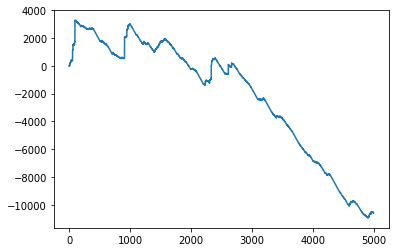

In [653]:
plt.plot(np.cumsum(backtest))

In [666]:
backtest = []
for profit in profits:
    #print('hello')
    try:
        #print(len(profit))
        if len(profit) == 2 and profit[1]>47:
            #print (profit[0])
            #print(hello)
            backtest.append(profit[0]-8)
    except:
        pass

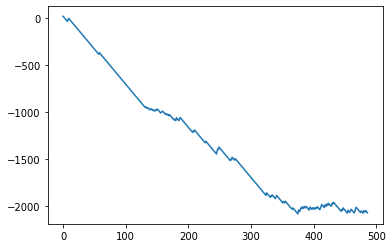

In [667]:
plt.plot(np.cumsum(backtest))

In [659]:
profits[-10:]

[(35.0, 48.62132984929821),
 (0, 53.26446720453458),
 (0, 51.59205453822374),
 (0, 46.70734217056536),
 (25.0, 50.85378852673179),
 (0, 51.15753331916246),
 (0, 46.69591245666481),
 (0, 46.38989221397055),
 (0, 51.274686725685264),
 (0, 52.690053284583904)]

In [672]:
b = np.array(filtered['BigCatDaddy']['history'])
b[0] += -len(filtered['BigCatDaddy']['history'])

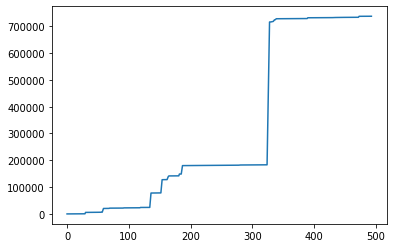

In [673]:
plt.plot(np.cumsum(b))

In [674]:
len(filtered['BigCatDaddy']['history'])

494

In [671]:
np.array(filtered['BigCatDaddy']['history'])

array([50.00, 25.00, 35.00, 20.00, 9.00, 6.00, 6.00, 9.00, 8.00, 8.00,
       40.00, 30.00, 30.00, 25.00, 15.00, 15.00, 6.00, 12.00, 15.00,
       15.00, 15.00, 12.00, 10.00, 9.00, 9.00, 8.00, 35.00, 20.00, 8.00,
       25.00, 5143.00, 15.00, 10.00, 8.00, 25.00, 25.00, 20.00, 15.00,
       15.00, 12.00, 10.00, 8.00, 8.00, 8.00, 25.00, 9.00, 8.00, 8.00,
       9.00, 15.00, 8.00, 9.00, 12.00, 15.00, 300.00, 300.00, 30.00,
       20.00, 6857.00, 6857.00, 15.00, 9.00, 8.00, 8.00, 140.00, 140.00,
       25.00, 20.00, 10.00, 895.00, 8.00, 25.00, 25.00, 8.00, 8.00, 8.00,
       15.00, 15.00, 10.00, 8.00, 25.00, 15.00, 12.00, 12.00, 20.00,
       15.00, 15.00, 15.00, 15.00, 7.00, 7.00, 7.00, 660.00, 6.00, 6.00,
       9.00, 9.00, 9.00, 9.00, 20.00, 20.00, 15.00, 8.00, 9.00, 9.00,
       50.00, 30.00, 20.00, 8.00, 8.00, 8.00, 8.00, 8.00, 8.00, 30.00,
       25.00, 20.00, 50.00, 50.00, 1147.00, 7.00, 6.00, 6.00, 6.00, 20.00,
       9.00, 35.00, 25.00, 25.00, 25.00, 12.00, 9.00, 8.00, 8.00, 8.00,

In [675]:
np.sum(filtered['BigCatDaddy']['history'])

738168.0